#### Update for v1.1
- v1.0 was valid to work
- v1.1 added doPrediction for predict whole CT scan as in test setting. 

# Configuration

In [1]:
# !pip install monai
# !pip install nibabel
# !pip install SimpleITK
# !pip install tensorboard

In [2]:
MODEL_TO_LOAD = ''
FN_LOSS = 0
LEVELS = 6
TRAINING_NAME = f'3D_Unet_DropRes_lv{LEVELS}_All192_BoneSeg'
TB_PREFIX = 'bonemeta_fn_{}'.format(FN_LOSS) + '_{}'.format(TRAINING_NAME)

PATCH_SIZE = 192

# BATCH_SIZE = 120
BATCH_SIZE = 1
EPOCHS = 1500

BASE_DIR = '/workspace/BoneMeta_all_192'
IMG_FOLDER_NAME = 'images_bone'
LABEL_FOLDER_NAME = 'labels'

In [3]:
import os
import sys
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import random

# Set dataset

In [4]:
# !git clone https://github.com/JungOhLee/bonemeta_model.git ./git_clone
# !mv  -v ./git_clone/* .

In [5]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

True

In [6]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/workspace/BoneMeta_all_192/images_bone 317
/workspace/BoneMeta_all_192/labels 317


In [7]:
len(set(IMG_FILES)-set(LABEL_FILES))

0

In [8]:
# # z축 작은 녀석들만 남기기 
# SMALL_Z_CASES = ['000251_20190703_chest', '000356_20191024_chest', '000350_20190927_chest', '000397_20200214_chest', 'BH005_20170701_abdomen', 'BH041_20190201_C-T-L Spine (3D)', 'BH005_20170701_chest', '000355_20190901_abdomen', '000022_20180830_chest', '000244_20190501_abdomen', '000332_20191025_chest', '000019_20181018_chest', 'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult)', '000019_20190613_chest', 'BH017_20191201_abdomen', '000273_20190531_chest', '000404_20200305_chest', '000286_20190701_abdomen', 'SN015_20190901_chest', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast)', '000262_20190501_abdomen', 'SN013_20190401_chest', '000285_20190807_chest', '000362_20191201_abdomen', '000322_20190913_chest', 'BH057_20191227_chest', '000400_20200210_chest', 'BH064_20200605_abdomen', 'BH034_20190901_chest', '000298_20190726_chest', '000311_20190902_chest', '000396_20200201_abdomen', '000223_20190319_chest', 'BH032_20180701_abdomen', '000291_20190701_abdomen', 'BH045_20181001_abdomen', '000296_20190726_chest', 'BH066_20190525_chest', 'BH010_20161101_chest', '000251_20190701_abdomen', 'SN007_20190701_chest', '000193_20190114_chest', '000262_20190529_chest', '000251_20190429_chest', 'BH060_20200413_chest', '000234_20190419_chest', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2)', 'BH070_20160823_chest', '000316_20190627_chest', '000356_20190901_abdomen', '000383_20200121_chest', 'BH052_20190901_chest', '000450_20200512_chest', '000276_20190604_chest', '000364_20191217_chest', 'BH025_20191101_abdomen', 'BH035_20191101_GU Kidney & bladder CT (3D)', 'BH018_20190801_chest', '000269_20190601_abdomen', 'BH008_20190701_chest', '000332_20191001_abdomen', 'BH043_20191001_abdomen', '000260_20190522_chest', 'BH007_20190801_chest', 'BH067_20191017_chest', '000279_20190614_chest', 'SN004_20190901_chest', 'BH042_20180801_C-T-L Spine (3D)', 'BH099_20200806_abdomen', 'BH055_20200328_chest', 'BH001_20190401_chest', '000162_20180131_chest', 'BH054_20191122_abdomen', '000450_20200501_abdomen', 'BH030_20160101_T-L spine (3D)', '000372_20200107_chest', 'BH069_20200505_chest', 'BH012_20180401_abdomen', 'BH058_20180918_chest', '000404_20200201_abdomen', 'BH048_20190501_chest', '000348_20191201_CT Liver (contrast)', 'BH002_20190701_chest', '000376_20200101_abdomen', '000309_20190801_abdomen', 'SN017_20190701_chest', 'BH029_20200101_chest', 'BH059_20201013_abdomen', '000310_20190801_abdomen', '000272_20190614_chest', 'BH027_20191001_L-spine CT (3D)', 'BH064_20200605_chest', '000350_20191001_abdomen', '000232_20190423_chest', 'BH001_20190501_abdomen', 'BH039_20190601_chest', 'SN008_20190901_chest', '000270_20190608_chest', 'BH091_20200104_chest', '000269_20190604_chest', '000331_20190916_chest', '000325_20190919_chest', '000363_20191222_chest', '000260_20190501_CT Liver (contrast)', '000330_20190926_chest', 'BH072_20200219_abdomen', '000324_20190910_chest', 'BH009_20180301_chest', 'BH028_20190801_chest', 'SN029_20200301_chest', 'BH110_20200616_chest', '000401_20200201_T-Spine+3D CT (noncontrast)', 'SN031_20160501_chest', 'SN005_20191101_chest', '000452_20200513_chest', '000021_20181227_chest', '000236_20190401_abdomen', 'SN002_20190801_chest', '000382_20200129_chest', '000301_20190801_Pulmonary artery CT Angio+3D (contrast)', 'BH015_20190101_chest', 'BH043_20191001_chest', 'BH063_20200519_chest', '000363_20191201_abdomen', '000354_20191001_abdomen', 'BH047_20180901_abdomen', '000079_20180911_Pulmonary artery CT Angio+3D (contrast)', 'BH016_20151001_chest', 'BH061_20190315_abdomen', 'BH014_20181201_chest', '000362_20191214_chest', '000354_20191022_chest', 'SN051_20170401_chest', 'SN036_20190601_chest', 'BH017_20191201_chest', '000282_20190701_abdomen', 'BH023_20191101_chest', '000085_20180829_chest', 'SN019_20190801_chest', '000212_20190324_chest', '000302_20190726_chest', 'BH009_20180301_abdomen', 'BH008_20190701_abdomen', '000301_20190801_abdomen', 'BH015_20190101_abdomen', 'SN028_20160801_chest', '000344_20191125_chest', 'BH014_20181201_abdomen', '000214_20190325_chest', '000386_20200204_chest', '000372_20200101_abdomen', 'BH091_20200104_GU Kidney & bladder CT (3D)', 'SN025_20200401_chest', '000400_20200201_CT Biliary (contrast)', '000255_20190418_chest', 'BH081_20190322_abdomen', '000315_20190820_chest', '000288_20190701_abdomen', '000272_20190601_abdomen', '000322_20190901_abdomen', '000331_20190901_abdomen', 'SN055_20170301_chest', 'BH052_20190901_abdomen', '000310_20190812_chest', '000069_20180319_chest', 'BH024_20190501_abdomen', 'BH021_20181001_abdomen', '000009_20180417_chest', 'BH037_20171101_abdomen', '000002_20180829_chest', '000234_20190401_abdomen', '000262_20190318_chest', 'SN016_20190901_chest', '000232_20190401_abdomen', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult)', '000300_20190801_abdomen', 'BH006_20170801_chest', '000278_20190620_chest', 'BH036_20180301_GU Kidney & bladder CT (3D)', 'BH019_20191101_chest', 'BH004_20191101_chest', '000382_20200101_abdomen', '000242_20190409_chest', 'BH061_20190315_chest', '000080_20180911_chest', '000355_20191023_chest', '000364_20191201_abdomen', 'BH018_20190801_abdomen', '000291_20190718_chest', '000279_20190601_abdomen', '000308_20190826_chest', '000305_20190801_abdomen', 'BH010_20161101_abdomen', 'BH007_20190801_abdomen', 'BH021_20181001_chest', '000396_20200218_chest', '000091_20180504_chest', 'SN042_20170901_chest', '000314_20190827_chest', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism)', 'BH023_20191101_abdomen', '000301_20190827_chest', 'BH062_20201104_chest', 'BH020_20191201_chest', 'BH059_20201019_chest', '000246_20190629_chest', 'BH026_20190601_abdomen', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism)', 'BH034_20190901_abdomen', 'BH099_20200806_chest', 'BH051_20190301_GU Kidney & bladder CT (3D)', '000368_20200101_abdomen', 'BH057_20191227_abdomen', 'BH112_20190201_chest', 'BH024_20190501_chest', 'BH013_20191001_chest', '000309_20190823_chest', '000011_20181207_chest', 'BH020_20191201_abdomen', 'BH027_20191001_chest', '000316_20190715_Spine^L_SPINE (Adult)', '000012_20181214_chest', 'BH032_20180701_chest', 'BH037_20171101_chest', '000285_20190801_abdomen', 'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2)', 'BH072_20200219_chest', 'SN054_20170201_chest', '000048_20190501_abdomen', '000304_20190124_chest', 'BH045_20181001_chest', '000352_20191001_abdomen', 'BH016_20151001_abdomen', 'BH022_20190101_chest', 'BH047_20180901_chest', '000314_20190901_abdomen', 'BH065_20201013_chest', 'BH056_20200721_chest', '000281_20190701_chest', '000025_20180808_chest', '000352_20191017_chest', 'BH012_20180401_chest', '000224_20190228_chest', '000308_20190801_abdomen', '000376_20200114_chest']
# SMALL_Z_FILES = [case_to_file(case) for case in SMALL_Z_CASES]
# IMG_FILES = list(set(IMG_FILES).intersection(SMALL_Z_FILES))
# len(IMG_FILES)

In [9]:
TRAIN_FILES = ['KH027_20210801_Chest(+).npy', 'SN005_20191101_CT_Chest_+_3D_(contr.npy', 'BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000311_20190902_Chest_CT_(contrast).npy', 'BH023_20191101_Abdomen_&_pelvis_CT_(3D).npy', 'BH076_20180605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH121_20200301_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000506_20201113_Chest_CT_(contrast).npy', 'BH069_20200505_Chest_CT_(contrast)_+_3D.npy', 'KH039_20210301_Chest_(-)_Routine.npy', 'KH042_20210501_Chest(+).npy', 'BH016_20151001_Abdomen_&_pelvis_CT_(3D).npy', 'BH104_20161219_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000362_20191201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH035_20191101_GU_Kidney_&_bladder_CT_(3D).npy', '000423_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'SN036_20190601_CT_Chest_+_3D_(contr.npy', 'BH101_20201109_Chest_CT_(Contrast)_+_3D(TS).npy', 'SN025_20200401_CT_Chest_+_3D_(contr.npy', '000364_20191217_Chest_CT_(contrast).npy', 'BH085_20200801_Abdomen_&_pelvis_CT.npy', 'KH023_20210901_Chest(+).npy', 'BH063_20200519_Chest_CT_(Non_contrast)_+_3D(Breast).npy', '000224_20190228_Chest_CT_(contrast).npy', 'BH116_20180606_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH023_20191101_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH055_20200328_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH002_20210301_Abdomen^00_AbdomenRoutine_(Adult).npy', '000370_20200101_CT_Abdomen+Pelvis_Post_(contrast).npy', '000363_20191222_Chest_3DCT_(contrast).npy', 'BH020_20191201_Chest_CT_(Non_contrast)_+_3D.npy', 'BH015_20190101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH016_20191101_Chest(+).npy', '000262_20190501_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH081_20190322_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000282_20190701_CT_Abdomen+Pelvis_Post_(contrast).npy', 'SN042_20170901_CT_Chest_+_3D_(contr.npy', 'BH071_20160826_Chest_CT_(contrast)_+_3D.npy', '000356_20191024_Chest_CT_(contrast).npy', '000162_20180131_Chest_CT_(contrast).npy', '000269_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH119_20200303_Abdomen_&_pelvis_CT_(3D).npy', 'BH043_20191001_Abdomen_&_pelvis_CT_(3D).npy', 'SN031_20160501_2-CT_Chest_Lung_cancer.npy', '000530_20210428_Chest_CT_(contrast).npy', 'BH005_20170707_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', '000363_20191201_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'KH001_20210501_Chest(+).npy', 'KH031_20210801_Chest(+).npy', 'KH010_20201201_Chest(+).npy', '000370_20200117_Chest_CT_(contrast).npy', 'BH037_20171125_Abdomen_&_pelvis_CT_(3D).npy', '000080_20180911_Chest_CT_(contrast).npy', '000262_20190318_Chest_CT_(contrast).npy', 'BH117_20180506_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH034_20190923_GU_OBGY,Abd-pelvis_CT(pre&post)_(3D).npy', 'BH123_20201023_Abdomen_&_pelvis_CT.npy', 'BH061_20190315_Abdomen_&_pelvis_CT_(3D).npy', 'KH007_20200601_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'BH028_20190801_Chest_CT_(contrast)_+_3D.npy', '000085_20180829_Chest_CT_(contrast).npy', '000010_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000435_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH019_20191101_Thorax^02_Chest_CON_(Adult).npy', '000386_20200204_Chest_CT_(contrast).npy', '000466_20210128_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH098_20200626_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000325_20190919_Chest_CT_(contrast).npy', '000481_20210305_Thorax^Lung_Pre_(Adult).npy', 'BH108_20180228_Chest_CT_(contrast)_+_3D.npy', 'KH014_20190701_Chest(+).npy', 'SN051_20170401_CT_Chest_+_3D_(contrast_NO_CM).npy', 'BH056_20200721_Chest_CT_(contrast)_+_3D.npy', 'KH014_20190701_IM_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'BH091_20200104_GU_Kidney_&_bladder_CT_(3D).npy', 'BH064_20200605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH070_20160823_Abdomen_&_pelvis_CT_(3D).npy', 'BH089_20200811_Abdomen_&_pelvis_CT.npy', 'KH043_20210601_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy', '000279_20190614_Chest_3DCT_(contrast).npy', 'BH031_20160301_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH080_20181210_Abdomen_&_pelvis_CT_(3D).npy', 'BH036_20180301_GU_Kidney_&_bladder_CT_(3D).npy', '000272_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000079_20180911_Pulmonary_artery_CT_Angio+3D_(contrast).npy', '000022_20180830_Chest_CT_(contrast).npy', 'KH026_20210801_Chest(+).npy', 'BH120_20200406_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH073_20201223_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH100_20201007_Thorax^02_Chest_CON_(Adult).npy', 'BH086_20190812_Chest_CT_(Contrast)_+_3D(TS).npy', '000322_20190913_Chest_CT_(contrast).npy', 'BH095_20200727_Abdomen_&_pelvis_CT_(3D).npy', 'BH114_20180920_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH016_20191101_Chest(+)_+_Abdomen_&_Pelvis(+).npy', 'SN028_20160801_CT_Abdomen+Pelvis_3D_(contrast).npy', 'SN055_20170301_CT_Chest_Low_Dose_+.npy', 'KH037_20210401_Chest(+).npy', '000309_20190823_Chest_CT_(contrast).npy', 'SN019_20190801_CT_Abdomen+Pelvis_Ar.npy', '000404_20200201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000528_20210514_Chest_CT_(contrast).npy', '000301_20190827_Chest_CT_(contrast).npy', '000424_20200218_Chest_CT_(contrast).npy', 'BH061_20190315_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH120_20200304_Chest_CT_(contrast)_+_3D.npy', 'BH105_20160820_Chest_CT_(contrast)_+_3D.npy', 'BH123_20201023_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH005_20170701_Abdomen_&_pelvis_CT_(3D).npy', 'BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy', '000262_20190529_Chest_CT_(contrast).npy', 'BH013_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000481_20200722_Chest_CT_(noncontrast).npy', 'BH012_20180401_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH054_20191122_Abdomen^00_Liver_CT_(Adult).npy', '000011_20181207_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH059_20201013_Abdomen_&_pelvis_CT.npy', 'BH082_20200416_Chest_CT_(contrast)_+_3D.npy', 'BH010_20161101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH121_20200301_Abdomen_&_pelvis_CT_(3D).npy', 'SN007_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', '000409_20200310_Chest_CT_(contrast).npy', 'BH111_20161020_CT_Angio_+_3D_Coronary,_Chest.npy', 'SN031_20160501_CT_Abdomen+Pelvis_Ar.npy', 'BH118_20200702_Chest_CT_(contrast)_+_3D.npy', '000560_20210706_Chest_CT_(contrast).npy', '000322_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000048_20190501_CT_Abdomen+Pelvis_Uro_(contrast).npy', 'SN019_20190801_CT_Chest_+_3D_(contr.npy', '000506_20201110_CT_Urography_(contrast).npy', '000423_20200407_Chest_CT_(contrast).npy', 'BH032_20180701_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH033_20210701_Chest(+).npy', 'BH106_20200613_Abdomen_&_pelvis_CT_(3D).npy', 'BH114_20180920_GU_Kidney_&_bladder_CT_(3D).npy', 'BH008_20190701_Abdomen_&_pelvis_CT_(3D).npy', 'BH067_20191017_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000475_20210210_Chest_CT_(contrast).npy', '000417_20200331_Chest_CT_(contrast).npy', 'BH026_20190601_Abdomen_&_pelvis_CT_(3D).npy', '000262_20190319_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH008_20190701_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH015_20190101_Abdomen_&_pelvis_CT_(3D).npy', 'BH090_20200924_Abdomen_&_pelvis_CT.npy', 'BH089_20200803_Chest_CT_(Contrast)_+_3D(TS).npy', '000305_20190801_CT_Acute_Abdomen_(contrast).npy', 'BH106_20200613_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH120_20200406_Abdomen_&_pelvis_CT_(3D).npy', '000278_20190620_Chest_CT_(contrast).npy', 'BH012_20180401_Abdomen_&_pelvis_CT_(3D).npy', 'SN002_20190801_CT_Chest_+_3D_(contr.npy', 'BH016_20151001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000560_20210706_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'KH032_20210701_Chest(+).npy', 'BH064_20200605_Abdomen_&_pelvis_CT_(3D).npy', '000352_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000424_20200312_Chest_CT_(noncontrast).npy', '000269_20190325_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH107_20200510_Chest_CT_(Contrast)_+_3D(TS).npy', 'SN005_20191001_Abdomen^03_LIVER_(Adult).npy', '000242_20190409_Chest_CT_(contrast).npy', 'BH010_20161101_Abdomen_&_pelvis_CT_(3D).npy', '000291_20190718_Chest_CT_(contrast).npy', '000296_20190726_Chest_CT_(contrast).npy', 'BH081_20190322_Abdomen_&_pelvis_CT_(3D).npy', 'KH030_20210901_Chest_Low-Dose_Screeni.npy', 'KH036_20210401_Chest(+).npy', '000330_20190926_Chest_CT_(contrast).npy', 'KH010_20201201_Chest(+)_+_Abdomen_&_P.npy', '000362_20191214_Chest_CT_(contrast).npy', 'KH028_20210401_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'KH040_20210301_Chest(+).npy', 'SN051_20170401_CT_Abdomen+Pelvis_Arterial+Portal_(contrast).npy', '000400_20200201_CT_Biliary_(contrast).npy', '000368_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000302_20190726_Chest_CT_(contrast).npy', 'BH048_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH078_20200522_Abdomen_&_pelvis_CT_(3D).npy', '000269_20181016_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000352_20191017_Chest_CT_(contrast).npy', '000356_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH104_20161219_Abdomen_&_pelvis_CT_(3D).npy', 'BH075_20200721_Chest_CT_(Contrast)_+_3D(Breast).npy', 'BH029_20200101_Chest_HRCT_(lung_cancer).npy', '000069_20180319_Chest_CT_(contrast).npy', '000025_20180808_Chest_CT_(contrast).npy', '000270_20190608_Chest_CT_(contrast).npy', '000409_20200301_CT_Biliary_(contrast).npy', 'BH073_20201223_Abdomen_&_pelvis_CT.npy', 'BH113_20170914_Liver_CT_(LC_or_CLD,_3D).npy', '000212_20190324_Chest_CT_(noncontrast).npy', '000494_20210405_Chest_CT_(contrast).npy', 'BH108_20180223_Liver_CT_(LC_or_CLD,_3D).npy', 'SN042_20170901_CT_Abdomen+Pelvis_3D.npy', '000492_20210401_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'KH025_20211001_Chest(+).npy', '000021_20181227_Chest_CT_(contrast).npy', '000332_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy', '000372_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'SN012_20150801_Abdomen^01_Abdomen_Pelvis_Chest_(Adult).npy', 'SN054_20170201_CT_Chest_Lung_cancer+3D(contrast).npy', '000011_20181207_Chest_CT_(contrast).npy', 'BH070_20160823_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH024_20211001_Chest(+).npy', 'BH074_20201113_Abdomen^00_Abd_CT_(Adult).npy', '000291_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH109_20181210_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', '000376_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH117_20180506_Abdomen_&_pelvis_CT_(3D).npy', 'BH043_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH009_20200801_Chest(+).npy', '000376_20200114_Chest_CT_(contrast).npy', '000400_20200210_Chest_CT_(contrast).npy', '000269_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH037_20171125_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH007_20200601_Chest(+).npy', '000025_20180808_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000301_20190801_CT_Acute_Abdomen_(contrast).npy', '000309_20190801_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH076_20180605_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH007_20190801_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000557_20210621_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH079_20200921_Low_dose_Chest_CT_+_3D(insured).npy', 'BH119_20200227_Chest_CT_(contrast)_+_3D.npy', 'BH066_20190525_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH045_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000282_20190410_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH051_20190301_GU_Kidney_&_bladder_CT_(3D).npy', '000557_20210621_Chest_CT_(contrast).npy', 'BH098_20200626_GU_Kidney_&_bladder_CT_(3D).npy', '000304_20190124_CT_Liver_(contrast).npy', '000466_20210125_Chest_CT_(contrast).npy', '000272_20190614_Chest_CT_(contrast).npy', 'KH009_20200801_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', '000541_20210520_Chest_CT_(contrast).npy', '000435_20200420_Chest_CT_(contrast).npy', '000481_20210409_CT_Liver_(contrast).npy', 'BH087_20190314_Abdomen_&_pelvis_CT_(3D).npy', '000533_20210507_CT_Liver_(contrast).npy', '000404_20200305_Chest_CT_(contrast).npy', 'BH007_20190801_Abdomen_&_pelvis_CT_(3D).npy', '000308_20190826_Chest_CT_(contrast).npy', 'KH038_20210401_Chest(+).npy', 'BH034_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000344_20191125_Chest_CT_(contrast).npy', 'BH116_20180606_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH002_20210301_Thorax^00_Fl_Chest_Routine_(Adult).npy']
VAL_FILES = ['BH099_20200806_Abdomen_&_pelvis_CT.npy', '000019_20181018_Chest_CT_(contrast).npy', 'SN017_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', '000251_20190429_Chest_CT_(contrast).npy', 'SN035_20180101_CT_Stomach+Pelvis_Arterial+Portal(contrast).npy', '000232_20190423_Chest_CT_(contrast).npy', 'BH027_20191001_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH024_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH027_20191001_L-spine_CT_(3D).npy', '000286_20190710_[외부_CT_19-07-10]Chest_CT_contrast.npy', '000232_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000251_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH099_20200806_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000285_20190807_Chest_CT_(contrast).npy', 'BH024_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH021_20181001_Abdomen_&_pelvis_CT_(3D).npy', '000316_20190715_Spine^L_SPINE_(Adult).npy', '000193_20190114_Chest_CT_(contrast).npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D_(Adult).npy', '000316_20190627_Chest_CT_(contrast).npy', '000251_20190703_Chest_CT_(contrast).npy', 'BH110_20200616_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH006_20170801_Chest_CT_(Contrast)_+_3D(Breast).npy', '000450_20200528_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH021_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH065_20201013_Low_dose_Chest_CT_+_3D(insured).npy', '000019_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH060_20200413_Chest_CT_(contrast)_+_3D.npy', 'SN016_20190901_CT_Abdomen+Pelvis_Ar.npy', '000450_20200512_Chest_CT_(contrast).npy', '000285_20190801_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'BH062_20201104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000251_20190429_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000019_20190613_Chest_CT_(contrast).npy', 'SN004_20190901_CT_Chest_+_3D_(contrast).npy', '000286_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy']
TEST_FILES = ['000214_20190325_Chest_CT_(contrast).npy', '000234_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000234_20190419_Chest_CT_(contrast).npy', '000236_20190401_CT_Abdomen+Pelvis_Post_(contrast).npy', '000244_20190501_CT_Abdomen+Pelvis_Post_(contrast).npy', '000255_20190418_Chest_CT_(contrast).npy', '000260_20190501_CT_Liver_(contrast).npy', '000260_20190522_Chest_CT_(contrast).npy', '000276_20190604_Chest_CT_(contrast).npy', '000281_20190701_Chest_CT_(contrast).npy', '000288_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000298_20190726_Chest_CT_(contrast).npy', '000314_20190827_Chest_CT_(contrast).npy', '000314_20190901_CT_Acute_Abdomen_(contrast).npy', '000354_20191001_CT_Abdomen+Pelvis_Post_(contrast).npy', '000354_20191022_Chest_CT_(contrast).npy', '000355_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000355_20191023_Chest_CT_(contrast).npy', '000383_20200121_Chest_CT_(contrast).npy', 'BH001_20190401_Chest_CT_(Non_contrast)_+_3D.npy', 'BH001_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Chest_CT_(contrast)_+_3D_(TS_with_other_CT).npy', 'BH014_20181201_Abdomen_&_pelvis_CT_(3D).npy', 'BH014_20181201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH017_20191201_Abdomen_&_pelvis_CT_(3D).npy', 'BH017_20191201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH022_20190101_Thorax^03_Chest_NON_(Adult).npy', 'BH047_20180901_Abdomen_&_pelvis_CT_(3D).npy', 'BH047_20180901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH052_20190901_Abdomen_&_pelvis_CT_(3D).npy', 'BH052_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH057_20191227_Abdomen_&_pelvis_CT_(3D).npy', 'BH057_20191227_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH058_20180918_Chest_CT_(contrast)_+_3D.npy', 'BH112_20190201_Abdomen_&_pelvis_CT_(3D).npy', 'BH112_20190201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'SN016_20190901_CT_Chest_+_3D_(contr.npy', 'SN028_20160801_CT_Chest_+_3D_(contrast).npy']

# EXCEPTIONS = ['BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy'] # 모델에서 data info 만들때 가끔 오류남.
EXCEPTIONS = '''000273_20190531_Chest_CT_(contrast).npy
000439_20200624_Chest_CT_(contrast).npy
000557_20210621_Chest_CT_(contrast).npy
BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
000350_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000352_20191017_Chest_CT_(contrast).npy
000354_20191022_Chest_CT_(contrast).npy
000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy
BH027_20191001_L-spine_CT_(3D).npy
000270_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000270_20190608_Chest_CT_(contrast).npy
BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy
BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy
000424_20200312_Chest_CT_(noncontrast).npy
000424_20200218_Chest_CT_(contrast).npy
000325_20190919_Chest_CT_(contrast).npy
BH069_20200505_Chest_CT_(contrast)_+_3D.npy'''.split('\n')

TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
VAL_FILES = list(set(VAL_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
TEST_FILES = list(set(TEST_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))

# TRAIN_FILES = TRAIN_FILES[:50]
# VAL_FILES = VAL_FILES[:15]

In [10]:
TRAIN_FILES = list(set(TRAIN_FILES) - set(VAL_FILES) - set(TEST_FILES))
VAL_FILES = list(set(VAL_FILES))
TEST_FILES = list(set(TEST_FILES))

In [11]:
print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 238
val: 35
test: 30
total: 303



In [12]:
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

# Set dataloader

In [13]:
import torch 
import numpy as np
import time
import os, glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from augmentation import get_transform


class TrainDataset(Dataset):
    def __init__(self, case_files=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

    def get_data_info(self):
        all_data_info = pd.read_csv(f'{BASE_DIR}/data_info_V_2022_04_20.csv')
        case_tuple = tuple([file_to_case(file) for file in self.case_files])
        include_idx = all_data_info.Case.str.startswith(case_tuple)
        return all_data_info.loc[include_idx]
        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        return self.get_case(idx)
    
    def get_case(self, idx):
        patch_image = self.images[idx]
        patch_label = self.labels[idx]
        return self.process_patch(patch_image, patch_label)

    def process_patch(self, patch_image, patch_label):
#         patch_image, patch_label = torch.tensor(patch_image, dtype=torch.float32), torch.tensor(patch_label, dtype=torch.bool)
#         return self.convert_to_multi_channel_img(patch_image, self.windows), patch_label
        augmentation_dict={'flip': True, 'scale':0.2, 'rotate':False,'offset': 0.1, 'noise': 0.1}
        transformed_image, transformed_label = get_transform(patch_image, patch_label, augmentation_dict)
        return self.convert_to_multi_channel_img(transformed_image, self.windows), transformed_label   
    
    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [14]:
class ValDataset(Dataset):
    def __init__(self, case_files=None, ):
        """
        Args:
            case_files (string): case filenames
        Return:
            one whole case

        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        image_tensor = torch.tensor(image, dtype = torch.float32)
        multi_channel_image = self.convert_to_multi_channel_img(image_tensor, self.windows)
        return multi_channel_image, torch.tensor(label, dtype = torch.bool)
    
    def change_to_pytorch_coord(self, coord):
        # 현재 데이터 저장이 col, row, z 로 되어있음. -> z, row, col로 변경
        return [coord[2],coord[1],coord[0]]

    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [15]:
# len(train_dataset)

In [16]:
def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)

def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()

In [17]:
# img, label = train_dataset[0]
# plot_img_and_label(img[0].type(torch.int16).numpy(), label.type(torch.uint8).numpy())

# # plot_img_and_label(*train_dataset[0])

In [18]:
t = time.perf_counter()

train_dataset = TrainDataset(TRAIN_FILES)
val_dataset = ValDataset(VAL_FILES)

elapsed_time = time.perf_counter() - t

print(f'''
consumed_time: {elapsed_time}s
train: {len(train_dataset)}
val: {len(val_dataset)}
''')



consumed_time: 2.802138989995001s
train: 238
val: 35



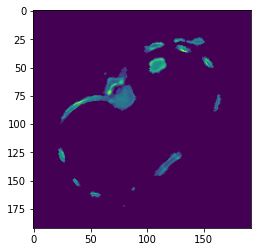

In [19]:
import matplotlib.pyplot as plt

sample_train = train_dataset[9]
plt.imshow(sample_train[0][2][PATCH_SIZE//2])

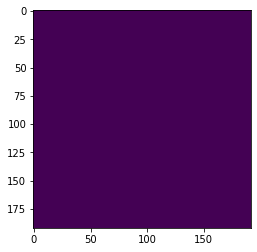

In [20]:
plt.imshow(sample_train[1][PATCH_SIZE//2])

# Dataloader 

In [21]:
import multiprocessing
multiprocessing.cpu_count()

48

In [22]:
from torch.utils.data import DataLoader

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = 8

def initTrainDl(train_ds, batch_size = BATCH_SIZE):
    if USE_CUDA:
        batch_size *= torch.cuda.device_count()

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
        shuffle=True,
        drop_last=False # to prevent gradient exploding
    )
    return train_dl

def initValDl(val_ds, batch_size = BATCH_SIZE):
    val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
    )
    return val_dl

# Set for training

In [23]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

In [24]:
import datetime
# For logging 
trn_writer = None
val_writer = None
# TB_PREFIX = img_type + "_fn0"
time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

In [25]:
# Used for computeClassificationLoss and logMetrics to index into metrics_t/metrics_a
# METRICS_LABEL_NDX = 0
METRICS_LOSS_NDX = 1
# METRICS_FN_LOSS_NDX = 2
# METRICS_ALL_LOSS_NDX = 3

# METRICS_PTP_NDX = 4
# METRICS_PFN_NDX = 5
# METRICS_MFP_NDX = 6
METRICS_TP_NDX = 7
METRICS_FN_NDX = 8
METRICS_FP_NDX = 9

METRICS_SIZE = 10

In [26]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import ResidualUNet3D, DropResidualUNet3D

def initModel():    
    segmentation_model = DropResidualUNet3D(in_channels=3, out_channels=1, num_groups=32, f_maps=32, final_sigmoid=True, testing=True, num_levels=LEVELS)

    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model)
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=0.0001, weight_decay=0.00002)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])
    

In [27]:
segmentation_model

DataParallel(
  (module): DropResidualUNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): DropResNetBlock(
          (conv1): SingleConv(
            (groupnorm): GroupNorm(1, 3, eps=1e-05, affine=True)
            (conv): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv2): SingleConv(
            (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv3): SingleConv(
            (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (dropout): Dropout(p=0.5, inplace=False)
          (non_linearity): ReLU(inplace=True)
        )
      )
      (1): Encoder(
    

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(segmentation_model)

141494439

In [29]:
from util.util import enumerateWithEstimate

def doTraining(epoch_ndx, train_dl):
    trnMetrics_g = torch.zeros(METRICS_SIZE, len(train_dl.dataset), device=DEVICE)
    segmentation_model.train()
    # train_dl.dataset.shuffleSamples() - 정의에서 처리했음

    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, batch_tup in batch_iter:
        optimizer.zero_grad()

        loss_var = computeBatchLoss(batch_ndx, batch_tup, train_dl.batch_size, trnMetrics_g)
        loss_var.backward()
        
        # Gradient clipping 
        max_norm = 5
        torch.nn.utils.clip_grad_norm_(segmentation_model.parameters(), max_norm)
        optimizer.step()
    global totalTrainingSamples_count
    totalTrainingSamples_count += trnMetrics_g.size(1)

    return trnMetrics_g.to('cpu')

def doValidation(epoch_ndx, val_dl):
    with torch.no_grad():
        valMetrics_g = torch.zeros(METRICS_SIZE, len(val_dl.dataset), device=DEVICE)
        segmentation_model.eval()

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            computeBatchLossVal(batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)

    return valMetrics_g.to('cpu')

def computeBatchLoss(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    # if segmentation_model.training and augmentation_dict:
    #     input_g, label_g = augmentation_model(input_g, label_g)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    fnLoss_g = diceLoss(prediction_g * label_g, label_g)
    ceLoss = nn.BCELoss()
    ceLoss_g = ceLoss(prediction_g, label_g.float())
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean() + ceLoss_g + fnLoss_g.mean() * FN_LOSS 

def computeBatchLossVal(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean()

def diceLoss(prediction_g, label_g, epsilon=0.00001):
    diceLabel_g = label_g.sum(dim=[1,2,3])
    dicePrediction_g = prediction_g.sum(dim=[1,2,3])
    diceCorrect_g = (prediction_g * label_g).sum(dim=[1,2,3])

    diceRatio_g = (2 * diceCorrect_g + epsilon) \
        / (dicePrediction_g + diceLabel_g + epsilon)

    return 1 - diceRatio_g

In [30]:
from torch.utils.tensorboard import SummaryWriter

def logMetrics(epoch_ndx, mode_str, metrics_t, tb_type = TB_PREFIX):
    log.info("E{} {} {}".format(
        epoch_ndx,
        "Unet",
        tb_type
    ))

    metrics_a = metrics_t.detach().numpy()
    sum_a = metrics_a.sum(axis=1)
    assert np.isfinite(metrics_a).all()

    allLabel_count = sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]

    metrics_dict = {}
    metrics_dict['loss/all'] = metrics_a[METRICS_LOSS_NDX].mean()

    metrics_dict['percent_all/tp'] = \
        sum_a[METRICS_TP_NDX] / (allLabel_count or 1) * 100 
    metrics_dict['percent_all/fn'] = \
        sum_a[METRICS_FN_NDX] / (allLabel_count or 1) * 100
    metrics_dict['percent_all/fp'] = \
        sum_a[METRICS_FP_NDX] / (allLabel_count or 1) * 100


    precision = metrics_dict['pr/precision'] = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FP_NDX]) or 1)
    recall    = metrics_dict['pr/recall']    = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]) or 1)

    metrics_dict['pr/f1_score'] = 2 * (precision * recall) \
        / ((precision + recall) or 1)

    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{pr/precision:.4f} precision, "
              + "{pr/recall:.4f} recall, "
              + "{pr/f1_score:.4f} f1 score"
              ).format(
        epoch_ndx,
        mode_str,
        **metrics_dict,
    ))
    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{percent_all/tp:-5.1f}% tp, {percent_all/fn:-5.1f}% fn, {percent_all/fp:-9.1f}% fp"
    ).format(
        epoch_ndx,
        mode_str + '_all',
        **metrics_dict,
    ))
    global trn_writer
    global val_writer
    initTensorboardWriters()
    if mode_str == 'trn':
      writer = trn_writer
    elif mode_str == 'pred':
      writer = pred_writer
    else:
      writer = val_writer

    prefix_str = 'seg_'

    global totalTrainingSamples_count
    for key, value in metrics_dict.items():
        writer.add_scalar(prefix_str + key, value, totalTrainingSamples_count)

    writer.flush()

    score = metrics_dict['pr/recall']

    return score

import os

LOG_DIR = os.path.join(BASE_DIR, 'logs')
if not os.path.exists(LOG_DIR):
  os.mkdir(LOG_DIR)
  
def initTensorboardWriters():
    global trn_writer
    global val_writer
    global pred_writer
    if trn_writer is None:
        trn_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_trn_seg_{}').format(TB_PREFIX, time_str) )
        val_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_val_seg_{}').format(TB_PREFIX, time_str) )
#         pred_writer = SummaryWriter(
#             log_dir= os.path.join(LOG_DIR, '{}_pred_seg_{}').format(TB_PREFIX, time_str) )

In [31]:
def saveModel(type_str, epoch_ndx, tb_pre = TB_PREFIX):
    model_name = '{}_model_epoch{}'.format(tb_pre, epoch_ndx)
    file_path = os.path.join(
        BASE_DIR,
        'models',
        model_name
        )

    os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

    model = segmentation_model
    if isinstance(model, torch.nn.DataParallel):
        model = model.module

    state = {
        'sys_argv': sys.argv,
        'time': str(datetime.datetime.now()),
        'model_state': model.state_dict(),
        'model_name': type(model).__name__,
        'optimizer_state' : optimizer.state_dict(),
        'optimizer_name': type(optimizer).__name__,
        'epoch': epoch_ndx,
        'totalTrainingSamples_count': totalTrainingSamples_count,
    }
    torch.save(state, file_path)
    log.info(f"Model was saved to {file_path}")
#     remote_location = 's3://{0}'.format(os.path.join(s3bucket, 'result/models', model_name))
#     S3FS.put(file_path, remote_location)
#     log.info("Saved model params to {} and remote S3 bucket".format(file_path))

    with open(file_path, 'rb') as f:
        log.info("SHA1: " + hashlib.sha1(f.read()).hexdigest())

In [32]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군

def pad_for_division(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    assert patch_d % 32 == 0 & patch_h % 32 == 0 & patch_w % 32 == 0, "Patch size should be divided by 32"
    padding_d = patch_d - image.size(0)%patch_d
    padding_h = patch_h - image.size(1)%patch_h
    padding_w = patch_w - image.size(2)%patch_w
    padded_image = F.pad(image, (0, padding_w, 0, padding_h, 0, padding_d))
    return padded_image 

def pad_for_half(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    padded_image = F.pad(image, (patch_w//2, patch_w//2, patch_h//2, patch_h//2, patch_d//2, patch_d//2))
    return padded_image 

    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = [(500,200), (700,400), (1200,400)]
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        batch = convert_to_multi_channel_img(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        proccessed_batch = model(batch).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

def predict_one_case(image_t, batch_size ,patch_size):
    pad_image = pad_for_division(image_t, patch_size)
    half_pad_image = pad_for_half(pad_image, patch_size)
    d,h,w = image_t.shape
    half_pad_d, half_pad_h, half_pad_w = [size//2 for size in patch_size]
    
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(pad_image, segmentation_model, batch_size, patch_size)
        pred_half_pad_label = pred_image_with_model(half_pad_image, segmentation_model, batch_size, patch_size)
        
    cropped_pred = pred_label[:d, :h, :w]
    cropped_pred_2 = pred_half_pad_label[half_pad_d:half_pad_d+d, half_pad_h:half_pad_h+h, half_pad_w:half_pad_w+w]
    mean_pred = (cropped_pred + cropped_pred_2) / 2
    return mean_pred


def doPrediction(epoch_ndx, files, batch_size, patch_size):
    log.info("E{} Prediction {}".format(epoch_ndx, TB_PREFIX))
    predMetrics_g = torch.zeros(METRICS_SIZE, len(files), device=DEVICE)
    segmentation_model.eval()
    
    for i, file in enumerate(files):
        image = np.load(get_img_path(file))
        image_t = torch.tensor(image)
        label = np.load(get_label_path(file))
        
        pred = predict_one_case(image_t, batch_size, patch_size)
        pred_t = pred > 0.5 # classificationThreshold = 0.5
        label_t = torch.tensor(label)
        
        predictionBool_g = pred_t.unsqueeze(0).to(torch.float32)
        label_g = label_t.unsqueeze(0)
        
        diceLoss_g = diceLoss(predictionBool_g, label_g, epsilon=0.01)
        fnLoss_g = diceLoss(predictionBool_g * label_g, label_g)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])
        
        predMetrics_g[METRICS_LOSS_NDX, i] = diceLoss_g # 차원 에러날듯 - i로 골라버리면 차원이 하나 줄기 때문.. 확인해봐야함. 
        predMetrics_g[METRICS_TP_NDX, i] = tp
        predMetrics_g[METRICS_FN_NDX, i] = fn
        predMetrics_g[METRICS_FP_NDX, i] = fp
        
    return predMetrics_g.to('cpu')

# Train

In [33]:
log.info("Starting traning...")

train_dl = initTrainDl(train_dataset)
val_dl = initValDl(val_dataset)

best_score = 0.0
validation_cadence = 20
pred_cadence = 20

totalTrainingSamples_count = 0 

2022-07-21 14:05:43,125 INFO     pid:33790 3DUnet:001:<module> Starting traning...


In [34]:
for epoch_ndx in range(1, EPOCHS + 1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-07-21 14:05:43,135 INFO     pid:33790 3DUnet:008:<module> Epoch 1 of 1500, 60/35 batches of size 1*4
2022-07-21 14:05:43,137 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1 Training ----/60, starting
2022-07-21 14:06:47,735 INFO     pid:33790 util.util:241:enumerateWithEstimate E1 Training   16/60, done at 2022-07-21 14:08:38, 0:02:14
2022-07-21 14:07:29,023 INFO     pid:33790 util.util:241:enumerateWithEstimate E1 Training   32/60, done at 2022-07-21 14:08:38, 0:02:14
2022-07-21 14:08:38,864 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1 Training ----/60, done at 2022-07-21 14:08:38
2022-07-21 14:08:38,868 INFO     pid:33790 3DUnet:007:logMetrics E1 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 14:08:38,870 INFO     pid:33790 3DUnet:043:logMetrics E1 trn      0.9941 loss, 0.0041 precision, 0.0827 recall, 0.0078 f1 score
2022-07-21 14:08:38,871 INFO     pid:33790 3DUnet:051:logMetrics E1 trn_all  0.9941 loss,   8.3% tp,  91.7% fn,    2017.0%

2022-07-21 14:25:17,607 INFO     pid:33790 3DUnet:008:<module> Epoch 8 of 1500, 60/35 batches of size 1*4
2022-07-21 14:25:17,610 WARNING  pid:33790 util.util:221:enumerateWithEstimate E8 Training ----/60, starting
2022-07-21 14:26:09,230 INFO     pid:33790 util.util:241:enumerateWithEstimate E8 Training   16/60, done at 2022-07-21 14:28:00, 0:02:14
2022-07-21 14:26:50,601 INFO     pid:33790 util.util:241:enumerateWithEstimate E8 Training   32/60, done at 2022-07-21 14:28:00, 0:02:14
2022-07-21 14:28:00,361 WARNING  pid:33790 util.util:252:enumerateWithEstimate E8 Training ----/60, done at 2022-07-21 14:28:00
2022-07-21 14:28:00,364 INFO     pid:33790 3DUnet:007:logMetrics E8 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 14:28:00,365 INFO     pid:33790 3DUnet:043:logMetrics E8 trn      0.8508 loss, 0.1652 precision, 0.3004 recall, 0.2131 f1 score
2022-07-21 14:28:00,366 INFO     pid:33790 3DUnet:051:logMetrics E8 trn_all  0.8508 loss,  30.0% tp,  70.0% fn,     151.8%

2022-07-21 14:47:51,183 INFO     pid:33790 util.util:241:enumerateWithEstimate E16 Training   16/60, done at 2022-07-21 14:49:42, 0:02:14
2022-07-21 14:48:32,680 INFO     pid:33790 util.util:241:enumerateWithEstimate E16 Training   32/60, done at 2022-07-21 14:49:42, 0:02:14
2022-07-21 14:49:42,420 WARNING  pid:33790 util.util:252:enumerateWithEstimate E16 Training ----/60, done at 2022-07-21 14:49:42
2022-07-21 14:49:42,423 INFO     pid:33790 3DUnet:007:logMetrics E16 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 14:49:42,425 INFO     pid:33790 3DUnet:043:logMetrics E16 trn      0.7900 loss, 0.2630 precision, 0.3286 recall, 0.2921 f1 score
2022-07-21 14:49:42,426 INFO     pid:33790 3DUnet:051:logMetrics E16 trn_all  0.7900 loss,  32.9% tp,  67.1% fn,      92.1% fp
2022-07-21 14:49:42,430 INFO     pid:33790 3DUnet:008:<module> Epoch 17 of 1500, 60/35 batches of size 1*4
2022-07-21 14:49:42,434 WARNING  pid:33790 util.util:221:enumerateWithEstimate E17 Training ----/6

2022-07-21 15:07:17,615 INFO     pid:33790 util.util:241:enumerateWithEstimate E23 Training   16/60, done at 2022-07-21 15:09:15, 0:02:22
2022-07-21 15:07:59,246 INFO     pid:33790 util.util:241:enumerateWithEstimate E23 Training   32/60, done at 2022-07-21 15:09:10, 0:02:17
2022-07-21 15:09:08,860 WARNING  pid:33790 util.util:252:enumerateWithEstimate E23 Training ----/60, done at 2022-07-21 15:09:08
2022-07-21 15:09:08,862 INFO     pid:33790 3DUnet:007:logMetrics E23 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 15:09:08,863 INFO     pid:33790 3DUnet:043:logMetrics E23 trn      0.7652 loss, 0.3154 precision, 0.3253 recall, 0.3203 f1 score
2022-07-21 15:09:08,864 INFO     pid:33790 3DUnet:051:logMetrics E23 trn_all  0.7652 loss,  32.5% tp,  67.5% fn,      70.6% fp
2022-07-21 15:09:08,867 INFO     pid:33790 3DUnet:008:<module> Epoch 24 of 1500, 60/35 batches of size 1*4
2022-07-21 15:09:08,869 WARNING  pid:33790 util.util:221:enumerateWithEstimate E24 Training ----/6

2022-07-21 15:29:40,844 INFO     pid:33790 util.util:241:enumerateWithEstimate E31 Training   32/60, done at 2022-07-21 15:30:50, 0:02:14
2022-07-21 15:30:50,644 WARNING  pid:33790 util.util:252:enumerateWithEstimate E31 Training ----/60, done at 2022-07-21 15:30:50
2022-07-21 15:30:50,647 INFO     pid:33790 3DUnet:007:logMetrics E31 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 15:30:50,648 INFO     pid:33790 3DUnet:043:logMetrics E31 trn      0.7369 loss, 0.3497 precision, 0.3573 recall, 0.3535 f1 score
2022-07-21 15:30:50,649 INFO     pid:33790 3DUnet:051:logMetrics E31 trn_all  0.7369 loss,  35.7% tp,  64.3% fn,      66.5% fp
2022-07-21 15:30:50,652 INFO     pid:33790 3DUnet:008:<module> Epoch 32 of 1500, 60/35 batches of size 1*4
2022-07-21 15:30:50,655 WARNING  pid:33790 util.util:221:enumerateWithEstimate E32 Training ----/60, starting
2022-07-21 15:31:41,883 INFO     pid:33790 util.util:241:enumerateWithEstimate E32 Training   16/60, done at 2022-07-21 15:33:

2022-07-21 15:52:32,781 WARNING  pid:33790 util.util:252:enumerateWithEstimate E39 Training ----/60, done at 2022-07-21 15:52:32
2022-07-21 15:52:32,785 INFO     pid:33790 3DUnet:007:logMetrics E39 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 15:52:32,787 INFO     pid:33790 3DUnet:043:logMetrics E39 trn      0.7266 loss, 0.4037 precision, 0.3740 recall, 0.3882 f1 score
2022-07-21 15:52:32,789 INFO     pid:33790 3DUnet:051:logMetrics E39 trn_all  0.7266 loss,  37.4% tp,  62.6% fn,      55.2% fp
2022-07-21 15:52:32,793 INFO     pid:33790 3DUnet:008:<module> Epoch 40 of 1500, 60/35 batches of size 1*4
2022-07-21 15:52:32,797 WARNING  pid:33790 util.util:221:enumerateWithEstimate E40 Training ----/60, starting
2022-07-21 15:53:23,687 INFO     pid:33790 util.util:241:enumerateWithEstimate E40 Training   16/60, done at 2022-07-21 15:55:14, 0:02:14
2022-07-21 15:54:05,019 INFO     pid:33790 util.util:241:enumerateWithEstimate E40 Training   32/60, done at 2022-07-21 15:55:

2022-07-21 16:11:55,681 WARNING  pid:33790 util.util:252:enumerateWithEstimate E46 Training ----/60, done at 2022-07-21 16:11:55
2022-07-21 16:11:55,685 INFO     pid:33790 3DUnet:007:logMetrics E46 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 16:11:55,686 INFO     pid:33790 3DUnet:043:logMetrics E46 trn      0.7228 loss, 0.3915 precision, 0.3689 recall, 0.3798 f1 score
2022-07-21 16:11:55,687 INFO     pid:33790 3DUnet:051:logMetrics E46 trn_all  0.7228 loss,  36.9% tp,  63.1% fn,      57.3% fp
2022-07-21 16:11:55,692 INFO     pid:33790 3DUnet:008:<module> Epoch 47 of 1500, 60/35 batches of size 1*4
2022-07-21 16:11:55,696 WARNING  pid:33790 util.util:221:enumerateWithEstimate E47 Training ----/60, starting
2022-07-21 16:12:47,590 INFO     pid:33790 util.util:241:enumerateWithEstimate E47 Training   16/60, done at 2022-07-21 16:14:38, 0:02:14
2022-07-21 16:13:28,997 INFO     pid:33790 util.util:241:enumerateWithEstimate E47 Training   32/60, done at 2022-07-21 16:14:

2022-07-21 16:33:37,597 INFO     pid:33790 3DUnet:007:logMetrics E54 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 16:33:37,598 INFO     pid:33790 3DUnet:043:logMetrics E54 trn      0.7039 loss, 0.4522 precision, 0.3934 recall, 0.4208 f1 score
2022-07-21 16:33:37,598 INFO     pid:33790 3DUnet:051:logMetrics E54 trn_all  0.7039 loss,  39.3% tp,  60.7% fn,      47.7% fp
2022-07-21 16:33:37,600 INFO     pid:33790 3DUnet:008:<module> Epoch 55 of 1500, 60/35 batches of size 1*4
2022-07-21 16:33:37,602 WARNING  pid:33790 util.util:221:enumerateWithEstimate E55 Training ----/60, starting
2022-07-21 16:34:29,242 INFO     pid:33790 util.util:241:enumerateWithEstimate E55 Training   16/60, done at 2022-07-21 16:36:20, 0:02:14
2022-07-21 16:35:10,653 INFO     pid:33790 util.util:241:enumerateWithEstimate E55 Training   32/60, done at 2022-07-21 16:36:20, 0:02:14
2022-07-21 16:36:20,373 WARNING  pid:33790 util.util:252:enumerateWithEstimate E55 Training ----/60, done at 2022-07-

2022-07-21 16:53:00,979 INFO     pid:33790 3DUnet:007:logMetrics E61 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 16:53:00,981 INFO     pid:33790 3DUnet:043:logMetrics E61 trn      0.6862 loss, 0.4455 precision, 0.4082 recall, 0.4260 f1 score
2022-07-21 16:53:00,983 INFO     pid:33790 3DUnet:051:logMetrics E61 trn_all  0.6862 loss,  40.8% tp,  59.2% fn,      50.8% fp
2022-07-21 16:53:00,987 INFO     pid:33790 3DUnet:008:<module> Epoch 62 of 1500, 60/35 batches of size 1*4
2022-07-21 16:53:00,990 WARNING  pid:33790 util.util:221:enumerateWithEstimate E62 Training ----/60, starting
2022-07-21 16:53:52,011 INFO     pid:33790 util.util:241:enumerateWithEstimate E62 Training   16/60, done at 2022-07-21 16:55:43, 0:02:14
2022-07-21 16:54:34,292 INFO     pid:33790 util.util:241:enumerateWithEstimate E62 Training   32/60, done at 2022-07-21 16:55:45, 0:02:16
2022-07-21 16:55:45,068 WARNING  pid:33790 util.util:252:enumerateWithEstimate E62 Training ----/60, done at 2022-07-

2022-07-21 17:14:44,808 INFO     pid:33790 3DUnet:043:logMetrics E69 trn      0.6861 loss, 0.4726 precision, 0.4327 recall, 0.4518 f1 score
2022-07-21 17:14:44,809 INFO     pid:33790 3DUnet:051:logMetrics E69 trn_all  0.6861 loss,  43.3% tp,  56.7% fn,      48.3% fp
2022-07-21 17:14:44,813 INFO     pid:33790 3DUnet:008:<module> Epoch 70 of 1500, 60/35 batches of size 1*4
2022-07-21 17:14:44,817 WARNING  pid:33790 util.util:221:enumerateWithEstimate E70 Training ----/60, starting
2022-07-21 17:15:36,714 INFO     pid:33790 util.util:241:enumerateWithEstimate E70 Training   16/60, done at 2022-07-21 17:17:28, 0:02:14
2022-07-21 17:16:18,054 INFO     pid:33790 util.util:241:enumerateWithEstimate E70 Training   32/60, done at 2022-07-21 17:17:27, 0:02:14
2022-07-21 17:17:28,027 WARNING  pid:33790 util.util:252:enumerateWithEstimate E70 Training ----/60, done at 2022-07-21 17:17:28
2022-07-21 17:17:28,031 INFO     pid:33790 3DUnet:007:logMetrics E70 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All

2022-07-21 17:36:27,141 INFO     pid:33790 3DUnet:051:logMetrics E77 trn_all  0.6573 loss,  44.7% tp,  55.3% fn,      46.6% fp
2022-07-21 17:36:27,145 INFO     pid:33790 3DUnet:008:<module> Epoch 78 of 1500, 60/35 batches of size 1*4
2022-07-21 17:36:27,149 WARNING  pid:33790 util.util:221:enumerateWithEstimate E78 Training ----/60, starting
2022-07-21 17:37:18,701 INFO     pid:33790 util.util:241:enumerateWithEstimate E78 Training   16/60, done at 2022-07-21 17:39:09, 0:02:14
2022-07-21 17:38:00,132 INFO     pid:33790 util.util:241:enumerateWithEstimate E78 Training   32/60, done at 2022-07-21 17:39:10, 0:02:14
2022-07-21 17:39:09,853 WARNING  pid:33790 util.util:252:enumerateWithEstimate E78 Training ----/60, done at 2022-07-21 17:39:09
2022-07-21 17:39:09,858 INFO     pid:33790 3DUnet:007:logMetrics E78 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 17:39:09,859 INFO     pid:33790 3DUnet:043:logMetrics E78 trn      0.6491 loss, 0.4932 precision, 0.4279 recall, 0.45

2022-07-21 17:55:49,235 INFO     pid:33790 3DUnet:051:logMetrics E84 trn_all  0.6391 loss,  42.7% tp,  57.3% fn,      36.9% fp
2022-07-21 17:55:49,238 INFO     pid:33790 3DUnet:008:<module> Epoch 85 of 1500, 60/35 batches of size 1*4
2022-07-21 17:55:49,241 WARNING  pid:33790 util.util:221:enumerateWithEstimate E85 Training ----/60, starting
2022-07-21 17:56:40,114 INFO     pid:33790 util.util:241:enumerateWithEstimate E85 Training   16/60, done at 2022-07-21 17:58:31, 0:02:14
2022-07-21 17:57:21,475 INFO     pid:33790 util.util:241:enumerateWithEstimate E85 Training   32/60, done at 2022-07-21 17:58:31, 0:02:14
2022-07-21 17:58:31,172 WARNING  pid:33790 util.util:252:enumerateWithEstimate E85 Training ----/60, done at 2022-07-21 17:58:31
2022-07-21 17:58:31,176 INFO     pid:33790 3DUnet:007:logMetrics E85 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 17:58:31,178 INFO     pid:33790 3DUnet:043:logMetrics E85 trn      0.6304 loss, 0.5335 precision, 0.4514 recall, 0.48

2022-07-21 18:17:29,668 INFO     pid:33790 3DUnet:008:<module> Epoch 93 of 1500, 60/35 batches of size 1*4
2022-07-21 18:17:29,672 WARNING  pid:33790 util.util:221:enumerateWithEstimate E93 Training ----/60, starting
2022-07-21 18:18:21,661 INFO     pid:33790 util.util:241:enumerateWithEstimate E93 Training   16/60, done at 2022-07-21 18:20:12, 0:02:14
2022-07-21 18:19:03,034 INFO     pid:33790 util.util:241:enumerateWithEstimate E93 Training   32/60, done at 2022-07-21 18:20:12, 0:02:14
2022-07-21 18:20:12,735 WARNING  pid:33790 util.util:252:enumerateWithEstimate E93 Training ----/60, done at 2022-07-21 18:20:12
2022-07-21 18:20:12,739 INFO     pid:33790 3DUnet:007:logMetrics E93 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 18:20:12,741 INFO     pid:33790 3DUnet:043:logMetrics E93 trn      0.6405 loss, 0.5411 precision, 0.4454 recall, 0.4886 f1 score
2022-07-21 18:20:12,742 INFO     pid:33790 3DUnet:051:logMetrics E93 trn_all  0.6405 loss,  44.5% tp,  55.5% fn,   

2022-07-21 18:39:20,704 INFO     pid:33790 util.util:241:enumerateWithEstimate E100 Validation    16/35, done at 2022-07-21 18:39:28, 0:00:12
2022-07-21 18:39:28,071 INFO     pid:33790 util.util:241:enumerateWithEstimate E100 Validation    32/35, done at 2022-07-21 18:39:28, 0:00:12
2022-07-21 18:39:29,186 WARNING  pid:33790 util.util:252:enumerateWithEstimate E100 Validation  ----/35, done at 2022-07-21 18:39:29
2022-07-21 18:39:30,372 INFO     pid:33790 3DUnet:007:logMetrics E100 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 18:39:30,374 INFO     pid:33790 3DUnet:043:logMetrics E100 val      0.6109 loss, 0.4249 precision, 0.5252 recall, 0.4698 f1 score
2022-07-21 18:39:30,375 INFO     pid:33790 3DUnet:051:logMetrics E100 val_all  0.6109 loss,  52.5% tp,  47.5% fn,      71.1% fp
2022-07-21 18:39:33,746 INFO     pid:33790 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_model_epoch100
2022-07-

2022-07-21 18:58:35,130 INFO     pid:33790 3DUnet:008:<module> Epoch 108 of 1500, 60/35 batches of size 1*4
2022-07-21 18:58:35,133 WARNING  pid:33790 util.util:221:enumerateWithEstimate E108 Training ----/60, starting
2022-07-21 18:59:26,704 INFO     pid:33790 util.util:241:enumerateWithEstimate E108 Training   16/60, done at 2022-07-21 19:01:18, 0:02:14
2022-07-21 19:00:08,060 INFO     pid:33790 util.util:241:enumerateWithEstimate E108 Training   32/60, done at 2022-07-21 19:01:17, 0:02:14
2022-07-21 19:01:17,827 WARNING  pid:33790 util.util:252:enumerateWithEstimate E108 Training ----/60, done at 2022-07-21 19:01:17
2022-07-21 19:01:17,831 INFO     pid:33790 3DUnet:007:logMetrics E108 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 19:01:17,833 INFO     pid:33790 3DUnet:043:logMetrics E108 trn      0.6125 loss, 0.5675 precision, 0.4868 recall, 0.5241 f1 score
2022-07-21 19:01:17,834 INFO     pid:33790 3DUnet:051:logMetrics E108 trn_all  0.6125 loss,  48.7% tp,  51.3

2022-07-21 19:20:16,320 WARNING  pid:33790 util.util:221:enumerateWithEstimate E116 Training ----/60, starting
2022-07-21 19:21:07,669 INFO     pid:33790 util.util:241:enumerateWithEstimate E116 Training   16/60, done at 2022-07-21 19:22:58, 0:02:14
2022-07-21 19:21:49,066 INFO     pid:33790 util.util:241:enumerateWithEstimate E116 Training   32/60, done at 2022-07-21 19:22:58, 0:02:14
2022-07-21 19:22:58,834 WARNING  pid:33790 util.util:252:enumerateWithEstimate E116 Training ----/60, done at 2022-07-21 19:22:58
2022-07-21 19:22:58,838 INFO     pid:33790 3DUnet:007:logMetrics E116 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 19:22:58,839 INFO     pid:33790 3DUnet:043:logMetrics E116 trn      0.5976 loss, 0.5654 precision, 0.4925 recall, 0.5265 f1 score
2022-07-21 19:22:58,840 INFO     pid:33790 3DUnet:051:logMetrics E116 trn_all  0.5976 loss,  49.2% tp,  50.8% fn,      37.8% fp
2022-07-21 19:22:58,844 INFO     pid:33790 3DUnet:008:<module> Epoch 117 of 1500, 60/35 

2022-07-21 19:39:37,777 INFO     pid:33790 3DUnet:008:<module> Epoch 123 of 1500, 60/35 batches of size 1*4
2022-07-21 19:39:37,781 WARNING  pid:33790 util.util:221:enumerateWithEstimate E123 Training ----/60, starting
2022-07-21 19:40:29,259 INFO     pid:33790 util.util:241:enumerateWithEstimate E123 Training   16/60, done at 2022-07-21 19:42:20, 0:02:14
2022-07-21 19:41:10,644 INFO     pid:33790 util.util:241:enumerateWithEstimate E123 Training   32/60, done at 2022-07-21 19:42:20, 0:02:14
2022-07-21 19:42:20,403 WARNING  pid:33790 util.util:252:enumerateWithEstimate E123 Training ----/60, done at 2022-07-21 19:42:20
2022-07-21 19:42:20,407 INFO     pid:33790 3DUnet:007:logMetrics E123 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 19:42:20,409 INFO     pid:33790 3DUnet:043:logMetrics E123 trn      0.6021 loss, 0.5945 precision, 0.4844 recall, 0.5339 f1 score
2022-07-21 19:42:20,410 INFO     pid:33790 3DUnet:051:logMetrics E123 trn_all  0.6021 loss,  48.4% tp,  51.6

2022-07-21 20:01:18,861 WARNING  pid:33790 util.util:221:enumerateWithEstimate E131 Training ----/60, starting
2022-07-21 20:02:10,629 INFO     pid:33790 util.util:241:enumerateWithEstimate E131 Training   16/60, done at 2022-07-21 20:04:01, 0:02:14
2022-07-21 20:02:51,936 INFO     pid:33790 util.util:241:enumerateWithEstimate E131 Training   32/60, done at 2022-07-21 20:04:01, 0:02:14
2022-07-21 20:04:01,589 WARNING  pid:33790 util.util:252:enumerateWithEstimate E131 Training ----/60, done at 2022-07-21 20:04:01
2022-07-21 20:04:01,591 INFO     pid:33790 3DUnet:007:logMetrics E131 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 20:04:01,593 INFO     pid:33790 3DUnet:043:logMetrics E131 trn      0.5953 loss, 0.5714 precision, 0.4893 recall, 0.5271 f1 score
2022-07-21 20:04:01,593 INFO     pid:33790 3DUnet:051:logMetrics E131 trn_all  0.5953 loss,  48.9% tp,  51.1% fn,      36.7% fp
2022-07-21 20:04:01,596 INFO     pid:33790 3DUnet:008:<module> Epoch 132 of 1500, 60/35 

2022-07-21 20:23:51,696 INFO     pid:33790 util.util:241:enumerateWithEstimate E139 Training   16/60, done at 2022-07-21 20:25:42, 0:02:14
2022-07-21 20:24:33,006 INFO     pid:33790 util.util:241:enumerateWithEstimate E139 Training   32/60, done at 2022-07-21 20:25:42, 0:02:14
2022-07-21 20:25:42,620 WARNING  pid:33790 util.util:252:enumerateWithEstimate E139 Training ----/60, done at 2022-07-21 20:25:42
2022-07-21 20:25:42,624 INFO     pid:33790 3DUnet:007:logMetrics E139 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 20:25:42,625 INFO     pid:33790 3DUnet:043:logMetrics E139 trn      0.5792 loss, 0.6185 precision, 0.5113 recall, 0.5598 f1 score
2022-07-21 20:25:42,626 INFO     pid:33790 3DUnet:051:logMetrics E139 trn_all  0.5792 loss,  51.1% tp,  48.9% fn,      31.5% fp
2022-07-21 20:25:42,629 INFO     pid:33790 3DUnet:008:<module> Epoch 140 of 1500, 60/35 batches of size 1*4
2022-07-21 20:25:42,632 WARNING  pid:33790 util.util:221:enumerateWithEstimate E140 Trainin

2022-07-21 20:42:21,085 WARNING  pid:33790 util.util:221:enumerateWithEstimate E146 Training ----/60, starting
2022-07-21 20:43:12,943 INFO     pid:33790 util.util:241:enumerateWithEstimate E146 Training   16/60, done at 2022-07-21 20:45:04, 0:02:14
2022-07-21 20:43:54,262 INFO     pid:33790 util.util:241:enumerateWithEstimate E146 Training   32/60, done at 2022-07-21 20:45:04, 0:02:14
2022-07-21 20:45:03,973 WARNING  pid:33790 util.util:252:enumerateWithEstimate E146 Training ----/60, done at 2022-07-21 20:45:03
2022-07-21 20:45:03,976 INFO     pid:33790 3DUnet:007:logMetrics E146 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 20:45:03,977 INFO     pid:33790 3DUnet:043:logMetrics E146 trn      0.5756 loss, 0.6232 precision, 0.5195 recall, 0.5666 f1 score
2022-07-21 20:45:03,977 INFO     pid:33790 3DUnet:051:logMetrics E146 trn_all  0.5756 loss,  51.9% tp,  48.1% fn,      31.4% fp
2022-07-21 20:45:03,980 INFO     pid:33790 3DUnet:008:<module> Epoch 147 of 1500, 60/35 

2022-07-21 21:04:53,656 INFO     pid:33790 util.util:241:enumerateWithEstimate E154 Training   16/60, done at 2022-07-21 21:06:44, 0:02:14
2022-07-21 21:05:35,022 INFO     pid:33790 util.util:241:enumerateWithEstimate E154 Training   32/60, done at 2022-07-21 21:06:44, 0:02:14
2022-07-21 21:06:44,643 WARNING  pid:33790 util.util:252:enumerateWithEstimate E154 Training ----/60, done at 2022-07-21 21:06:44
2022-07-21 21:06:44,646 INFO     pid:33790 3DUnet:007:logMetrics E154 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 21:06:44,647 INFO     pid:33790 3DUnet:043:logMetrics E154 trn      0.5880 loss, 0.6058 precision, 0.4879 recall, 0.5405 f1 score
2022-07-21 21:06:44,648 INFO     pid:33790 3DUnet:051:logMetrics E154 trn_all  0.5880 loss,  48.8% tp,  51.2% fn,      31.7% fp
2022-07-21 21:06:44,653 INFO     pid:33790 3DUnet:008:<module> Epoch 155 of 1500, 60/35 batches of size 1*4
2022-07-21 21:06:44,657 WARNING  pid:33790 util.util:221:enumerateWithEstimate E155 Trainin

2022-07-21 21:23:22,240 WARNING  pid:33790 util.util:221:enumerateWithEstimate E161 Training ----/60, starting
2022-07-21 21:24:13,112 INFO     pid:33790 util.util:241:enumerateWithEstimate E161 Training   16/60, done at 2022-07-21 21:26:04, 0:02:14
2022-07-21 21:24:54,519 INFO     pid:33790 util.util:241:enumerateWithEstimate E161 Training   32/60, done at 2022-07-21 21:26:04, 0:02:14
2022-07-21 21:26:04,245 WARNING  pid:33790 util.util:252:enumerateWithEstimate E161 Training ----/60, done at 2022-07-21 21:26:04
2022-07-21 21:26:04,250 INFO     pid:33790 3DUnet:007:logMetrics E161 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 21:26:04,251 INFO     pid:33790 3DUnet:043:logMetrics E161 trn      0.5738 loss, 0.6194 precision, 0.5131 recall, 0.5612 f1 score
2022-07-21 21:26:04,252 INFO     pid:33790 3DUnet:051:logMetrics E161 trn_all  0.5738 loss,  51.3% tp,  48.7% fn,      31.5% fp
2022-07-21 21:26:04,257 INFO     pid:33790 3DUnet:008:<module> Epoch 162 of 1500, 60/35 

2022-07-21 21:45:54,060 INFO     pid:33790 util.util:241:enumerateWithEstimate E169 Training   16/60, done at 2022-07-21 21:47:45, 0:02:15
2022-07-21 21:46:35,375 INFO     pid:33790 util.util:241:enumerateWithEstimate E169 Training   32/60, done at 2022-07-21 21:47:45, 0:02:14
2022-07-21 21:47:45,110 WARNING  pid:33790 util.util:252:enumerateWithEstimate E169 Training ----/60, done at 2022-07-21 21:47:45
2022-07-21 21:47:45,113 INFO     pid:33790 3DUnet:007:logMetrics E169 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 21:47:45,114 INFO     pid:33790 3DUnet:043:logMetrics E169 trn      0.5632 loss, 0.6279 precision, 0.5151 recall, 0.5659 f1 score
2022-07-21 21:47:45,114 INFO     pid:33790 3DUnet:051:logMetrics E169 trn_all  0.5632 loss,  51.5% tp,  48.5% fn,      30.5% fp
2022-07-21 21:47:45,116 INFO     pid:33790 3DUnet:008:<module> Epoch 170 of 1500, 60/35 batches of size 1*4
2022-07-21 21:47:45,118 WARNING  pid:33790 util.util:221:enumerateWithEstimate E170 Trainin

2022-07-21 22:08:16,205 INFO     pid:33790 util.util:241:enumerateWithEstimate E177 Training   32/60, done at 2022-07-21 22:09:26, 0:02:14
2022-07-21 22:09:25,927 WARNING  pid:33790 util.util:252:enumerateWithEstimate E177 Training ----/60, done at 2022-07-21 22:09:25
2022-07-21 22:09:25,930 INFO     pid:33790 3DUnet:007:logMetrics E177 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 22:09:25,931 INFO     pid:33790 3DUnet:043:logMetrics E177 trn      0.5397 loss, 0.6382 precision, 0.5528 recall, 0.5925 f1 score
2022-07-21 22:09:25,932 INFO     pid:33790 3DUnet:051:logMetrics E177 trn_all  0.5397 loss,  55.3% tp,  44.7% fn,      31.3% fp
2022-07-21 22:09:25,935 INFO     pid:33790 3DUnet:008:<module> Epoch 178 of 1500, 60/35 batches of size 1*4
2022-07-21 22:09:25,937 WARNING  pid:33790 util.util:221:enumerateWithEstimate E178 Training ----/60, starting
2022-07-21 22:10:17,249 INFO     pid:33790 util.util:241:enumerateWithEstimate E178 Training   16/60, done at 2022-07-2

2022-07-21 22:26:57,138 INFO     pid:33790 util.util:241:enumerateWithEstimate E184 Training   16/60, done at 2022-07-21 22:28:48, 0:02:14
2022-07-21 22:27:38,468 INFO     pid:33790 util.util:241:enumerateWithEstimate E184 Training   32/60, done at 2022-07-21 22:28:48, 0:02:14
2022-07-21 22:28:48,166 WARNING  pid:33790 util.util:252:enumerateWithEstimate E184 Training ----/60, done at 2022-07-21 22:28:48
2022-07-21 22:28:48,167 INFO     pid:33790 3DUnet:007:logMetrics E184 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 22:28:48,168 INFO     pid:33790 3DUnet:043:logMetrics E184 trn      0.5586 loss, 0.6299 precision, 0.5216 recall, 0.5706 f1 score
2022-07-21 22:28:48,169 INFO     pid:33790 3DUnet:051:logMetrics E184 trn_all  0.5586 loss,  52.2% tp,  47.8% fn,      30.6% fp
2022-07-21 22:28:48,171 INFO     pid:33790 3DUnet:008:<module> Epoch 185 of 1500, 60/35 batches of size 1*4
2022-07-21 22:28:48,173 WARNING  pid:33790 util.util:221:enumerateWithEstimate E185 Trainin

2022-07-21 22:49:17,741 INFO     pid:33790 util.util:241:enumerateWithEstimate E192 Training   32/60, done at 2022-07-21 22:50:27, 0:02:14
2022-07-21 22:50:27,415 WARNING  pid:33790 util.util:252:enumerateWithEstimate E192 Training ----/60, done at 2022-07-21 22:50:27
2022-07-21 22:50:27,418 INFO     pid:33790 3DUnet:007:logMetrics E192 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 22:50:27,420 INFO     pid:33790 3DUnet:043:logMetrics E192 trn      0.5507 loss, 0.6481 precision, 0.5427 recall, 0.5907 f1 score
2022-07-21 22:50:27,420 INFO     pid:33790 3DUnet:051:logMetrics E192 trn_all  0.5507 loss,  54.3% tp,  45.7% fn,      29.5% fp
2022-07-21 22:50:27,423 INFO     pid:33790 3DUnet:008:<module> Epoch 193 of 1500, 60/35 batches of size 1*4
2022-07-21 22:50:27,426 WARNING  pid:33790 util.util:221:enumerateWithEstimate E193 Training ----/60, starting
2022-07-21 22:51:19,020 INFO     pid:33790 util.util:241:enumerateWithEstimate E193 Training   16/60, done at 2022-07-2

2022-07-21 23:12:07,237 WARNING  pid:33790 util.util:252:enumerateWithEstimate E200 Training ----/60, done at 2022-07-21 23:12:07
2022-07-21 23:12:07,240 INFO     pid:33790 3DUnet:007:logMetrics E200 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 23:12:07,241 INFO     pid:33790 3DUnet:043:logMetrics E200 trn      0.5267 loss, 0.6606 precision, 0.5549 recall, 0.6032 f1 score
2022-07-21 23:12:07,242 INFO     pid:33790 3DUnet:051:logMetrics E200 trn_all  0.5267 loss,  55.5% tp,  44.5% fn,      28.5% fp
2022-07-21 23:12:07,247 WARNING  pid:33790 util.util:221:enumerateWithEstimate E200 Validation  ----/35, starting
2022-07-21 23:12:15,166 INFO     pid:33790 util.util:241:enumerateWithEstimate E200 Validation    16/35, done at 2022-07-21 23:12:23, 0:00:12
2022-07-21 23:12:22,527 INFO     pid:33790 util.util:241:enumerateWithEstimate E200 Validation    32/35, done at 2022-07-21 23:12:23, 0:00:12
2022-07-21 23:12:23,659 WARNING  pid:33790 util.util:252:enumerateWithEstimate 

2022-07-21 23:30:18,297 INFO     pid:33790 util.util:241:enumerateWithEstimate E207 Training   32/60, done at 2022-07-21 23:31:28, 0:02:14
2022-07-21 23:31:28,041 WARNING  pid:33790 util.util:252:enumerateWithEstimate E207 Training ----/60, done at 2022-07-21 23:31:28
2022-07-21 23:31:28,043 INFO     pid:33790 3DUnet:007:logMetrics E207 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 23:31:28,045 INFO     pid:33790 3DUnet:043:logMetrics E207 trn      0.5358 loss, 0.6385 precision, 0.5288 recall, 0.5785 f1 score
2022-07-21 23:31:28,046 INFO     pid:33790 3DUnet:051:logMetrics E207 trn_all  0.5358 loss,  52.9% tp,  47.1% fn,      29.9% fp
2022-07-21 23:31:28,049 INFO     pid:33790 3DUnet:008:<module> Epoch 208 of 1500, 60/35 batches of size 1*4
2022-07-21 23:31:28,052 WARNING  pid:33790 util.util:221:enumerateWithEstimate E208 Training ----/60, starting
2022-07-21 23:32:18,976 INFO     pid:33790 util.util:241:enumerateWithEstimate E208 Training   16/60, done at 2022-07-2

2022-07-21 23:53:08,759 WARNING  pid:33790 util.util:252:enumerateWithEstimate E215 Training ----/60, done at 2022-07-21 23:53:08
2022-07-21 23:53:08,763 INFO     pid:33790 3DUnet:007:logMetrics E215 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-21 23:53:08,765 INFO     pid:33790 3DUnet:043:logMetrics E215 trn      0.5355 loss, 0.6339 precision, 0.5476 recall, 0.5876 f1 score
2022-07-21 23:53:08,766 INFO     pid:33790 3DUnet:051:logMetrics E215 trn_all  0.5355 loss,  54.8% tp,  45.2% fn,      31.6% fp
2022-07-21 23:53:08,770 INFO     pid:33790 3DUnet:008:<module> Epoch 216 of 1500, 60/35 batches of size 1*4
2022-07-21 23:53:08,774 WARNING  pid:33790 util.util:221:enumerateWithEstimate E216 Training ----/60, starting
2022-07-21 23:54:00,349 INFO     pid:33790 util.util:241:enumerateWithEstimate E216 Training   16/60, done at 2022-07-21 23:55:51, 0:02:14
2022-07-21 23:54:41,775 INFO     pid:33790 util.util:241:enumerateWithEstimate E216 Training   32/60, done at 2022-07-2

2022-07-22 00:11:19,613 INFO     pid:33790 util.util:241:enumerateWithEstimate E222 Training   32/60, done at 2022-07-22 00:12:29, 0:02:14
2022-07-22 00:12:29,243 WARNING  pid:33790 util.util:252:enumerateWithEstimate E222 Training ----/60, done at 2022-07-22 00:12:29
2022-07-22 00:12:29,245 INFO     pid:33790 3DUnet:007:logMetrics E222 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 00:12:29,246 INFO     pid:33790 3DUnet:043:logMetrics E222 trn      0.5182 loss, 0.6660 precision, 0.5533 recall, 0.6045 f1 score
2022-07-22 00:12:29,247 INFO     pid:33790 3DUnet:051:logMetrics E222 trn_all  0.5182 loss,  55.3% tp,  44.7% fn,      27.7% fp
2022-07-22 00:12:29,250 INFO     pid:33790 3DUnet:008:<module> Epoch 223 of 1500, 60/35 batches of size 1*4
2022-07-22 00:12:29,253 WARNING  pid:33790 util.util:221:enumerateWithEstimate E223 Training ----/60, starting
2022-07-22 00:13:20,129 INFO     pid:33790 util.util:241:enumerateWithEstimate E223 Training   16/60, done at 2022-07-2

2022-07-22 00:34:10,232 WARNING  pid:33790 util.util:252:enumerateWithEstimate E230 Training ----/60, done at 2022-07-22 00:34:10
2022-07-22 00:34:10,236 INFO     pid:33790 3DUnet:007:logMetrics E230 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 00:34:10,238 INFO     pid:33790 3DUnet:043:logMetrics E230 trn      0.5128 loss, 0.6749 precision, 0.5705 recall, 0.6183 f1 score
2022-07-22 00:34:10,239 INFO     pid:33790 3DUnet:051:logMetrics E230 trn_all  0.5128 loss,  57.1% tp,  42.9% fn,      27.5% fp
2022-07-22 00:34:10,244 INFO     pid:33790 3DUnet:008:<module> Epoch 231 of 1500, 60/35 batches of size 1*4
2022-07-22 00:34:10,248 WARNING  pid:33790 util.util:221:enumerateWithEstimate E231 Training ----/60, starting
2022-07-22 00:35:02,500 INFO     pid:33790 util.util:241:enumerateWithEstimate E231 Training   16/60, done at 2022-07-22 00:36:53, 0:02:14
2022-07-22 00:35:43,892 INFO     pid:33790 util.util:241:enumerateWithEstimate E231 Training   32/60, done at 2022-07-2

2022-07-22 00:55:51,201 INFO     pid:33790 3DUnet:007:logMetrics E238 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 00:55:51,203 INFO     pid:33790 3DUnet:043:logMetrics E238 trn      0.5182 loss, 0.6463 precision, 0.5715 recall, 0.6066 f1 score
2022-07-22 00:55:51,204 INFO     pid:33790 3DUnet:051:logMetrics E238 trn_all  0.5182 loss,  57.1% tp,  42.9% fn,      31.3% fp
2022-07-22 00:55:51,209 INFO     pid:33790 3DUnet:008:<module> Epoch 239 of 1500, 60/35 batches of size 1*4
2022-07-22 00:55:51,213 WARNING  pid:33790 util.util:221:enumerateWithEstimate E239 Training ----/60, starting
2022-07-22 00:56:42,765 INFO     pid:33790 util.util:241:enumerateWithEstimate E239 Training   16/60, done at 2022-07-22 00:58:34, 0:02:14
2022-07-22 00:57:24,159 INFO     pid:33790 util.util:241:enumerateWithEstimate E239 Training   32/60, done at 2022-07-22 00:58:34, 0:02:14
2022-07-22 00:58:33,837 WARNING  pid:33790 util.util:252:enumerateWithEstimate E239 Training ----/60, done at 

2022-07-22 01:15:13,883 WARNING  pid:33790 util.util:252:enumerateWithEstimate E245 Training ----/60, done at 2022-07-22 01:15:13
2022-07-22 01:15:13,886 INFO     pid:33790 3DUnet:007:logMetrics E245 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 01:15:13,887 INFO     pid:33790 3DUnet:043:logMetrics E245 trn      0.4928 loss, 0.6780 precision, 0.5868 recall, 0.6291 f1 score
2022-07-22 01:15:13,888 INFO     pid:33790 3DUnet:051:logMetrics E245 trn_all  0.4928 loss,  58.7% tp,  41.3% fn,      27.9% fp
2022-07-22 01:15:13,891 INFO     pid:33790 3DUnet:008:<module> Epoch 246 of 1500, 60/35 batches of size 1*4
2022-07-22 01:15:13,894 WARNING  pid:33790 util.util:221:enumerateWithEstimate E246 Training ----/60, starting
2022-07-22 01:16:05,461 INFO     pid:33790 util.util:241:enumerateWithEstimate E246 Training   16/60, done at 2022-07-22 01:17:56, 0:02:14
2022-07-22 01:16:46,763 INFO     pid:33790 util.util:241:enumerateWithEstimate E246 Training   32/60, done at 2022-07-2

2022-07-22 01:36:55,405 INFO     pid:33790 3DUnet:007:logMetrics E253 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 01:36:55,406 INFO     pid:33790 3DUnet:043:logMetrics E253 trn      0.4923 loss, 0.6840 precision, 0.5826 recall, 0.6293 f1 score
2022-07-22 01:36:55,407 INFO     pid:33790 3DUnet:051:logMetrics E253 trn_all  0.4923 loss,  58.3% tp,  41.7% fn,      26.9% fp
2022-07-22 01:36:55,410 INFO     pid:33790 3DUnet:008:<module> Epoch 254 of 1500, 60/35 batches of size 1*4
2022-07-22 01:36:55,413 WARNING  pid:33790 util.util:221:enumerateWithEstimate E254 Training ----/60, starting
2022-07-22 01:37:47,130 INFO     pid:33790 util.util:241:enumerateWithEstimate E254 Training   16/60, done at 2022-07-22 01:39:38, 0:02:14
2022-07-22 01:38:28,434 INFO     pid:33790 util.util:241:enumerateWithEstimate E254 Training   32/60, done at 2022-07-22 01:39:38, 0:02:14
2022-07-22 01:39:38,079 WARNING  pid:33790 util.util:252:enumerateWithEstimate E254 Training ----/60, done at 

2022-07-22 01:56:12,271 INFO     pid:33790 3DUnet:051:logMetrics E260 val_all  0.5398 loss,  55.0% tp,  45.0% fn,      53.7% fp
2022-07-22 01:56:15,616 INFO     pid:33790 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_model_epoch260
2022-07-22 01:56:18,592 INFO     pid:33790 3DUnet:032:saveModel SHA1: a04386d8b8d729ae4f154db45da0eb234090f37b
2022-07-22 01:56:18,595 INFO     pid:33790 3DUnet:008:<module> Epoch 261 of 1500, 60/35 batches of size 1*4
2022-07-22 01:56:18,598 WARNING  pid:33790 util.util:221:enumerateWithEstimate E261 Training ----/60, starting
2022-07-22 01:57:09,841 INFO     pid:33790 util.util:241:enumerateWithEstimate E261 Training   16/60, done at 2022-07-22 01:59:00, 0:02:14
2022-07-22 01:57:51,479 INFO     pid:33790 util.util:241:enumerateWithEstimate E261 Training   32/60, done at 2022-07-22 01:59:01, 0:02:14
2022-07-22 01:59:01,229 WARNING  pid:33790 util.util:252:enumerateWithEstimate E26

2022-07-22 02:17:58,377 INFO     pid:33790 3DUnet:043:logMetrics E268 trn      0.4861 loss, 0.6953 precision, 0.5843 recall, 0.6350 f1 score
2022-07-22 02:17:58,377 INFO     pid:33790 3DUnet:051:logMetrics E268 trn_all  0.4861 loss,  58.4% tp,  41.6% fn,      25.6% fp
2022-07-22 02:17:58,380 INFO     pid:33790 3DUnet:008:<module> Epoch 269 of 1500, 60/35 batches of size 1*4
2022-07-22 02:17:58,384 WARNING  pid:33790 util.util:221:enumerateWithEstimate E269 Training ----/60, starting
2022-07-22 02:18:50,473 INFO     pid:33790 util.util:241:enumerateWithEstimate E269 Training   16/60, done at 2022-07-22 02:20:41, 0:02:14
2022-07-22 02:19:31,806 INFO     pid:33790 util.util:241:enumerateWithEstimate E269 Training   32/60, done at 2022-07-22 02:20:41, 0:02:14
2022-07-22 02:20:41,582 WARNING  pid:33790 util.util:252:enumerateWithEstimate E269 Training ----/60, done at 2022-07-22 02:20:41
2022-07-22 02:20:41,584 INFO     pid:33790 3DUnet:007:logMetrics E269 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-07-22 02:39:39,135 INFO     pid:33790 3DUnet:051:logMetrics E276 trn_all  0.5110 loss,  58.2% tp,  41.8% fn,      31.8% fp
2022-07-22 02:39:39,137 INFO     pid:33790 3DUnet:008:<module> Epoch 277 of 1500, 60/35 batches of size 1*4
2022-07-22 02:39:39,140 WARNING  pid:33790 util.util:221:enumerateWithEstimate E277 Training ----/60, starting
2022-07-22 02:40:30,422 INFO     pid:33790 util.util:241:enumerateWithEstimate E277 Training   16/60, done at 2022-07-22 02:42:21, 0:02:14
2022-07-22 02:41:11,762 INFO     pid:33790 util.util:241:enumerateWithEstimate E277 Training   32/60, done at 2022-07-22 02:42:21, 0:02:14
2022-07-22 02:42:21,342 WARNING  pid:33790 util.util:252:enumerateWithEstimate E277 Training ----/60, done at 2022-07-22 02:42:21
2022-07-22 02:42:21,344 INFO     pid:33790 3DUnet:007:logMetrics E277 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 02:42:21,346 INFO     pid:33790 3DUnet:043:logMetrics E277 trn      0.4994 loss, 0.6787 precision, 0.5665 reca

2022-07-22 02:59:01,704 INFO     pid:33790 3DUnet:043:logMetrics E283 trn      0.4896 loss, 0.6921 precision, 0.5773 recall, 0.6295 f1 score
2022-07-22 02:59:01,705 INFO     pid:33790 3DUnet:051:logMetrics E283 trn_all  0.4896 loss,  57.7% tp,  42.3% fn,      25.7% fp
2022-07-22 02:59:01,710 INFO     pid:33790 3DUnet:008:<module> Epoch 284 of 1500, 60/35 batches of size 1*4
2022-07-22 02:59:01,714 WARNING  pid:33790 util.util:221:enumerateWithEstimate E284 Training ----/60, starting
2022-07-22 02:59:53,519 INFO     pid:33790 util.util:241:enumerateWithEstimate E284 Training   16/60, done at 2022-07-22 03:01:44, 0:02:14
2022-07-22 03:00:34,842 INFO     pid:33790 util.util:241:enumerateWithEstimate E284 Training   32/60, done at 2022-07-22 03:01:44, 0:02:14
2022-07-22 03:01:44,478 WARNING  pid:33790 util.util:252:enumerateWithEstimate E284 Training ----/60, done at 2022-07-22 03:01:44
2022-07-22 03:01:44,480 INFO     pid:33790 3DUnet:007:logMetrics E284 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-07-22 03:20:41,719 INFO     pid:33790 3DUnet:051:logMetrics E291 trn_all  0.4805 loss,  59.1% tp,  40.9% fn,      24.6% fp
2022-07-22 03:20:41,723 INFO     pid:33790 3DUnet:008:<module> Epoch 292 of 1500, 60/35 batches of size 1*4
2022-07-22 03:20:41,727 WARNING  pid:33790 util.util:221:enumerateWithEstimate E292 Training ----/60, starting
2022-07-22 03:21:32,949 INFO     pid:33790 util.util:241:enumerateWithEstimate E292 Training   16/60, done at 2022-07-22 03:23:24, 0:02:14
2022-07-22 03:22:14,295 INFO     pid:33790 util.util:241:enumerateWithEstimate E292 Training   32/60, done at 2022-07-22 03:23:24, 0:02:14
2022-07-22 03:23:24,090 WARNING  pid:33790 util.util:252:enumerateWithEstimate E292 Training ----/60, done at 2022-07-22 03:23:24
2022-07-22 03:23:24,093 INFO     pid:33790 3DUnet:007:logMetrics E292 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 03:23:24,095 INFO     pid:33790 3DUnet:043:logMetrics E292 trn      0.4769 loss, 0.7049 precision, 0.5795 reca

2022-07-22 03:42:21,238 INFO     pid:33790 3DUnet:008:<module> Epoch 300 of 1500, 60/35 batches of size 1*4
2022-07-22 03:42:21,242 WARNING  pid:33790 util.util:221:enumerateWithEstimate E300 Training ----/60, starting
2022-07-22 03:43:12,701 INFO     pid:33790 util.util:241:enumerateWithEstimate E300 Training   16/60, done at 2022-07-22 03:45:03, 0:02:14
2022-07-22 03:43:53,988 INFO     pid:33790 util.util:241:enumerateWithEstimate E300 Training   32/60, done at 2022-07-22 03:45:03, 0:02:14
2022-07-22 03:45:03,577 WARNING  pid:33790 util.util:252:enumerateWithEstimate E300 Training ----/60, done at 2022-07-22 03:45:03
2022-07-22 03:45:03,580 INFO     pid:33790 3DUnet:007:logMetrics E300 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 03:45:03,581 INFO     pid:33790 3DUnet:043:logMetrics E300 trn      0.4835 loss, 0.6909 precision, 0.5710 recall, 0.6253 f1 score
2022-07-22 03:45:03,581 INFO     pid:33790 3DUnet:051:logMetrics E300 trn_all  0.4835 loss,  57.1% tp,  42.9

2022-07-22 04:01:42,587 INFO     pid:33790 3DUnet:051:logMetrics E306 trn_all  0.4418 loss,  59.1% tp,  40.9% fn,      26.2% fp
2022-07-22 04:01:42,591 INFO     pid:33790 3DUnet:008:<module> Epoch 307 of 1500, 60/35 batches of size 1*4
2022-07-22 04:01:42,595 WARNING  pid:33790 util.util:221:enumerateWithEstimate E307 Training ----/60, starting
2022-07-22 04:02:34,202 INFO     pid:33790 util.util:241:enumerateWithEstimate E307 Training   16/60, done at 2022-07-22 04:04:25, 0:02:14
2022-07-22 04:03:15,520 INFO     pid:33790 util.util:241:enumerateWithEstimate E307 Training   32/60, done at 2022-07-22 04:04:25, 0:02:14
2022-07-22 04:04:25,195 WARNING  pid:33790 util.util:252:enumerateWithEstimate E307 Training ----/60, done at 2022-07-22 04:04:25
2022-07-22 04:04:25,199 INFO     pid:33790 3DUnet:007:logMetrics E307 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 04:04:25,200 INFO     pid:33790 3DUnet:043:logMetrics E307 trn      0.4444 loss, 0.7112 precision, 0.5721 reca

2022-07-22 04:23:23,037 INFO     pid:33790 3DUnet:008:<module> Epoch 315 of 1500, 60/35 batches of size 1*4
2022-07-22 04:23:23,040 WARNING  pid:33790 util.util:221:enumerateWithEstimate E315 Training ----/60, starting
2022-07-22 04:24:14,697 INFO     pid:33790 util.util:241:enumerateWithEstimate E315 Training   16/60, done at 2022-07-22 04:26:05, 0:02:14
2022-07-22 04:24:56,062 INFO     pid:33790 util.util:241:enumerateWithEstimate E315 Training   32/60, done at 2022-07-22 04:26:05, 0:02:14
2022-07-22 04:26:05,760 WARNING  pid:33790 util.util:252:enumerateWithEstimate E315 Training ----/60, done at 2022-07-22 04:26:05
2022-07-22 04:26:05,764 INFO     pid:33790 3DUnet:007:logMetrics E315 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 04:26:05,766 INFO     pid:33790 3DUnet:043:logMetrics E315 trn      0.4584 loss, 0.6859 precision, 0.5675 recall, 0.6211 f1 score
2022-07-22 04:26:05,767 INFO     pid:33790 3DUnet:051:logMetrics E315 trn_all  0.4584 loss,  56.8% tp,  43.2

2022-07-22 04:42:42,958 INFO     pid:33790 3DUnet:051:logMetrics E321 trn_all  0.4294 loss,  60.6% tp,  39.4% fn,      26.3% fp
2022-07-22 04:42:42,961 INFO     pid:33790 3DUnet:008:<module> Epoch 322 of 1500, 60/35 batches of size 1*4
2022-07-22 04:42:42,964 WARNING  pid:33790 util.util:221:enumerateWithEstimate E322 Training ----/60, starting
2022-07-22 04:43:34,739 INFO     pid:33790 util.util:241:enumerateWithEstimate E322 Training   16/60, done at 2022-07-22 04:45:25, 0:02:14
2022-07-22 04:44:16,160 INFO     pid:33790 util.util:241:enumerateWithEstimate E322 Training   32/60, done at 2022-07-22 04:45:26, 0:02:14
2022-07-22 04:45:25,863 WARNING  pid:33790 util.util:252:enumerateWithEstimate E322 Training ----/60, done at 2022-07-22 04:45:25
2022-07-22 04:45:25,867 INFO     pid:33790 3DUnet:007:logMetrics E322 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 04:45:25,869 INFO     pid:33790 3DUnet:043:logMetrics E322 trn      0.4185 loss, 0.7207 precision, 0.5838 reca

2022-07-22 05:04:23,741 INFO     pid:33790 3DUnet:008:<module> Epoch 330 of 1500, 60/35 batches of size 1*4
2022-07-22 05:04:23,745 WARNING  pid:33790 util.util:221:enumerateWithEstimate E330 Training ----/60, starting
2022-07-22 05:05:15,031 INFO     pid:33790 util.util:241:enumerateWithEstimate E330 Training   16/60, done at 2022-07-22 05:07:06, 0:02:14
2022-07-22 05:05:56,394 INFO     pid:33790 util.util:241:enumerateWithEstimate E330 Training   32/60, done at 2022-07-22 05:07:06, 0:02:14
2022-07-22 05:07:06,071 WARNING  pid:33790 util.util:252:enumerateWithEstimate E330 Training ----/60, done at 2022-07-22 05:07:06
2022-07-22 05:07:06,073 INFO     pid:33790 3DUnet:007:logMetrics E330 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 05:07:06,074 INFO     pid:33790 3DUnet:043:logMetrics E330 trn      0.4258 loss, 0.7342 precision, 0.5779 recall, 0.6467 f1 score
2022-07-22 05:07:06,075 INFO     pid:33790 3DUnet:051:logMetrics E330 trn_all  0.4258 loss,  57.8% tp,  42.2

2022-07-22 05:26:04,677 WARNING  pid:33790 util.util:221:enumerateWithEstimate E338 Training ----/60, starting
2022-07-22 05:26:56,748 INFO     pid:33790 util.util:241:enumerateWithEstimate E338 Training   16/60, done at 2022-07-22 05:28:47, 0:02:14
2022-07-22 05:27:38,085 INFO     pid:33790 util.util:241:enumerateWithEstimate E338 Training   32/60, done at 2022-07-22 05:28:47, 0:02:14
2022-07-22 05:28:47,712 WARNING  pid:33790 util.util:252:enumerateWithEstimate E338 Training ----/60, done at 2022-07-22 05:28:47
2022-07-22 05:28:47,716 INFO     pid:33790 3DUnet:007:logMetrics E338 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 05:28:47,718 INFO     pid:33790 3DUnet:043:logMetrics E338 trn      0.4215 loss, 0.7239 precision, 0.6005 recall, 0.6564 f1 score
2022-07-22 05:28:47,720 INFO     pid:33790 3DUnet:051:logMetrics E338 trn_all  0.4215 loss,  60.0% tp,  40.0% fn,      22.9% fp
2022-07-22 05:28:47,724 INFO     pid:33790 3DUnet:008:<module> Epoch 339 of 1500, 60/35 

2022-07-22 05:45:27,461 INFO     pid:33790 3DUnet:008:<module> Epoch 345 of 1500, 60/35 batches of size 1*4
2022-07-22 05:45:27,465 WARNING  pid:33790 util.util:221:enumerateWithEstimate E345 Training ----/60, starting
2022-07-22 05:46:18,834 INFO     pid:33790 util.util:241:enumerateWithEstimate E345 Training   16/60, done at 2022-07-22 05:48:09, 0:02:14
2022-07-22 05:47:00,140 INFO     pid:33790 util.util:241:enumerateWithEstimate E345 Training   32/60, done at 2022-07-22 05:48:09, 0:02:14
2022-07-22 05:48:09,785 WARNING  pid:33790 util.util:252:enumerateWithEstimate E345 Training ----/60, done at 2022-07-22 05:48:09
2022-07-22 05:48:09,789 INFO     pid:33790 3DUnet:007:logMetrics E345 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 05:48:09,791 INFO     pid:33790 3DUnet:043:logMetrics E345 trn      0.4043 loss, 0.7313 precision, 0.6107 recall, 0.6656 f1 score
2022-07-22 05:48:09,792 INFO     pid:33790 3DUnet:051:logMetrics E345 trn_all  0.4043 loss,  61.1% tp,  38.9

2022-07-22 06:07:08,487 WARNING  pid:33790 util.util:221:enumerateWithEstimate E353 Training ----/60, starting
2022-07-22 06:08:00,608 INFO     pid:33790 util.util:241:enumerateWithEstimate E353 Training   16/60, done at 2022-07-22 06:09:51, 0:02:14
2022-07-22 06:08:41,970 INFO     pid:33790 util.util:241:enumerateWithEstimate E353 Training   32/60, done at 2022-07-22 06:09:51, 0:02:14
2022-07-22 06:09:51,599 WARNING  pid:33790 util.util:252:enumerateWithEstimate E353 Training ----/60, done at 2022-07-22 06:09:51
2022-07-22 06:09:51,604 INFO     pid:33790 3DUnet:007:logMetrics E353 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 06:09:51,606 INFO     pid:33790 3DUnet:043:logMetrics E353 trn      0.4310 loss, 0.7100 precision, 0.5953 recall, 0.6476 f1 score
2022-07-22 06:09:51,607 INFO     pid:33790 3DUnet:051:logMetrics E353 trn_all  0.4310 loss,  59.5% tp,  40.5% fn,      24.3% fp
2022-07-22 06:09:51,611 INFO     pid:33790 3DUnet:008:<module> Epoch 354 of 1500, 60/35 

2022-07-22 06:29:05,366 INFO     pid:33790 util.util:241:enumerateWithEstimate E360 Validation    32/35, done at 2022-07-22 06:29:06, 0:00:12
2022-07-22 06:29:06,495 WARNING  pid:33790 util.util:252:enumerateWithEstimate E360 Validation  ----/35, done at 2022-07-22 06:29:06
2022-07-22 06:29:07,666 INFO     pid:33790 3DUnet:007:logMetrics E360 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 06:29:07,667 INFO     pid:33790 3DUnet:043:logMetrics E360 val      0.4720 loss, 0.5632 precision, 0.5850 recall, 0.5739 f1 score
2022-07-22 06:29:07,668 INFO     pid:33790 3DUnet:051:logMetrics E360 val_all  0.4720 loss,  58.5% tp,  41.5% fn,      45.4% fp
2022-07-22 06:29:10,962 INFO     pid:33790 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_model_epoch360
2022-07-22 06:29:13,882 INFO     pid:33790 3DUnet:032:saveModel SHA1: d5c0668eecbece47252fa811344a248c918e6441
2022-07-22 06:29:13,884 INFO     pid:33

2022-07-22 06:48:14,855 WARNING  pid:33790 util.util:221:enumerateWithEstimate E368 Training ----/60, starting
2022-07-22 06:49:06,802 INFO     pid:33790 util.util:241:enumerateWithEstimate E368 Training   16/60, done at 2022-07-22 06:50:58, 0:02:14
2022-07-22 06:49:48,143 INFO     pid:33790 util.util:241:enumerateWithEstimate E368 Training   32/60, done at 2022-07-22 06:50:57, 0:02:14
2022-07-22 06:50:57,855 WARNING  pid:33790 util.util:252:enumerateWithEstimate E368 Training ----/60, done at 2022-07-22 06:50:57
2022-07-22 06:50:57,859 INFO     pid:33790 3DUnet:007:logMetrics E368 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 06:50:57,861 INFO     pid:33790 3DUnet:043:logMetrics E368 trn      0.4162 loss, 0.7156 precision, 0.6112 recall, 0.6593 f1 score
2022-07-22 06:50:57,862 INFO     pid:33790 3DUnet:051:logMetrics E368 trn_all  0.4162 loss,  61.1% tp,  38.9% fn,      24.3% fp
2022-07-22 06:50:57,866 INFO     pid:33790 3DUnet:008:<module> Epoch 369 of 1500, 60/35 

2022-07-22 07:10:50,928 INFO     pid:33790 util.util:241:enumerateWithEstimate E376 Training   16/60, done at 2022-07-22 07:12:41, 0:02:14
2022-07-22 07:11:32,327 INFO     pid:33790 util.util:241:enumerateWithEstimate E376 Training   32/60, done at 2022-07-22 07:12:42, 0:02:14
2022-07-22 07:12:42,094 WARNING  pid:33790 util.util:252:enumerateWithEstimate E376 Training ----/60, done at 2022-07-22 07:12:42
2022-07-22 07:12:42,096 INFO     pid:33790 3DUnet:007:logMetrics E376 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 07:12:42,098 INFO     pid:33790 3DUnet:043:logMetrics E376 trn      0.4133 loss, 0.7175 precision, 0.6101 recall, 0.6594 f1 score
2022-07-22 07:12:42,098 INFO     pid:33790 3DUnet:051:logMetrics E376 trn_all  0.4133 loss,  61.0% tp,  39.0% fn,      24.0% fp
2022-07-22 07:12:42,102 INFO     pid:33790 3DUnet:008:<module> Epoch 377 of 1500, 60/35 batches of size 1*4
2022-07-22 07:12:42,105 WARNING  pid:33790 util.util:221:enumerateWithEstimate E377 Trainin

2022-07-22 07:29:22,286 WARNING  pid:33790 util.util:221:enumerateWithEstimate E383 Training ----/60, starting
2022-07-22 07:30:13,539 INFO     pid:33790 util.util:241:enumerateWithEstimate E383 Training   16/60, done at 2022-07-22 07:32:04, 0:02:14
2022-07-22 07:30:54,827 INFO     pid:33790 util.util:241:enumerateWithEstimate E383 Training   32/60, done at 2022-07-22 07:32:04, 0:02:14
2022-07-22 07:32:04,398 WARNING  pid:33790 util.util:252:enumerateWithEstimate E383 Training ----/60, done at 2022-07-22 07:32:04
2022-07-22 07:32:04,400 INFO     pid:33790 3DUnet:007:logMetrics E383 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 07:32:04,402 INFO     pid:33790 3DUnet:043:logMetrics E383 trn      0.4297 loss, 0.7230 precision, 0.5910 recall, 0.6504 f1 score
2022-07-22 07:32:04,402 INFO     pid:33790 3DUnet:051:logMetrics E383 trn_all  0.4297 loss,  59.1% tp,  40.9% fn,      22.6% fp
2022-07-22 07:32:04,405 INFO     pid:33790 3DUnet:008:<module> Epoch 384 of 1500, 60/35 

2022-07-22 07:51:53,556 INFO     pid:33790 util.util:241:enumerateWithEstimate E391 Training   16/60, done at 2022-07-22 07:53:44, 0:02:14
2022-07-22 07:52:34,883 INFO     pid:33790 util.util:241:enumerateWithEstimate E391 Training   32/60, done at 2022-07-22 07:53:44, 0:02:14
2022-07-22 07:53:44,636 WARNING  pid:33790 util.util:252:enumerateWithEstimate E391 Training ----/60, done at 2022-07-22 07:53:44
2022-07-22 07:53:44,640 INFO     pid:33790 3DUnet:007:logMetrics E391 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 07:53:44,642 INFO     pid:33790 3DUnet:043:logMetrics E391 trn      0.3880 loss, 0.7362 precision, 0.6227 recall, 0.6747 f1 score
2022-07-22 07:53:44,643 INFO     pid:33790 3DUnet:051:logMetrics E391 trn_all  0.3880 loss,  62.3% tp,  37.7% fn,      22.3% fp
2022-07-22 07:53:44,647 INFO     pid:33790 3DUnet:008:<module> Epoch 392 of 1500, 60/35 batches of size 1*4
2022-07-22 07:53:44,651 WARNING  pid:33790 util.util:221:enumerateWithEstimate E392 Trainin

2022-07-22 08:14:14,611 INFO     pid:33790 util.util:241:enumerateWithEstimate E399 Training   32/60, done at 2022-07-22 08:15:24, 0:02:14
2022-07-22 08:15:24,339 WARNING  pid:33790 util.util:252:enumerateWithEstimate E399 Training ----/60, done at 2022-07-22 08:15:24
2022-07-22 08:15:24,342 INFO     pid:33790 3DUnet:007:logMetrics E399 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 08:15:24,344 INFO     pid:33790 3DUnet:043:logMetrics E399 trn      0.3992 loss, 0.7357 precision, 0.6113 recall, 0.6678 f1 score
2022-07-22 08:15:24,345 INFO     pid:33790 3DUnet:051:logMetrics E399 trn_all  0.3992 loss,  61.1% tp,  38.9% fn,      22.0% fp
2022-07-22 08:15:24,349 INFO     pid:33790 3DUnet:008:<module> Epoch 400 of 1500, 60/35 batches of size 1*4
2022-07-22 08:15:24,353 WARNING  pid:33790 util.util:221:enumerateWithEstimate E400 Training ----/60, starting
2022-07-22 08:16:15,464 INFO     pid:33790 util.util:241:enumerateWithEstimate E400 Training   16/60, done at 2022-07-2

2022-07-22 08:32:55,209 INFO     pid:33790 util.util:241:enumerateWithEstimate E406 Training   16/60, done at 2022-07-22 08:34:46, 0:02:14
2022-07-22 08:33:36,606 INFO     pid:33790 util.util:241:enumerateWithEstimate E406 Training   32/60, done at 2022-07-22 08:34:46, 0:02:14
2022-07-22 08:34:46,347 WARNING  pid:33790 util.util:252:enumerateWithEstimate E406 Training ----/60, done at 2022-07-22 08:34:46
2022-07-22 08:34:46,349 INFO     pid:33790 3DUnet:007:logMetrics E406 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 08:34:46,351 INFO     pid:33790 3DUnet:043:logMetrics E406 trn      0.3995 loss, 0.7417 precision, 0.6218 recall, 0.6765 f1 score
2022-07-22 08:34:46,351 INFO     pid:33790 3DUnet:051:logMetrics E406 trn_all  0.3995 loss,  62.2% tp,  37.8% fn,      21.7% fp
2022-07-22 08:34:46,354 INFO     pid:33790 3DUnet:008:<module> Epoch 407 of 1500, 60/35 batches of size 1*4
2022-07-22 08:34:46,357 WARNING  pid:33790 util.util:221:enumerateWithEstimate E407 Trainin

2022-07-22 08:55:17,775 INFO     pid:33790 util.util:241:enumerateWithEstimate E414 Training   32/60, done at 2022-07-22 08:56:27, 0:02:14
2022-07-22 08:56:27,539 WARNING  pid:33790 util.util:252:enumerateWithEstimate E414 Training ----/60, done at 2022-07-22 08:56:27
2022-07-22 08:56:27,543 INFO     pid:33790 3DUnet:007:logMetrics E414 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 08:56:27,545 INFO     pid:33790 3DUnet:043:logMetrics E414 trn      0.3796 loss, 0.7474 precision, 0.6342 recall, 0.6862 f1 score
2022-07-22 08:56:27,546 INFO     pid:33790 3DUnet:051:logMetrics E414 trn_all  0.3796 loss,  63.4% tp,  36.6% fn,      21.4% fp
2022-07-22 08:56:27,551 INFO     pid:33790 3DUnet:008:<module> Epoch 415 of 1500, 60/35 batches of size 1*4
2022-07-22 08:56:27,555 WARNING  pid:33790 util.util:221:enumerateWithEstimate E415 Training ----/60, starting
2022-07-22 08:57:18,601 INFO     pid:33790 util.util:241:enumerateWithEstimate E415 Training   16/60, done at 2022-07-2

2022-07-22 09:13:59,338 INFO     pid:33790 util.util:241:enumerateWithEstimate E421 Training   16/60, done at 2022-07-22 09:15:50, 0:02:14
2022-07-22 09:14:40,671 INFO     pid:33790 util.util:241:enumerateWithEstimate E421 Training   32/60, done at 2022-07-22 09:15:50, 0:02:14
2022-07-22 09:15:50,345 WARNING  pid:33790 util.util:252:enumerateWithEstimate E421 Training ----/60, done at 2022-07-22 09:15:50
2022-07-22 09:15:50,348 INFO     pid:33790 3DUnet:007:logMetrics E421 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 09:15:50,350 INFO     pid:33790 3DUnet:043:logMetrics E421 trn      0.3783 loss, 0.7514 precision, 0.6357 recall, 0.6888 f1 score
2022-07-22 09:15:50,352 INFO     pid:33790 3DUnet:051:logMetrics E421 trn_all  0.3783 loss,  63.6% tp,  36.4% fn,      21.0% fp
2022-07-22 09:15:50,355 INFO     pid:33790 3DUnet:008:<module> Epoch 422 of 1500, 60/35 batches of size 1*4
2022-07-22 09:15:50,359 WARNING  pid:33790 util.util:221:enumerateWithEstimate E422 Trainin

2022-07-22 09:36:25,021 INFO     pid:33790 util.util:241:enumerateWithEstimate E429 Training   32/60, done at 2022-07-22 09:37:34, 0:02:14
2022-07-22 09:37:34,631 WARNING  pid:33790 util.util:252:enumerateWithEstimate E429 Training ----/60, done at 2022-07-22 09:37:34
2022-07-22 09:37:34,634 INFO     pid:33790 3DUnet:007:logMetrics E429 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 09:37:34,635 INFO     pid:33790 3DUnet:043:logMetrics E429 trn      0.4058 loss, 0.7329 precision, 0.6153 recall, 0.6690 f1 score
2022-07-22 09:37:34,637 INFO     pid:33790 3DUnet:051:logMetrics E429 trn_all  0.4058 loss,  61.5% tp,  38.5% fn,      22.4% fp
2022-07-22 09:37:34,641 INFO     pid:33790 3DUnet:008:<module> Epoch 430 of 1500, 60/35 batches of size 1*4
2022-07-22 09:37:34,644 WARNING  pid:33790 util.util:221:enumerateWithEstimate E430 Training ----/60, starting
2022-07-22 09:38:26,759 INFO     pid:33790 util.util:241:enumerateWithEstimate E430 Training   16/60, done at 2022-07-2

2022-07-22 09:59:15,556 WARNING  pid:33790 util.util:252:enumerateWithEstimate E437 Training ----/60, done at 2022-07-22 09:59:15
2022-07-22 09:59:15,559 INFO     pid:33790 3DUnet:007:logMetrics E437 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 09:59:15,560 INFO     pid:33790 3DUnet:043:logMetrics E437 trn      0.3894 loss, 0.7408 precision, 0.6259 recall, 0.6785 f1 score
2022-07-22 09:59:15,561 INFO     pid:33790 3DUnet:051:logMetrics E437 trn_all  0.3894 loss,  62.6% tp,  37.4% fn,      21.9% fp
2022-07-22 09:59:15,564 INFO     pid:33790 3DUnet:008:<module> Epoch 438 of 1500, 60/35 batches of size 1*4
2022-07-22 09:59:15,566 WARNING  pid:33790 util.util:221:enumerateWithEstimate E438 Training ----/60, starting
2022-07-22 10:00:07,740 INFO     pid:33790 util.util:241:enumerateWithEstimate E438 Training   16/60, done at 2022-07-22 10:01:59, 0:02:14
2022-07-22 10:00:49,049 INFO     pid:33790 util.util:241:enumerateWithEstimate E438 Training   32/60, done at 2022-07-2

2022-07-22 10:17:27,639 INFO     pid:33790 util.util:241:enumerateWithEstimate E444 Training   32/60, done at 2022-07-22 10:18:37, 0:02:14
2022-07-22 10:18:37,216 WARNING  pid:33790 util.util:252:enumerateWithEstimate E444 Training ----/60, done at 2022-07-22 10:18:37
2022-07-22 10:18:37,220 INFO     pid:33790 3DUnet:007:logMetrics E444 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 10:18:37,222 INFO     pid:33790 3DUnet:043:logMetrics E444 trn      0.3869 loss, 0.7428 precision, 0.6218 recall, 0.6770 f1 score
2022-07-22 10:18:37,223 INFO     pid:33790 3DUnet:051:logMetrics E444 trn_all  0.3869 loss,  62.2% tp,  37.8% fn,      21.5% fp
2022-07-22 10:18:37,228 INFO     pid:33790 3DUnet:008:<module> Epoch 445 of 1500, 60/35 batches of size 1*4
2022-07-22 10:18:37,232 WARNING  pid:33790 util.util:221:enumerateWithEstimate E445 Training ----/60, starting
2022-07-22 10:19:28,794 INFO     pid:33790 util.util:241:enumerateWithEstimate E445 Training   16/60, done at 2022-07-2

2022-07-22 10:40:17,200 WARNING  pid:33790 util.util:252:enumerateWithEstimate E452 Training ----/60, done at 2022-07-22 10:40:17
2022-07-22 10:40:17,204 INFO     pid:33790 3DUnet:007:logMetrics E452 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 10:40:17,206 INFO     pid:33790 3DUnet:043:logMetrics E452 trn      0.3880 loss, 0.7405 precision, 0.6351 recall, 0.6838 f1 score
2022-07-22 10:40:17,207 INFO     pid:33790 3DUnet:051:logMetrics E452 trn_all  0.3880 loss,  63.5% tp,  36.5% fn,      22.3% fp
2022-07-22 10:40:17,212 INFO     pid:33790 3DUnet:008:<module> Epoch 453 of 1500, 60/35 batches of size 1*4
2022-07-22 10:40:17,216 WARNING  pid:33790 util.util:221:enumerateWithEstimate E453 Training ----/60, starting
2022-07-22 10:41:08,779 INFO     pid:33790 util.util:241:enumerateWithEstimate E453 Training   16/60, done at 2022-07-22 10:42:59, 0:02:14
2022-07-22 10:41:50,182 INFO     pid:33790 util.util:241:enumerateWithEstimate E453 Training   32/60, done at 2022-07-2

2022-07-22 11:01:58,295 INFO     pid:33790 3DUnet:007:logMetrics E460 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 11:01:58,297 INFO     pid:33790 3DUnet:043:logMetrics E460 trn      0.3846 loss, 0.7446 precision, 0.6354 recall, 0.6857 f1 score
2022-07-22 11:01:58,298 INFO     pid:33790 3DUnet:051:logMetrics E460 trn_all  0.3846 loss,  63.5% tp,  36.5% fn,      21.8% fp
2022-07-22 11:01:58,305 WARNING  pid:33790 util.util:221:enumerateWithEstimate E460 Validation  ----/35, starting
2022-07-22 11:02:06,276 INFO     pid:33790 util.util:241:enumerateWithEstimate E460 Validation    16/35, done at 2022-07-22 11:02:14, 0:00:12
2022-07-22 11:02:13,654 INFO     pid:33790 util.util:241:enumerateWithEstimate E460 Validation    32/35, done at 2022-07-22 11:02:14, 0:00:12
2022-07-22 11:02:14,770 WARNING  pid:33790 util.util:252:enumerateWithEstimate E460 Validation  ----/35, done at 2022-07-22 11:02:14
2022-07-22 11:02:15,955 INFO     pid:33790 3DUnet:007:logMetrics E460 Unet b

2022-07-22 11:21:20,966 WARNING  pid:33790 util.util:252:enumerateWithEstimate E467 Training ----/60, done at 2022-07-22 11:21:20
2022-07-22 11:21:20,970 INFO     pid:33790 3DUnet:007:logMetrics E467 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 11:21:20,972 INFO     pid:33790 3DUnet:043:logMetrics E467 trn      0.3849 loss, 0.7444 precision, 0.6411 recall, 0.6889 f1 score
2022-07-22 11:21:20,973 INFO     pid:33790 3DUnet:051:logMetrics E467 trn_all  0.3849 loss,  64.1% tp,  35.9% fn,      22.0% fp
2022-07-22 11:21:20,977 INFO     pid:33790 3DUnet:008:<module> Epoch 468 of 1500, 60/35 batches of size 1*4
2022-07-22 11:21:20,981 WARNING  pid:33790 util.util:221:enumerateWithEstimate E468 Training ----/60, starting
2022-07-22 11:22:12,496 INFO     pid:33790 util.util:241:enumerateWithEstimate E468 Training   16/60, done at 2022-07-22 11:24:03, 0:02:14
2022-07-22 11:22:53,785 INFO     pid:33790 util.util:241:enumerateWithEstimate E468 Training   32/60, done at 2022-07-2

2022-07-22 11:43:01,038 INFO     pid:33790 3DUnet:007:logMetrics E475 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 11:43:01,040 INFO     pid:33790 3DUnet:043:logMetrics E475 trn      0.3766 loss, 0.7460 precision, 0.6355 recall, 0.6863 f1 score
2022-07-22 11:43:01,041 INFO     pid:33790 3DUnet:051:logMetrics E475 trn_all  0.3766 loss,  63.5% tp,  36.5% fn,      21.6% fp
2022-07-22 11:43:01,044 INFO     pid:33790 3DUnet:008:<module> Epoch 476 of 1500, 60/35 batches of size 1*4
2022-07-22 11:43:01,048 WARNING  pid:33790 util.util:221:enumerateWithEstimate E476 Training ----/60, starting
2022-07-22 11:43:52,611 INFO     pid:33790 util.util:241:enumerateWithEstimate E476 Training   16/60, done at 2022-07-22 11:45:43, 0:02:14
2022-07-22 11:44:33,882 INFO     pid:33790 util.util:241:enumerateWithEstimate E476 Training   32/60, done at 2022-07-22 11:45:43, 0:02:14
2022-07-22 11:45:43,521 WARNING  pid:33790 util.util:252:enumerateWithEstimate E476 Training ----/60, done at 

2022-07-22 12:02:23,566 WARNING  pid:33790 util.util:252:enumerateWithEstimate E482 Training ----/60, done at 2022-07-22 12:02:23
2022-07-22 12:02:23,568 INFO     pid:33790 3DUnet:007:logMetrics E482 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 12:02:23,570 INFO     pid:33790 3DUnet:043:logMetrics E482 trn      0.3774 loss, 0.7448 precision, 0.6391 recall, 0.6879 f1 score
2022-07-22 12:02:23,570 INFO     pid:33790 3DUnet:051:logMetrics E482 trn_all  0.3774 loss,  63.9% tp,  36.1% fn,      21.9% fp
2022-07-22 12:02:23,573 INFO     pid:33790 3DUnet:008:<module> Epoch 483 of 1500, 60/35 batches of size 1*4
2022-07-22 12:02:23,576 WARNING  pid:33790 util.util:221:enumerateWithEstimate E483 Training ----/60, starting
2022-07-22 12:03:15,201 INFO     pid:33790 util.util:241:enumerateWithEstimate E483 Training   16/60, done at 2022-07-22 12:05:06, 0:02:14
2022-07-22 12:03:56,494 INFO     pid:33790 util.util:241:enumerateWithEstimate E483 Training   32/60, done at 2022-07-2

2022-07-22 12:24:04,669 INFO     pid:33790 3DUnet:007:logMetrics E490 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 12:24:04,670 INFO     pid:33790 3DUnet:043:logMetrics E490 trn      0.3863 loss, 0.7339 precision, 0.6351 recall, 0.6809 f1 score
2022-07-22 12:24:04,671 INFO     pid:33790 3DUnet:051:logMetrics E490 trn_all  0.3863 loss,  63.5% tp,  36.5% fn,      23.0% fp
2022-07-22 12:24:04,676 INFO     pid:33790 3DUnet:008:<module> Epoch 491 of 1500, 60/35 batches of size 1*4
2022-07-22 12:24:04,680 WARNING  pid:33790 util.util:221:enumerateWithEstimate E491 Training ----/60, starting
2022-07-22 12:24:56,239 INFO     pid:33790 util.util:241:enumerateWithEstimate E491 Training   16/60, done at 2022-07-22 12:26:47, 0:02:14
2022-07-22 12:25:37,618 INFO     pid:33790 util.util:241:enumerateWithEstimate E491 Training   32/60, done at 2022-07-22 12:26:47, 0:02:14
2022-07-22 12:26:47,359 WARNING  pid:33790 util.util:252:enumerateWithEstimate E491 Training ----/60, done at 

2022-07-22 12:45:45,993 INFO     pid:33790 3DUnet:043:logMetrics E498 trn      0.3645 loss, 0.7578 precision, 0.6453 recall, 0.6971 f1 score
2022-07-22 12:45:45,994 INFO     pid:33790 3DUnet:051:logMetrics E498 trn_all  0.3645 loss,  64.5% tp,  35.5% fn,      20.6% fp
2022-07-22 12:45:45,999 INFO     pid:33790 3DUnet:008:<module> Epoch 499 of 1500, 60/35 batches of size 1*4
2022-07-22 12:45:46,003 WARNING  pid:33790 util.util:221:enumerateWithEstimate E499 Training ----/60, starting
2022-07-22 12:46:37,337 INFO     pid:33790 util.util:241:enumerateWithEstimate E499 Training   16/60, done at 2022-07-22 12:48:28, 0:02:14
2022-07-22 12:47:18,666 INFO     pid:33790 util.util:241:enumerateWithEstimate E499 Training   32/60, done at 2022-07-22 12:48:28, 0:02:14
2022-07-22 12:48:28,341 WARNING  pid:33790 util.util:252:enumerateWithEstimate E499 Training ----/60, done at 2022-07-22 12:48:28
2022-07-22 12:48:28,345 INFO     pid:33790 3DUnet:007:logMetrics E499 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-07-22 13:05:07,732 INFO     pid:33790 3DUnet:007:logMetrics E505 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 13:05:07,733 INFO     pid:33790 3DUnet:043:logMetrics E505 trn      0.3702 loss, 0.7448 precision, 0.6548 recall, 0.6969 f1 score
2022-07-22 13:05:07,733 INFO     pid:33790 3DUnet:051:logMetrics E505 trn_all  0.3702 loss,  65.5% tp,  34.5% fn,      22.4% fp
2022-07-22 13:05:07,736 INFO     pid:33790 3DUnet:008:<module> Epoch 506 of 1500, 60/35 batches of size 1*4
2022-07-22 13:05:07,737 WARNING  pid:33790 util.util:221:enumerateWithEstimate E506 Training ----/60, starting
2022-07-22 13:05:59,219 INFO     pid:33790 util.util:241:enumerateWithEstimate E506 Training   16/60, done at 2022-07-22 13:07:50, 0:02:14
2022-07-22 13:06:40,561 INFO     pid:33790 util.util:241:enumerateWithEstimate E506 Training   32/60, done at 2022-07-22 13:07:50, 0:02:14
2022-07-22 13:07:50,216 WARNING  pid:33790 util.util:252:enumerateWithEstimate E506 Training ----/60, done at 

2022-07-22 13:26:48,603 INFO     pid:33790 3DUnet:043:logMetrics E513 trn      0.3804 loss, 0.7586 precision, 0.6273 recall, 0.6867 f1 score
2022-07-22 13:26:48,604 INFO     pid:33790 3DUnet:051:logMetrics E513 trn_all  0.3804 loss,  62.7% tp,  37.3% fn,      20.0% fp
2022-07-22 13:26:48,609 INFO     pid:33790 3DUnet:008:<module> Epoch 514 of 1500, 60/35 batches of size 1*4
2022-07-22 13:26:48,613 WARNING  pid:33790 util.util:221:enumerateWithEstimate E514 Training ----/60, starting
2022-07-22 13:27:40,176 INFO     pid:33790 util.util:241:enumerateWithEstimate E514 Training   16/60, done at 2022-07-22 13:29:31, 0:02:14
2022-07-22 13:28:21,533 INFO     pid:33790 util.util:241:enumerateWithEstimate E514 Training   32/60, done at 2022-07-22 13:29:31, 0:02:14
2022-07-22 13:29:31,256 WARNING  pid:33790 util.util:252:enumerateWithEstimate E514 Training ----/60, done at 2022-07-22 13:29:31
2022-07-22 13:29:31,258 INFO     pid:33790 3DUnet:007:logMetrics E514 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-07-22 13:46:06,005 INFO     pid:33790 3DUnet:051:logMetrics E520 val_all  0.5050 loss,  53.0% tp,  47.0% fn,      39.6% fp
2022-07-22 13:46:09,306 INFO     pid:33790 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_model_epoch520
2022-07-22 13:46:12,243 INFO     pid:33790 3DUnet:032:saveModel SHA1: d1ded63a0b90fe73bffd046ca31b5584fbc08b30
2022-07-22 13:46:12,245 INFO     pid:33790 3DUnet:008:<module> Epoch 521 of 1500, 60/35 batches of size 1*4
2022-07-22 13:46:12,248 WARNING  pid:33790 util.util:221:enumerateWithEstimate E521 Training ----/60, starting
2022-07-22 13:47:04,053 INFO     pid:33790 util.util:241:enumerateWithEstimate E521 Training   16/60, done at 2022-07-22 13:48:54, 0:02:14
2022-07-22 13:47:45,401 INFO     pid:33790 util.util:241:enumerateWithEstimate E521 Training   32/60, done at 2022-07-22 13:48:55, 0:02:14
2022-07-22 13:48:55,129 WARNING  pid:33790 util.util:252:enumerateWithEstimate E52

2022-07-22 14:07:52,491 INFO     pid:33790 3DUnet:043:logMetrics E528 trn      0.3553 loss, 0.7594 precision, 0.6603 recall, 0.7064 f1 score
2022-07-22 14:07:52,493 INFO     pid:33790 3DUnet:051:logMetrics E528 trn_all  0.3553 loss,  66.0% tp,  34.0% fn,      20.9% fp
2022-07-22 14:07:52,497 INFO     pid:33790 3DUnet:008:<module> Epoch 529 of 1500, 60/35 batches of size 1*4
2022-07-22 14:07:52,501 WARNING  pid:33790 util.util:221:enumerateWithEstimate E529 Training ----/60, starting
2022-07-22 14:08:43,844 INFO     pid:33790 util.util:241:enumerateWithEstimate E529 Training   16/60, done at 2022-07-22 14:10:34, 0:02:14
2022-07-22 14:09:25,235 INFO     pid:33790 util.util:241:enumerateWithEstimate E529 Training   32/60, done at 2022-07-22 14:10:35, 0:02:14
2022-07-22 14:10:34,960 WARNING  pid:33790 util.util:252:enumerateWithEstimate E529 Training ----/60, done at 2022-07-22 14:10:34
2022-07-22 14:10:34,963 INFO     pid:33790 3DUnet:007:logMetrics E529 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-07-22 14:29:36,027 INFO     pid:33790 3DUnet:051:logMetrics E536 trn_all  0.3664 loss,  64.9% tp,  35.1% fn,      19.5% fp
2022-07-22 14:29:36,031 INFO     pid:33790 3DUnet:008:<module> Epoch 537 of 1500, 60/35 batches of size 1*4
2022-07-22 14:29:36,034 WARNING  pid:33790 util.util:221:enumerateWithEstimate E537 Training ----/60, starting
2022-07-22 14:30:27,467 INFO     pid:33790 util.util:241:enumerateWithEstimate E537 Training   16/60, done at 2022-07-22 14:32:18, 0:02:14
2022-07-22 14:31:08,764 INFO     pid:33790 util.util:241:enumerateWithEstimate E537 Training   32/60, done at 2022-07-22 14:32:18, 0:02:14
2022-07-22 14:32:18,470 WARNING  pid:33790 util.util:252:enumerateWithEstimate E537 Training ----/60, done at 2022-07-22 14:32:18
2022-07-22 14:32:18,474 INFO     pid:33790 3DUnet:007:logMetrics E537 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 14:32:18,476 INFO     pid:33790 3DUnet:043:logMetrics E537 trn      0.3587 loss, 0.7560 precision, 0.6547 reca

2022-07-22 14:48:57,480 INFO     pid:33790 3DUnet:043:logMetrics E543 trn      0.3556 loss, 0.7604 precision, 0.6556 recall, 0.7041 f1 score
2022-07-22 14:48:57,481 INFO     pid:33790 3DUnet:051:logMetrics E543 trn_all  0.3556 loss,  65.6% tp,  34.4% fn,      20.7% fp
2022-07-22 14:48:57,485 INFO     pid:33790 3DUnet:008:<module> Epoch 544 of 1500, 60/35 batches of size 1*4
2022-07-22 14:48:57,489 WARNING  pid:33790 util.util:221:enumerateWithEstimate E544 Training ----/60, starting
2022-07-22 14:49:48,898 INFO     pid:33790 util.util:241:enumerateWithEstimate E544 Training   16/60, done at 2022-07-22 14:51:40, 0:02:14
2022-07-22 14:50:30,275 INFO     pid:33790 util.util:241:enumerateWithEstimate E544 Training   32/60, done at 2022-07-22 14:51:40, 0:02:14
2022-07-22 14:51:39,965 WARNING  pid:33790 util.util:252:enumerateWithEstimate E544 Training ----/60, done at 2022-07-22 14:51:39
2022-07-22 14:51:39,968 INFO     pid:33790 3DUnet:007:logMetrics E544 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-07-22 15:10:39,067 INFO     pid:33790 3DUnet:051:logMetrics E551 trn_all  0.3571 loss,  64.3% tp,  35.7% fn,      19.8% fp
2022-07-22 15:10:39,071 INFO     pid:33790 3DUnet:008:<module> Epoch 552 of 1500, 60/35 batches of size 1*4
2022-07-22 15:10:39,075 WARNING  pid:33790 util.util:221:enumerateWithEstimate E552 Training ----/60, starting
2022-07-22 15:11:30,682 INFO     pid:33790 util.util:241:enumerateWithEstimate E552 Training   16/60, done at 2022-07-22 15:13:21, 0:02:14
2022-07-22 15:12:12,092 INFO     pid:33790 util.util:241:enumerateWithEstimate E552 Training   32/60, done at 2022-07-22 15:13:21, 0:02:14
2022-07-22 15:13:21,841 WARNING  pid:33790 util.util:252:enumerateWithEstimate E552 Training ----/60, done at 2022-07-22 15:13:21
2022-07-22 15:13:21,843 INFO     pid:33790 3DUnet:007:logMetrics E552 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 15:13:21,844 INFO     pid:33790 3DUnet:043:logMetrics E552 trn      0.3556 loss, 0.7543 precision, 0.6577 reca

2022-07-22 15:32:22,772 INFO     pid:33790 3DUnet:008:<module> Epoch 560 of 1500, 60/35 batches of size 1*4
2022-07-22 15:32:22,776 WARNING  pid:33790 util.util:221:enumerateWithEstimate E560 Training ----/60, starting
2022-07-22 15:33:14,132 INFO     pid:33790 util.util:241:enumerateWithEstimate E560 Training   16/60, done at 2022-07-22 15:35:05, 0:02:14
2022-07-22 15:33:55,447 INFO     pid:33790 util.util:241:enumerateWithEstimate E560 Training   32/60, done at 2022-07-22 15:35:05, 0:02:14
2022-07-22 15:35:05,166 WARNING  pid:33790 util.util:252:enumerateWithEstimate E560 Training ----/60, done at 2022-07-22 15:35:05
2022-07-22 15:35:05,168 INFO     pid:33790 3DUnet:007:logMetrics E560 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 15:35:05,169 INFO     pid:33790 3DUnet:043:logMetrics E560 trn      0.3496 loss, 0.7795 precision, 0.6654 recall, 0.7180 f1 score
2022-07-22 15:35:05,169 INFO     pid:33790 3DUnet:051:logMetrics E560 trn_all  0.3496 loss,  66.5% tp,  33.5

2022-07-22 15:51:45,003 INFO     pid:33790 3DUnet:051:logMetrics E566 trn_all  0.3575 loss,  66.3% tp,  33.7% fn,      20.6% fp
2022-07-22 15:51:45,007 INFO     pid:33790 3DUnet:008:<module> Epoch 567 of 1500, 60/35 batches of size 1*4
2022-07-22 15:51:45,011 WARNING  pid:33790 util.util:221:enumerateWithEstimate E567 Training ----/60, starting
2022-07-22 15:52:36,778 INFO     pid:33790 util.util:241:enumerateWithEstimate E567 Training   16/60, done at 2022-07-22 15:54:28, 0:02:14
2022-07-22 15:53:18,076 INFO     pid:33790 util.util:241:enumerateWithEstimate E567 Training   32/60, done at 2022-07-22 15:54:27, 0:02:14
2022-07-22 15:54:27,760 WARNING  pid:33790 util.util:252:enumerateWithEstimate E567 Training ----/60, done at 2022-07-22 15:54:27
2022-07-22 15:54:27,764 INFO     pid:33790 3DUnet:007:logMetrics E567 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 15:54:27,766 INFO     pid:33790 3DUnet:043:logMetrics E567 trn      0.3623 loss, 0.7565 precision, 0.6444 reca

2022-07-22 16:13:25,918 INFO     pid:33790 3DUnet:008:<module> Epoch 575 of 1500, 60/35 batches of size 1*4
2022-07-22 16:13:25,920 WARNING  pid:33790 util.util:221:enumerateWithEstimate E575 Training ----/60, starting
2022-07-22 16:14:17,724 INFO     pid:33790 util.util:241:enumerateWithEstimate E575 Training   16/60, done at 2022-07-22 16:16:08, 0:02:14
2022-07-22 16:14:59,034 INFO     pid:33790 util.util:241:enumerateWithEstimate E575 Training   32/60, done at 2022-07-22 16:16:08, 0:02:14
2022-07-22 16:16:08,657 WARNING  pid:33790 util.util:252:enumerateWithEstimate E575 Training ----/60, done at 2022-07-22 16:16:08
2022-07-22 16:16:08,661 INFO     pid:33790 3DUnet:007:logMetrics E575 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 16:16:08,662 INFO     pid:33790 3DUnet:043:logMetrics E575 trn      0.3469 loss, 0.7764 precision, 0.6601 recall, 0.7135 f1 score
2022-07-22 16:16:08,663 INFO     pid:33790 3DUnet:051:logMetrics E575 trn_all  0.3469 loss,  66.0% tp,  34.0

2022-07-22 16:32:49,293 INFO     pid:33790 3DUnet:051:logMetrics E581 trn_all  0.3513 loss,  66.3% tp,  33.7% fn,      20.2% fp
2022-07-22 16:32:49,297 INFO     pid:33790 3DUnet:008:<module> Epoch 582 of 1500, 60/35 batches of size 1*4
2022-07-22 16:32:49,301 WARNING  pid:33790 util.util:221:enumerateWithEstimate E582 Training ----/60, starting
2022-07-22 16:33:40,832 INFO     pid:33790 util.util:241:enumerateWithEstimate E582 Training   16/60, done at 2022-07-22 16:35:31, 0:02:14
2022-07-22 16:34:22,100 INFO     pid:33790 util.util:241:enumerateWithEstimate E582 Training   32/60, done at 2022-07-22 16:35:31, 0:02:14
2022-07-22 16:35:31,700 WARNING  pid:33790 util.util:252:enumerateWithEstimate E582 Training ----/60, done at 2022-07-22 16:35:31
2022-07-22 16:35:31,704 INFO     pid:33790 3DUnet:007:logMetrics E582 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 16:35:31,706 INFO     pid:33790 3DUnet:043:logMetrics E582 trn      0.3494 loss, 0.7632 precision, 0.6655 reca

2022-07-22 16:54:30,912 INFO     pid:33790 3DUnet:008:<module> Epoch 590 of 1500, 60/35 batches of size 1*4
2022-07-22 16:54:30,916 WARNING  pid:33790 util.util:221:enumerateWithEstimate E590 Training ----/60, starting
2022-07-22 16:55:23,053 INFO     pid:33790 util.util:241:enumerateWithEstimate E590 Training   16/60, done at 2022-07-22 16:57:14, 0:02:14
2022-07-22 16:56:04,445 INFO     pid:33790 util.util:241:enumerateWithEstimate E590 Training   32/60, done at 2022-07-22 16:57:14, 0:02:14
2022-07-22 16:57:14,092 WARNING  pid:33790 util.util:252:enumerateWithEstimate E590 Training ----/60, done at 2022-07-22 16:57:14
2022-07-22 16:57:14,094 INFO     pid:33790 3DUnet:007:logMetrics E590 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 16:57:14,095 INFO     pid:33790 3DUnet:043:logMetrics E590 trn      0.3558 loss, 0.7703 precision, 0.6605 recall, 0.7112 f1 score
2022-07-22 16:57:14,095 INFO     pid:33790 3DUnet:051:logMetrics E590 trn_all  0.3558 loss,  66.1% tp,  33.9

2022-07-22 17:16:12,559 WARNING  pid:33790 util.util:221:enumerateWithEstimate E598 Training ----/60, starting
2022-07-22 17:17:04,122 INFO     pid:33790 util.util:241:enumerateWithEstimate E598 Training   16/60, done at 2022-07-22 17:18:55, 0:02:14
2022-07-22 17:17:45,451 INFO     pid:33790 util.util:241:enumerateWithEstimate E598 Training   32/60, done at 2022-07-22 17:18:55, 0:02:14
2022-07-22 17:18:55,150 WARNING  pid:33790 util.util:252:enumerateWithEstimate E598 Training ----/60, done at 2022-07-22 17:18:55
2022-07-22 17:18:55,154 INFO     pid:33790 3DUnet:007:logMetrics E598 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 17:18:55,155 INFO     pid:33790 3DUnet:043:logMetrics E598 trn      0.3598 loss, 0.7603 precision, 0.6552 recall, 0.7038 f1 score
2022-07-22 17:18:55,156 INFO     pid:33790 3DUnet:051:logMetrics E598 trn_all  0.3598 loss,  65.5% tp,  34.5% fn,      20.7% fp
2022-07-22 17:18:55,161 INFO     pid:33790 3DUnet:008:<module> Epoch 599 of 1500, 60/35 

2022-07-22 17:35:34,088 INFO     pid:33790 3DUnet:008:<module> Epoch 605 of 1500, 60/35 batches of size 1*4
2022-07-22 17:35:34,092 WARNING  pid:33790 util.util:221:enumerateWithEstimate E605 Training ----/60, starting
2022-07-22 17:36:25,600 INFO     pid:33790 util.util:241:enumerateWithEstimate E605 Training   16/60, done at 2022-07-22 17:38:16, 0:02:14
2022-07-22 17:37:06,973 INFO     pid:33790 util.util:241:enumerateWithEstimate E605 Training   32/60, done at 2022-07-22 17:38:16, 0:02:14
2022-07-22 17:38:16,637 WARNING  pid:33790 util.util:252:enumerateWithEstimate E605 Training ----/60, done at 2022-07-22 17:38:16
2022-07-22 17:38:16,639 INFO     pid:33790 3DUnet:007:logMetrics E605 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 17:38:16,640 INFO     pid:33790 3DUnet:043:logMetrics E605 trn      0.3448 loss, 0.7654 precision, 0.6756 recall, 0.7177 f1 score
2022-07-22 17:38:16,641 INFO     pid:33790 3DUnet:051:logMetrics E605 trn_all  0.3448 loss,  67.6% tp,  32.4

2022-07-22 17:57:15,245 WARNING  pid:33790 util.util:221:enumerateWithEstimate E613 Training ----/60, starting
2022-07-22 17:58:06,869 INFO     pid:33790 util.util:241:enumerateWithEstimate E613 Training   16/60, done at 2022-07-22 17:59:57, 0:02:14
2022-07-22 17:58:48,132 INFO     pid:33790 util.util:241:enumerateWithEstimate E613 Training   32/60, done at 2022-07-22 17:59:57, 0:02:14
2022-07-22 17:59:57,736 WARNING  pid:33790 util.util:252:enumerateWithEstimate E613 Training ----/60, done at 2022-07-22 17:59:57
2022-07-22 17:59:57,739 INFO     pid:33790 3DUnet:007:logMetrics E613 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 17:59:57,741 INFO     pid:33790 3DUnet:043:logMetrics E613 trn      0.3570 loss, 0.7856 precision, 0.6488 recall, 0.7107 f1 score
2022-07-22 17:59:57,743 INFO     pid:33790 3DUnet:051:logMetrics E613 trn_all  0.3570 loss,  64.9% tp,  35.1% fn,      17.7% fp
2022-07-22 17:59:57,747 INFO     pid:33790 3DUnet:008:<module> Epoch 614 of 1500, 60/35 

2022-07-22 18:19:11,289 INFO     pid:33790 util.util:241:enumerateWithEstimate E620 Validation    32/35, done at 2022-07-22 18:19:12, 0:00:12
2022-07-22 18:19:12,418 WARNING  pid:33790 util.util:252:enumerateWithEstimate E620 Validation  ----/35, done at 2022-07-22 18:19:12
2022-07-22 18:19:13,587 INFO     pid:33790 3DUnet:007:logMetrics E620 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 18:19:13,588 INFO     pid:33790 3DUnet:043:logMetrics E620 val      0.4858 loss, 0.5736 precision, 0.5904 recall, 0.5819 f1 score
2022-07-22 18:19:13,589 INFO     pid:33790 3DUnet:051:logMetrics E620 val_all  0.4858 loss,  59.0% tp,  41.0% fn,      43.9% fp
2022-07-22 18:19:16,910 INFO     pid:33790 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_model_epoch620
2022-07-22 18:19:19,856 INFO     pid:33790 3DUnet:032:saveModel SHA1: bd5fd5d198a6f45e94187ed4155195aec3b7a867
2022-07-22 18:19:19,858 INFO     pid:33

2022-07-22 18:38:16,977 WARNING  pid:33790 util.util:221:enumerateWithEstimate E628 Training ----/60, starting
2022-07-22 18:39:08,878 INFO     pid:33790 util.util:241:enumerateWithEstimate E628 Training   16/60, done at 2022-07-22 18:40:59, 0:02:14
2022-07-22 18:39:50,202 INFO     pid:33790 util.util:241:enumerateWithEstimate E628 Training   32/60, done at 2022-07-22 18:40:59, 0:02:14
2022-07-22 18:40:59,922 WARNING  pid:33790 util.util:252:enumerateWithEstimate E628 Training ----/60, done at 2022-07-22 18:40:59
2022-07-22 18:40:59,924 INFO     pid:33790 3DUnet:007:logMetrics E628 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 18:40:59,925 INFO     pid:33790 3DUnet:043:logMetrics E628 trn      0.3363 loss, 0.7828 precision, 0.6654 recall, 0.7193 f1 score
2022-07-22 18:40:59,925 INFO     pid:33790 3DUnet:051:logMetrics E628 trn_all  0.3363 loss,  66.5% tp,  33.5% fn,      18.5% fp
2022-07-22 18:40:59,928 INFO     pid:33790 3DUnet:008:<module> Epoch 629 of 1500, 60/35 

2022-07-22 19:00:51,120 INFO     pid:33790 util.util:241:enumerateWithEstimate E636 Training   16/60, done at 2022-07-22 19:02:42, 0:02:14
2022-07-22 19:01:32,421 INFO     pid:33790 util.util:241:enumerateWithEstimate E636 Training   32/60, done at 2022-07-22 19:02:42, 0:02:14
2022-07-22 19:02:42,044 WARNING  pid:33790 util.util:252:enumerateWithEstimate E636 Training ----/60, done at 2022-07-22 19:02:42
2022-07-22 19:02:42,048 INFO     pid:33790 3DUnet:007:logMetrics E636 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 19:02:42,050 INFO     pid:33790 3DUnet:043:logMetrics E636 trn      0.3355 loss, 0.7735 precision, 0.6773 recall, 0.7222 f1 score
2022-07-22 19:02:42,051 INFO     pid:33790 3DUnet:051:logMetrics E636 trn_all  0.3355 loss,  67.7% tp,  32.3% fn,      19.8% fp
2022-07-22 19:02:42,055 INFO     pid:33790 3DUnet:008:<module> Epoch 637 of 1500, 60/35 batches of size 1*4
2022-07-22 19:02:42,058 WARNING  pid:33790 util.util:221:enumerateWithEstimate E637 Trainin

2022-07-22 19:19:19,854 WARNING  pid:33790 util.util:221:enumerateWithEstimate E643 Training ----/60, starting
2022-07-22 19:20:11,463 INFO     pid:33790 util.util:241:enumerateWithEstimate E643 Training   16/60, done at 2022-07-22 19:22:02, 0:02:14
2022-07-22 19:20:52,810 INFO     pid:33790 util.util:241:enumerateWithEstimate E643 Training   32/60, done at 2022-07-22 19:22:02, 0:02:14
2022-07-22 19:22:02,480 WARNING  pid:33790 util.util:252:enumerateWithEstimate E643 Training ----/60, done at 2022-07-22 19:22:02
2022-07-22 19:22:02,484 INFO     pid:33790 3DUnet:007:logMetrics E643 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 19:22:02,486 INFO     pid:33790 3DUnet:043:logMetrics E643 trn      0.3271 loss, 0.7866 precision, 0.6682 recall, 0.7226 f1 score
2022-07-22 19:22:02,488 INFO     pid:33790 3DUnet:051:logMetrics E643 trn_all  0.3271 loss,  66.8% tp,  33.2% fn,      18.1% fp
2022-07-22 19:22:02,492 INFO     pid:33790 3DUnet:008:<module> Epoch 644 of 1500, 60/35 

2022-07-22 19:41:51,395 INFO     pid:33790 util.util:241:enumerateWithEstimate E651 Training   16/60, done at 2022-07-22 19:43:42, 0:02:14
2022-07-22 19:42:32,705 INFO     pid:33790 util.util:241:enumerateWithEstimate E651 Training   32/60, done at 2022-07-22 19:43:42, 0:02:14
2022-07-22 19:43:42,417 WARNING  pid:33790 util.util:252:enumerateWithEstimate E651 Training ----/60, done at 2022-07-22 19:43:42
2022-07-22 19:43:42,421 INFO     pid:33790 3DUnet:007:logMetrics E651 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 19:43:42,423 INFO     pid:33790 3DUnet:043:logMetrics E651 trn      0.3230 loss, 0.7856 precision, 0.6671 recall, 0.7215 f1 score
2022-07-22 19:43:42,424 INFO     pid:33790 3DUnet:051:logMetrics E651 trn_all  0.3230 loss,  66.7% tp,  33.3% fn,      18.2% fp
2022-07-22 19:43:42,429 INFO     pid:33790 3DUnet:008:<module> Epoch 652 of 1500, 60/35 batches of size 1*4
2022-07-22 19:43:42,432 WARNING  pid:33790 util.util:221:enumerateWithEstimate E652 Trainin

2022-07-22 20:04:12,235 INFO     pid:33790 util.util:241:enumerateWithEstimate E659 Training   32/60, done at 2022-07-22 20:05:22, 0:02:14
2022-07-22 20:05:21,854 WARNING  pid:33790 util.util:252:enumerateWithEstimate E659 Training ----/60, done at 2022-07-22 20:05:21
2022-07-22 20:05:21,857 INFO     pid:33790 3DUnet:007:logMetrics E659 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 20:05:21,858 INFO     pid:33790 3DUnet:043:logMetrics E659 trn      0.3299 loss, 0.7767 precision, 0.6808 recall, 0.7256 f1 score
2022-07-22 20:05:21,859 INFO     pid:33790 3DUnet:051:logMetrics E659 trn_all  0.3299 loss,  68.1% tp,  31.9% fn,      19.6% fp
2022-07-22 20:05:21,862 INFO     pid:33790 3DUnet:008:<module> Epoch 660 of 1500, 60/35 batches of size 1*4
2022-07-22 20:05:21,866 WARNING  pid:33790 util.util:221:enumerateWithEstimate E660 Training ----/60, starting
2022-07-22 20:06:13,214 INFO     pid:33790 util.util:241:enumerateWithEstimate E660 Training   16/60, done at 2022-07-2

2022-07-22 20:22:52,106 INFO     pid:33790 util.util:241:enumerateWithEstimate E666 Training   16/60, done at 2022-07-22 20:24:43, 0:02:14
2022-07-22 20:23:33,503 INFO     pid:33790 util.util:241:enumerateWithEstimate E666 Training   32/60, done at 2022-07-22 20:24:43, 0:02:14
2022-07-22 20:24:43,118 WARNING  pid:33790 util.util:252:enumerateWithEstimate E666 Training ----/60, done at 2022-07-22 20:24:43
2022-07-22 20:24:43,120 INFO     pid:33790 3DUnet:007:logMetrics E666 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 20:24:43,121 INFO     pid:33790 3DUnet:043:logMetrics E666 trn      0.3294 loss, 0.7857 precision, 0.6670 recall, 0.7215 f1 score
2022-07-22 20:24:43,122 INFO     pid:33790 3DUnet:051:logMetrics E666 trn_all  0.3294 loss,  66.7% tp,  33.3% fn,      18.2% fp
2022-07-22 20:24:43,126 INFO     pid:33790 3DUnet:008:<module> Epoch 667 of 1500, 60/35 batches of size 1*4
2022-07-22 20:24:43,128 WARNING  pid:33790 util.util:221:enumerateWithEstimate E667 Trainin

2022-07-22 20:45:13,146 INFO     pid:33790 util.util:241:enumerateWithEstimate E674 Training   32/60, done at 2022-07-22 20:46:22, 0:02:14
2022-07-22 20:46:22,756 WARNING  pid:33790 util.util:252:enumerateWithEstimate E674 Training ----/60, done at 2022-07-22 20:46:22
2022-07-22 20:46:22,760 INFO     pid:33790 3DUnet:007:logMetrics E674 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 20:46:22,762 INFO     pid:33790 3DUnet:043:logMetrics E674 trn      0.3238 loss, 0.7875 precision, 0.6720 recall, 0.7252 f1 score
2022-07-22 20:46:22,763 INFO     pid:33790 3DUnet:051:logMetrics E674 trn_all  0.3238 loss,  67.2% tp,  32.8% fn,      18.1% fp
2022-07-22 20:46:22,768 INFO     pid:33790 3DUnet:008:<module> Epoch 675 of 1500, 60/35 batches of size 1*4
2022-07-22 20:46:22,772 WARNING  pid:33790 util.util:221:enumerateWithEstimate E675 Training ----/60, starting
2022-07-22 20:47:14,294 INFO     pid:33790 util.util:241:enumerateWithEstimate E675 Training   16/60, done at 2022-07-2

2022-07-22 21:03:53,829 INFO     pid:33790 util.util:241:enumerateWithEstimate E681 Training   16/60, done at 2022-07-22 21:05:45, 0:02:14
2022-07-22 21:04:35,191 INFO     pid:33790 util.util:241:enumerateWithEstimate E681 Training   32/60, done at 2022-07-22 21:05:45, 0:02:14
2022-07-22 21:05:44,821 WARNING  pid:33790 util.util:252:enumerateWithEstimate E681 Training ----/60, done at 2022-07-22 21:05:44
2022-07-22 21:05:44,825 INFO     pid:33790 3DUnet:007:logMetrics E681 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 21:05:44,827 INFO     pid:33790 3DUnet:043:logMetrics E681 trn      0.3206 loss, 0.7790 precision, 0.6786 recall, 0.7253 f1 score
2022-07-22 21:05:44,828 INFO     pid:33790 3DUnet:051:logMetrics E681 trn_all  0.3206 loss,  67.9% tp,  32.1% fn,      19.3% fp
2022-07-22 21:05:44,832 INFO     pid:33790 3DUnet:008:<module> Epoch 682 of 1500, 60/35 batches of size 1*4
2022-07-22 21:05:44,836 WARNING  pid:33790 util.util:221:enumerateWithEstimate E682 Trainin

2022-07-22 21:26:15,074 INFO     pid:33790 util.util:241:enumerateWithEstimate E689 Training   32/60, done at 2022-07-22 21:27:24, 0:02:14
2022-07-22 21:27:24,674 WARNING  pid:33790 util.util:252:enumerateWithEstimate E689 Training ----/60, done at 2022-07-22 21:27:24
2022-07-22 21:27:24,678 INFO     pid:33790 3DUnet:007:logMetrics E689 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 21:27:24,680 INFO     pid:33790 3DUnet:043:logMetrics E689 trn      0.3108 loss, 0.7880 precision, 0.6822 recall, 0.7313 f1 score
2022-07-22 21:27:24,681 INFO     pid:33790 3DUnet:051:logMetrics E689 trn_all  0.3108 loss,  68.2% tp,  31.8% fn,      18.4% fp
2022-07-22 21:27:24,685 INFO     pid:33790 3DUnet:008:<module> Epoch 690 of 1500, 60/35 batches of size 1*4
2022-07-22 21:27:24,689 WARNING  pid:33790 util.util:221:enumerateWithEstimate E690 Training ----/60, starting
2022-07-22 21:28:16,077 INFO     pid:33790 util.util:241:enumerateWithEstimate E690 Training   16/60, done at 2022-07-2

2022-07-22 21:49:04,668 WARNING  pid:33790 util.util:252:enumerateWithEstimate E697 Training ----/60, done at 2022-07-22 21:49:04
2022-07-22 21:49:04,672 INFO     pid:33790 3DUnet:007:logMetrics E697 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 21:49:04,674 INFO     pid:33790 3DUnet:043:logMetrics E697 trn      0.3188 loss, 0.7779 precision, 0.6841 recall, 0.7280 f1 score
2022-07-22 21:49:04,676 INFO     pid:33790 3DUnet:051:logMetrics E697 trn_all  0.3188 loss,  68.4% tp,  31.6% fn,      19.5% fp
2022-07-22 21:49:04,680 INFO     pid:33790 3DUnet:008:<module> Epoch 698 of 1500, 60/35 batches of size 1*4
2022-07-22 21:49:04,684 WARNING  pid:33790 util.util:221:enumerateWithEstimate E698 Training ----/60, starting
2022-07-22 21:49:56,190 INFO     pid:33790 util.util:241:enumerateWithEstimate E698 Training   16/60, done at 2022-07-22 21:51:47, 0:02:14
2022-07-22 21:50:37,509 INFO     pid:33790 util.util:241:enumerateWithEstimate E698 Training   32/60, done at 2022-07-2

2022-07-22 22:07:15,443 INFO     pid:33790 util.util:241:enumerateWithEstimate E704 Training   32/60, done at 2022-07-22 22:08:25, 0:02:14
2022-07-22 22:08:25,105 WARNING  pid:33790 util.util:252:enumerateWithEstimate E704 Training ----/60, done at 2022-07-22 22:08:25
2022-07-22 22:08:25,109 INFO     pid:33790 3DUnet:007:logMetrics E704 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 22:08:25,111 INFO     pid:33790 3DUnet:043:logMetrics E704 trn      0.3222 loss, 0.7893 precision, 0.6675 recall, 0.7233 f1 score
2022-07-22 22:08:25,112 INFO     pid:33790 3DUnet:051:logMetrics E704 trn_all  0.3222 loss,  66.8% tp,  33.2% fn,      17.8% fp
2022-07-22 22:08:25,117 INFO     pid:33790 3DUnet:008:<module> Epoch 705 of 1500, 60/35 batches of size 1*4
2022-07-22 22:08:25,121 WARNING  pid:33790 util.util:221:enumerateWithEstimate E705 Training ----/60, starting
2022-07-22 22:09:16,117 INFO     pid:33790 util.util:241:enumerateWithEstimate E705 Training   16/60, done at 2022-07-2

2022-07-22 22:30:05,147 WARNING  pid:33790 util.util:252:enumerateWithEstimate E712 Training ----/60, done at 2022-07-22 22:30:05
2022-07-22 22:30:05,149 INFO     pid:33790 3DUnet:007:logMetrics E712 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 22:30:05,149 INFO     pid:33790 3DUnet:043:logMetrics E712 trn      0.3093 loss, 0.7900 precision, 0.6920 recall, 0.7377 f1 score
2022-07-22 22:30:05,150 INFO     pid:33790 3DUnet:051:logMetrics E712 trn_all  0.3093 loss,  69.2% tp,  30.8% fn,      18.4% fp
2022-07-22 22:30:05,152 INFO     pid:33790 3DUnet:008:<module> Epoch 713 of 1500, 60/35 batches of size 1*4
2022-07-22 22:30:05,154 WARNING  pid:33790 util.util:221:enumerateWithEstimate E713 Training ----/60, starting
2022-07-22 22:30:56,482 INFO     pid:33790 util.util:241:enumerateWithEstimate E713 Training   16/60, done at 2022-07-22 22:32:47, 0:02:14
2022-07-22 22:31:37,818 INFO     pid:33790 util.util:241:enumerateWithEstimate E713 Training   32/60, done at 2022-07-2

2022-07-22 22:51:46,522 INFO     pid:33790 3DUnet:007:logMetrics E720 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 22:51:46,524 INFO     pid:33790 3DUnet:043:logMetrics E720 trn      0.3082 loss, 0.7987 precision, 0.6845 recall, 0.7372 f1 score
2022-07-22 22:51:46,525 INFO     pid:33790 3DUnet:051:logMetrics E720 trn_all  0.3082 loss,  68.4% tp,  31.6% fn,      17.2% fp
2022-07-22 22:51:46,532 WARNING  pid:33790 util.util:221:enumerateWithEstimate E720 Validation  ----/35, starting
2022-07-22 22:51:54,516 INFO     pid:33790 util.util:241:enumerateWithEstimate E720 Validation    16/35, done at 2022-07-22 22:52:02, 0:00:12
2022-07-22 22:52:01,875 INFO     pid:33790 util.util:241:enumerateWithEstimate E720 Validation    32/35, done at 2022-07-22 22:52:02, 0:00:12
2022-07-22 22:52:03,023 WARNING  pid:33790 util.util:252:enumerateWithEstimate E720 Validation  ----/35, done at 2022-07-22 22:52:03
2022-07-22 22:52:04,176 INFO     pid:33790 3DUnet:007:logMetrics E720 Unet b

2022-07-22 23:11:07,919 WARNING  pid:33790 util.util:252:enumerateWithEstimate E727 Training ----/60, done at 2022-07-22 23:11:07
2022-07-22 23:11:07,923 INFO     pid:33790 3DUnet:007:logMetrics E727 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 23:11:07,924 INFO     pid:33790 3DUnet:043:logMetrics E727 trn      0.3134 loss, 0.7810 precision, 0.6964 recall, 0.7362 f1 score
2022-07-22 23:11:07,925 INFO     pid:33790 3DUnet:051:logMetrics E727 trn_all  0.3134 loss,  69.6% tp,  30.4% fn,      19.5% fp
2022-07-22 23:11:07,929 INFO     pid:33790 3DUnet:008:<module> Epoch 728 of 1500, 60/35 batches of size 1*4
2022-07-22 23:11:07,933 WARNING  pid:33790 util.util:221:enumerateWithEstimate E728 Training ----/60, starting
2022-07-22 23:11:59,177 INFO     pid:33790 util.util:241:enumerateWithEstimate E728 Training   16/60, done at 2022-07-22 23:13:50, 0:02:14
2022-07-22 23:12:40,500 INFO     pid:33790 util.util:241:enumerateWithEstimate E728 Training   32/60, done at 2022-07-2

2022-07-22 23:32:48,845 INFO     pid:33790 3DUnet:007:logMetrics E735 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 23:32:48,846 INFO     pid:33790 3DUnet:043:logMetrics E735 trn      0.3161 loss, 0.7841 precision, 0.6893 recall, 0.7337 f1 score
2022-07-22 23:32:48,847 INFO     pid:33790 3DUnet:051:logMetrics E735 trn_all  0.3161 loss,  68.9% tp,  31.1% fn,      19.0% fp
2022-07-22 23:32:48,850 INFO     pid:33790 3DUnet:008:<module> Epoch 736 of 1500, 60/35 batches of size 1*4
2022-07-22 23:32:48,853 WARNING  pid:33790 util.util:221:enumerateWithEstimate E736 Training ----/60, starting
2022-07-22 23:33:40,398 INFO     pid:33790 util.util:241:enumerateWithEstimate E736 Training   16/60, done at 2022-07-22 23:35:31, 0:02:14
2022-07-22 23:34:21,729 INFO     pid:33790 util.util:241:enumerateWithEstimate E736 Training   32/60, done at 2022-07-22 23:35:31, 0:02:14
2022-07-22 23:35:31,382 WARNING  pid:33790 util.util:252:enumerateWithEstimate E736 Training ----/60, done at 

2022-07-22 23:52:10,054 WARNING  pid:33790 util.util:252:enumerateWithEstimate E742 Training ----/60, done at 2022-07-22 23:52:10
2022-07-22 23:52:10,057 INFO     pid:33790 3DUnet:007:logMetrics E742 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-22 23:52:10,059 INFO     pid:33790 3DUnet:043:logMetrics E742 trn      0.3159 loss, 0.7872 precision, 0.6768 recall, 0.7278 f1 score
2022-07-22 23:52:10,061 INFO     pid:33790 3DUnet:051:logMetrics E742 trn_all  0.3159 loss,  67.7% tp,  32.3% fn,      18.3% fp
2022-07-22 23:52:10,065 INFO     pid:33790 3DUnet:008:<module> Epoch 743 of 1500, 60/35 batches of size 1*4
2022-07-22 23:52:10,069 WARNING  pid:33790 util.util:221:enumerateWithEstimate E743 Training ----/60, starting
2022-07-22 23:53:01,567 INFO     pid:33790 util.util:241:enumerateWithEstimate E743 Training   16/60, done at 2022-07-22 23:54:52, 0:02:14
2022-07-22 23:53:42,897 INFO     pid:33790 util.util:241:enumerateWithEstimate E743 Training   32/60, done at 2022-07-2

2022-07-23 00:13:50,113 INFO     pid:33790 3DUnet:007:logMetrics E750 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 00:13:50,115 INFO     pid:33790 3DUnet:043:logMetrics E750 trn      0.3150 loss, 0.7917 precision, 0.6774 recall, 0.7301 f1 score
2022-07-23 00:13:50,116 INFO     pid:33790 3DUnet:051:logMetrics E750 trn_all  0.3150 loss,  67.7% tp,  32.3% fn,      17.8% fp
2022-07-23 00:13:50,120 INFO     pid:33790 3DUnet:008:<module> Epoch 751 of 1500, 60/35 batches of size 1*4
2022-07-23 00:13:50,124 WARNING  pid:33790 util.util:221:enumerateWithEstimate E751 Training ----/60, starting
2022-07-23 00:14:41,686 INFO     pid:33790 util.util:241:enumerateWithEstimate E751 Training   16/60, done at 2022-07-23 00:16:32, 0:02:14
2022-07-23 00:15:23,052 INFO     pid:33790 util.util:241:enumerateWithEstimate E751 Training   32/60, done at 2022-07-23 00:16:32, 0:02:14
2022-07-23 00:16:32,768 WARNING  pid:33790 util.util:252:enumerateWithEstimate E751 Training ----/60, done at 

2022-07-23 00:35:31,136 INFO     pid:33790 3DUnet:043:logMetrics E758 trn      0.3170 loss, 0.7769 precision, 0.6920 recall, 0.7320 f1 score
2022-07-23 00:35:31,137 INFO     pid:33790 3DUnet:051:logMetrics E758 trn_all  0.3170 loss,  69.2% tp,  30.8% fn,      19.9% fp
2022-07-23 00:35:31,141 INFO     pid:33790 3DUnet:008:<module> Epoch 759 of 1500, 60/35 batches of size 1*4
2022-07-23 00:35:31,145 WARNING  pid:33790 util.util:221:enumerateWithEstimate E759 Training ----/60, starting
2022-07-23 00:36:22,144 INFO     pid:33790 util.util:241:enumerateWithEstimate E759 Training   16/60, done at 2022-07-23 00:38:13, 0:02:14
2022-07-23 00:37:03,518 INFO     pid:33790 util.util:241:enumerateWithEstimate E759 Training   32/60, done at 2022-07-23 00:38:13, 0:02:14
2022-07-23 00:38:13,271 WARNING  pid:33790 util.util:252:enumerateWithEstimate E759 Training ----/60, done at 2022-07-23 00:38:13
2022-07-23 00:38:13,274 INFO     pid:33790 3DUnet:007:logMetrics E759 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-07-23 00:54:51,501 INFO     pid:33790 3DUnet:007:logMetrics E765 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 00:54:51,502 INFO     pid:33790 3DUnet:043:logMetrics E765 trn      0.3054 loss, 0.7907 precision, 0.6813 recall, 0.7319 f1 score
2022-07-23 00:54:51,503 INFO     pid:33790 3DUnet:051:logMetrics E765 trn_all  0.3054 loss,  68.1% tp,  31.9% fn,      18.0% fp
2022-07-23 00:54:51,508 INFO     pid:33790 3DUnet:008:<module> Epoch 766 of 1500, 60/35 batches of size 1*4
2022-07-23 00:54:51,512 WARNING  pid:33790 util.util:221:enumerateWithEstimate E766 Training ----/60, starting
2022-07-23 00:55:42,946 INFO     pid:33790 util.util:241:enumerateWithEstimate E766 Training   16/60, done at 2022-07-23 00:57:33, 0:02:14
2022-07-23 00:56:24,315 INFO     pid:33790 util.util:241:enumerateWithEstimate E766 Training   32/60, done at 2022-07-23 00:57:34, 0:02:14
2022-07-23 00:57:34,021 WARNING  pid:33790 util.util:252:enumerateWithEstimate E766 Training ----/60, done at 

2022-07-23 01:16:31,273 INFO     pid:33790 3DUnet:043:logMetrics E773 trn      0.3056 loss, 0.7989 precision, 0.6946 recall, 0.7431 f1 score
2022-07-23 01:16:31,275 INFO     pid:33790 3DUnet:051:logMetrics E773 trn_all  0.3056 loss,  69.5% tp,  30.5% fn,      17.5% fp
2022-07-23 01:16:31,280 INFO     pid:33790 3DUnet:008:<module> Epoch 774 of 1500, 60/35 batches of size 1*4
2022-07-23 01:16:31,284 WARNING  pid:33790 util.util:221:enumerateWithEstimate E774 Training ----/60, starting
2022-07-23 01:17:22,669 INFO     pid:33790 util.util:241:enumerateWithEstimate E774 Training   16/60, done at 2022-07-23 01:19:13, 0:02:14
2022-07-23 01:18:04,024 INFO     pid:33790 util.util:241:enumerateWithEstimate E774 Training   32/60, done at 2022-07-23 01:19:13, 0:02:14
2022-07-23 01:19:13,603 WARNING  pid:33790 util.util:252:enumerateWithEstimate E774 Training ----/60, done at 2022-07-23 01:19:13
2022-07-23 01:19:13,606 INFO     pid:33790 3DUnet:007:logMetrics E774 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-07-23 01:35:46,149 INFO     pid:33790 3DUnet:051:logMetrics E780 val_all  0.4798 loss,  61.6% tp,  38.4% fn,      47.2% fp
2022-07-23 01:35:49,413 INFO     pid:33790 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_model_epoch780
2022-07-23 01:35:52,316 INFO     pid:33790 3DUnet:032:saveModel SHA1: 8151be9f2fe483f0c3761a3bdd1f01746a0fcf8a
2022-07-23 01:35:52,317 INFO     pid:33790 3DUnet:008:<module> Epoch 781 of 1500, 60/35 batches of size 1*4
2022-07-23 01:35:52,320 WARNING  pid:33790 util.util:221:enumerateWithEstimate E781 Training ----/60, starting
2022-07-23 01:36:44,474 INFO     pid:33790 util.util:241:enumerateWithEstimate E781 Training   16/60, done at 2022-07-23 01:38:35, 0:02:14
2022-07-23 01:37:25,867 INFO     pid:33790 util.util:241:enumerateWithEstimate E781 Training   32/60, done at 2022-07-23 01:38:35, 0:02:14
2022-07-23 01:38:35,574 WARNING  pid:33790 util.util:252:enumerateWithEstimate E78

2022-07-23 01:57:34,680 INFO     pid:33790 3DUnet:043:logMetrics E788 trn      0.2973 loss, 0.7954 precision, 0.6906 recall, 0.7393 f1 score
2022-07-23 01:57:34,681 INFO     pid:33790 3DUnet:051:logMetrics E788 trn_all  0.2973 loss,  69.1% tp,  30.9% fn,      17.8% fp
2022-07-23 01:57:34,684 INFO     pid:33790 3DUnet:008:<module> Epoch 789 of 1500, 60/35 batches of size 1*4
2022-07-23 01:57:34,686 WARNING  pid:33790 util.util:221:enumerateWithEstimate E789 Training ----/60, starting
2022-07-23 01:58:26,227 INFO     pid:33790 util.util:241:enumerateWithEstimate E789 Training   16/60, done at 2022-07-23 02:00:17, 0:02:14
2022-07-23 01:59:07,638 INFO     pid:33790 util.util:241:enumerateWithEstimate E789 Training   32/60, done at 2022-07-23 02:00:17, 0:02:14
2022-07-23 02:00:17,349 WARNING  pid:33790 util.util:252:enumerateWithEstimate E789 Training ----/60, done at 2022-07-23 02:00:17
2022-07-23 02:00:17,353 INFO     pid:33790 3DUnet:007:logMetrics E789 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-07-23 02:19:17,178 INFO     pid:33790 3DUnet:051:logMetrics E796 trn_all  0.3118 loss,  69.8% tp,  30.2% fn,      19.0% fp
2022-07-23 02:19:17,183 INFO     pid:33790 3DUnet:008:<module> Epoch 797 of 1500, 60/35 batches of size 1*4
2022-07-23 02:19:17,187 WARNING  pid:33790 util.util:221:enumerateWithEstimate E797 Training ----/60, starting
2022-07-23 02:20:08,781 INFO     pid:33790 util.util:241:enumerateWithEstimate E797 Training   16/60, done at 2022-07-23 02:21:59, 0:02:14
2022-07-23 02:20:50,154 INFO     pid:33790 util.util:241:enumerateWithEstimate E797 Training   32/60, done at 2022-07-23 02:21:59, 0:02:14
2022-07-23 02:21:59,845 WARNING  pid:33790 util.util:252:enumerateWithEstimate E797 Training ----/60, done at 2022-07-23 02:21:59
2022-07-23 02:21:59,849 INFO     pid:33790 3DUnet:007:logMetrics E797 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 02:21:59,851 INFO     pid:33790 3DUnet:043:logMetrics E797 trn      0.3092 loss, 0.7985 precision, 0.6805 reca

2022-07-23 02:38:38,672 INFO     pid:33790 3DUnet:043:logMetrics E803 trn      0.3160 loss, 0.7890 precision, 0.6940 recall, 0.7385 f1 score
2022-07-23 02:38:38,673 INFO     pid:33790 3DUnet:051:logMetrics E803 trn_all  0.3160 loss,  69.4% tp,  30.6% fn,      18.6% fp
2022-07-23 02:38:38,677 INFO     pid:33790 3DUnet:008:<module> Epoch 804 of 1500, 60/35 batches of size 1*4
2022-07-23 02:38:38,680 WARNING  pid:33790 util.util:221:enumerateWithEstimate E804 Training ----/60, starting
2022-07-23 02:39:30,323 INFO     pid:33790 util.util:241:enumerateWithEstimate E804 Training   16/60, done at 2022-07-23 02:41:21, 0:02:14
2022-07-23 02:40:11,711 INFO     pid:33790 util.util:241:enumerateWithEstimate E804 Training   32/60, done at 2022-07-23 02:41:21, 0:02:14
2022-07-23 02:41:21,346 WARNING  pid:33790 util.util:252:enumerateWithEstimate E804 Training ----/60, done at 2022-07-23 02:41:21
2022-07-23 02:41:21,348 INFO     pid:33790 3DUnet:007:logMetrics E804 Unet bonemeta_fn_0_3D_Unet_DropRes

2022-07-23 03:00:20,449 INFO     pid:33790 3DUnet:051:logMetrics E811 trn_all  0.3005 loss,  70.3% tp,  29.7% fn,      18.7% fp
2022-07-23 03:00:20,452 INFO     pid:33790 3DUnet:008:<module> Epoch 812 of 1500, 60/35 batches of size 1*4
2022-07-23 03:00:20,456 WARNING  pid:33790 util.util:221:enumerateWithEstimate E812 Training ----/60, starting
2022-07-23 03:01:12,103 INFO     pid:33790 util.util:241:enumerateWithEstimate E812 Training   16/60, done at 2022-07-23 03:03:03, 0:02:14
2022-07-23 03:01:53,497 INFO     pid:33790 util.util:241:enumerateWithEstimate E812 Training   32/60, done at 2022-07-23 03:03:03, 0:02:14
2022-07-23 03:03:03,199 WARNING  pid:33790 util.util:252:enumerateWithEstimate E812 Training ----/60, done at 2022-07-23 03:03:03
2022-07-23 03:03:03,202 INFO     pid:33790 3DUnet:007:logMetrics E812 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 03:03:03,203 INFO     pid:33790 3DUnet:043:logMetrics E812 trn      0.3005 loss, 0.8043 precision, 0.6940 reca

2022-07-23 03:22:01,409 INFO     pid:33790 3DUnet:008:<module> Epoch 820 of 1500, 60/35 batches of size 1*4
2022-07-23 03:22:01,413 WARNING  pid:33790 util.util:221:enumerateWithEstimate E820 Training ----/60, starting
2022-07-23 03:22:52,876 INFO     pid:33790 util.util:241:enumerateWithEstimate E820 Training   16/60, done at 2022-07-23 03:24:44, 0:02:14
2022-07-23 03:23:34,198 INFO     pid:33790 util.util:241:enumerateWithEstimate E820 Training   32/60, done at 2022-07-23 03:24:43, 0:02:14
2022-07-23 03:24:43,961 WARNING  pid:33790 util.util:252:enumerateWithEstimate E820 Training ----/60, done at 2022-07-23 03:24:43
2022-07-23 03:24:43,965 INFO     pid:33790 3DUnet:007:logMetrics E820 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 03:24:43,966 INFO     pid:33790 3DUnet:043:logMetrics E820 trn      0.3005 loss, 0.8037 precision, 0.6935 recall, 0.7445 f1 score
2022-07-23 03:24:43,967 INFO     pid:33790 3DUnet:051:logMetrics E820 trn_all  0.3005 loss,  69.4% tp,  30.6

2022-07-23 03:41:21,588 INFO     pid:33790 3DUnet:051:logMetrics E826 trn_all  0.3003 loss,  69.3% tp,  30.7% fn,      18.3% fp
2022-07-23 03:41:21,591 INFO     pid:33790 3DUnet:008:<module> Epoch 827 of 1500, 60/35 batches of size 1*4
2022-07-23 03:41:21,594 WARNING  pid:33790 util.util:221:enumerateWithEstimate E827 Training ----/60, starting
2022-07-23 03:42:13,350 INFO     pid:33790 util.util:241:enumerateWithEstimate E827 Training   16/60, done at 2022-07-23 03:44:04, 0:02:14
2022-07-23 03:42:54,718 INFO     pid:33790 util.util:241:enumerateWithEstimate E827 Training   32/60, done at 2022-07-23 03:44:04, 0:02:14
2022-07-23 03:44:04,387 WARNING  pid:33790 util.util:252:enumerateWithEstimate E827 Training ----/60, done at 2022-07-23 03:44:04
2022-07-23 03:44:04,392 INFO     pid:33790 3DUnet:007:logMetrics E827 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 03:44:04,394 INFO     pid:33790 3DUnet:043:logMetrics E827 trn      0.3032 loss, 0.7866 precision, 0.6926 reca

2022-07-23 04:03:02,023 INFO     pid:33790 3DUnet:008:<module> Epoch 835 of 1500, 60/35 batches of size 1*4
2022-07-23 04:03:02,026 WARNING  pid:33790 util.util:221:enumerateWithEstimate E835 Training ----/60, starting
2022-07-23 04:03:53,272 INFO     pid:33790 util.util:241:enumerateWithEstimate E835 Training   16/60, done at 2022-07-23 04:05:44, 0:02:14
2022-07-23 04:04:34,651 INFO     pid:33790 util.util:241:enumerateWithEstimate E835 Training   32/60, done at 2022-07-23 04:05:44, 0:02:14
2022-07-23 04:05:44,267 WARNING  pid:33790 util.util:252:enumerateWithEstimate E835 Training ----/60, done at 2022-07-23 04:05:44
2022-07-23 04:05:44,270 INFO     pid:33790 3DUnet:007:logMetrics E835 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 04:05:44,272 INFO     pid:33790 3DUnet:043:logMetrics E835 trn      0.3054 loss, 0.8006 precision, 0.7012 recall, 0.7476 f1 score
2022-07-23 04:05:44,273 INFO     pid:33790 3DUnet:051:logMetrics E835 trn_all  0.3054 loss,  70.1% tp,  29.9

2022-07-23 04:22:23,335 INFO     pid:33790 3DUnet:051:logMetrics E841 trn_all  0.3016 loss,  70.3% tp,  29.7% fn,      18.3% fp
2022-07-23 04:22:23,338 INFO     pid:33790 3DUnet:008:<module> Epoch 842 of 1500, 60/35 batches of size 1*4
2022-07-23 04:22:23,340 WARNING  pid:33790 util.util:221:enumerateWithEstimate E842 Training ----/60, starting
2022-07-23 04:23:14,228 INFO     pid:33790 util.util:241:enumerateWithEstimate E842 Training   16/60, done at 2022-07-23 04:25:05, 0:02:14
2022-07-23 04:23:55,547 INFO     pid:33790 util.util:241:enumerateWithEstimate E842 Training   32/60, done at 2022-07-23 04:25:05, 0:02:14
2022-07-23 04:25:05,126 WARNING  pid:33790 util.util:252:enumerateWithEstimate E842 Training ----/60, done at 2022-07-23 04:25:05
2022-07-23 04:25:05,129 INFO     pid:33790 3DUnet:007:logMetrics E842 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 04:25:05,131 INFO     pid:33790 3DUnet:043:logMetrics E842 trn      0.2927 loss, 0.8054 precision, 0.7004 reca

2022-07-23 04:44:03,487 INFO     pid:33790 3DUnet:008:<module> Epoch 850 of 1500, 60/35 batches of size 1*4
2022-07-23 04:44:03,490 WARNING  pid:33790 util.util:221:enumerateWithEstimate E850 Training ----/60, starting
2022-07-23 04:44:55,225 INFO     pid:33790 util.util:241:enumerateWithEstimate E850 Training   16/60, done at 2022-07-23 04:46:46, 0:02:14
2022-07-23 04:45:36,563 INFO     pid:33790 util.util:241:enumerateWithEstimate E850 Training   32/60, done at 2022-07-23 04:46:46, 0:02:14
2022-07-23 04:46:46,314 WARNING  pid:33790 util.util:252:enumerateWithEstimate E850 Training ----/60, done at 2022-07-23 04:46:46
2022-07-23 04:46:46,318 INFO     pid:33790 3DUnet:007:logMetrics E850 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 04:46:46,320 INFO     pid:33790 3DUnet:043:logMetrics E850 trn      0.2957 loss, 0.8045 precision, 0.6997 recall, 0.7485 f1 score
2022-07-23 04:46:46,321 INFO     pid:33790 3DUnet:051:logMetrics E850 trn_all  0.2957 loss,  70.0% tp,  30.0

2022-07-23 05:05:44,365 WARNING  pid:33790 util.util:221:enumerateWithEstimate E858 Training ----/60, starting
2022-07-23 05:06:36,650 INFO     pid:33790 util.util:241:enumerateWithEstimate E858 Training   16/60, done at 2022-07-23 05:08:27, 0:02:14
2022-07-23 05:07:17,959 INFO     pid:33790 util.util:241:enumerateWithEstimate E858 Training   32/60, done at 2022-07-23 05:08:27, 0:02:14
2022-07-23 05:08:27,659 WARNING  pid:33790 util.util:252:enumerateWithEstimate E858 Training ----/60, done at 2022-07-23 05:08:27
2022-07-23 05:08:27,662 INFO     pid:33790 3DUnet:007:logMetrics E858 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 05:08:27,663 INFO     pid:33790 3DUnet:043:logMetrics E858 trn      0.2922 loss, 0.8023 precision, 0.7101 recall, 0.7534 f1 score
2022-07-23 05:08:27,664 INFO     pid:33790 3DUnet:051:logMetrics E858 trn_all  0.2922 loss,  71.0% tp,  29.0% fn,      17.5% fp
2022-07-23 05:08:27,667 INFO     pid:33790 3DUnet:008:<module> Epoch 859 of 1500, 60/35 

2022-07-23 05:25:07,946 INFO     pid:33790 3DUnet:008:<module> Epoch 865 of 1500, 60/35 batches of size 1*4
2022-07-23 05:25:07,950 WARNING  pid:33790 util.util:221:enumerateWithEstimate E865 Training ----/60, starting
2022-07-23 05:25:58,877 INFO     pid:33790 util.util:241:enumerateWithEstimate E865 Training   16/60, done at 2022-07-23 05:27:50, 0:02:14
2022-07-23 05:26:40,236 INFO     pid:33790 util.util:241:enumerateWithEstimate E865 Training   32/60, done at 2022-07-23 05:27:50, 0:02:14
2022-07-23 05:27:49,895 WARNING  pid:33790 util.util:252:enumerateWithEstimate E865 Training ----/60, done at 2022-07-23 05:27:49
2022-07-23 05:27:49,899 INFO     pid:33790 3DUnet:007:logMetrics E865 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 05:27:49,901 INFO     pid:33790 3DUnet:043:logMetrics E865 trn      0.2906 loss, 0.8055 precision, 0.6978 recall, 0.7478 f1 score
2022-07-23 05:27:49,902 INFO     pid:33790 3DUnet:051:logMetrics E865 trn_all  0.2906 loss,  69.8% tp,  30.2

2022-07-23 05:46:47,805 WARNING  pid:33790 util.util:221:enumerateWithEstimate E873 Training ----/60, starting
2022-07-23 05:47:39,236 INFO     pid:33790 util.util:241:enumerateWithEstimate E873 Training   16/60, done at 2022-07-23 05:49:30, 0:02:14
2022-07-23 05:48:20,581 INFO     pid:33790 util.util:241:enumerateWithEstimate E873 Training   32/60, done at 2022-07-23 05:49:30, 0:02:14
2022-07-23 05:49:30,243 WARNING  pid:33790 util.util:252:enumerateWithEstimate E873 Training ----/60, done at 2022-07-23 05:49:30
2022-07-23 05:49:30,247 INFO     pid:33790 3DUnet:007:logMetrics E873 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 05:49:30,249 INFO     pid:33790 3DUnet:043:logMetrics E873 trn      0.2927 loss, 0.8148 precision, 0.7085 recall, 0.7580 f1 score
2022-07-23 05:49:30,250 INFO     pid:33790 3DUnet:051:logMetrics E873 trn_all  0.2927 loss,  70.9% tp,  29.1% fn,      16.1% fp
2022-07-23 05:49:30,254 INFO     pid:33790 3DUnet:008:<module> Epoch 874 of 1500, 60/35 

2022-07-23 06:08:43,862 INFO     pid:33790 util.util:241:enumerateWithEstimate E880 Validation    32/35, done at 2022-07-23 06:08:44, 0:00:12
2022-07-23 06:08:44,990 WARNING  pid:33790 util.util:252:enumerateWithEstimate E880 Validation  ----/35, done at 2022-07-23 06:08:44
2022-07-23 06:08:46,160 INFO     pid:33790 3DUnet:007:logMetrics E880 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 06:08:46,161 INFO     pid:33790 3DUnet:043:logMetrics E880 val      0.4808 loss, 0.5928 precision, 0.5701 recall, 0.5812 f1 score
2022-07-23 06:08:46,162 INFO     pid:33790 3DUnet:051:logMetrics E880 val_all  0.4808 loss,  57.0% tp,  43.0% fn,      39.2% fp
2022-07-23 06:08:49,462 INFO     pid:33790 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_model_epoch880
2022-07-23 06:08:52,375 INFO     pid:33790 3DUnet:032:saveModel SHA1: 629c2ccfcbfa8c00ec41468c61513c9ce3ba5662
2022-07-23 06:08:52,377 INFO     pid:33

2022-07-23 06:27:48,580 WARNING  pid:33790 util.util:221:enumerateWithEstimate E888 Training ----/60, starting
2022-07-23 06:28:40,003 INFO     pid:33790 util.util:241:enumerateWithEstimate E888 Training   16/60, done at 2022-07-23 06:30:31, 0:02:14
2022-07-23 06:29:21,326 INFO     pid:33790 util.util:241:enumerateWithEstimate E888 Training   32/60, done at 2022-07-23 06:30:31, 0:02:14
2022-07-23 06:30:30,998 WARNING  pid:33790 util.util:252:enumerateWithEstimate E888 Training ----/60, done at 2022-07-23 06:30:30
2022-07-23 06:30:31,001 INFO     pid:33790 3DUnet:007:logMetrics E888 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 06:30:31,003 INFO     pid:33790 3DUnet:043:logMetrics E888 trn      0.2845 loss, 0.7991 precision, 0.7011 recall, 0.7469 f1 score
2022-07-23 06:30:31,004 INFO     pid:33790 3DUnet:051:logMetrics E888 trn_all  0.2845 loss,  70.1% tp,  29.9% fn,      17.6% fp
2022-07-23 06:30:31,008 INFO     pid:33790 3DUnet:008:<module> Epoch 889 of 1500, 60/35 

2022-07-23 06:50:20,317 INFO     pid:33790 util.util:241:enumerateWithEstimate E896 Training   16/60, done at 2022-07-23 06:52:11, 0:02:14
2022-07-23 06:51:01,670 INFO     pid:33790 util.util:241:enumerateWithEstimate E896 Training   32/60, done at 2022-07-23 06:52:11, 0:02:14
2022-07-23 06:52:11,429 WARNING  pid:33790 util.util:252:enumerateWithEstimate E896 Training ----/60, done at 2022-07-23 06:52:11
2022-07-23 06:52:11,433 INFO     pid:33790 3DUnet:007:logMetrics E896 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 06:52:11,435 INFO     pid:33790 3DUnet:043:logMetrics E896 trn      0.2793 loss, 0.7975 precision, 0.7168 recall, 0.7550 f1 score
2022-07-23 06:52:11,436 INFO     pid:33790 3DUnet:051:logMetrics E896 trn_all  0.2793 loss,  71.7% tp,  28.3% fn,      18.2% fp
2022-07-23 06:52:11,440 INFO     pid:33790 3DUnet:008:<module> Epoch 897 of 1500, 60/35 batches of size 1*4
2022-07-23 06:52:11,444 WARNING  pid:33790 util.util:221:enumerateWithEstimate E897 Trainin

2022-07-23 07:08:52,366 WARNING  pid:33790 util.util:221:enumerateWithEstimate E903 Training ----/60, starting
2022-07-23 07:09:43,819 INFO     pid:33790 util.util:241:enumerateWithEstimate E903 Training   16/60, done at 2022-07-23 07:11:35, 0:02:14
2022-07-23 07:10:25,137 INFO     pid:33790 util.util:241:enumerateWithEstimate E903 Training   32/60, done at 2022-07-23 07:11:34, 0:02:14
2022-07-23 07:11:34,882 WARNING  pid:33790 util.util:252:enumerateWithEstimate E903 Training ----/60, done at 2022-07-23 07:11:34
2022-07-23 07:11:34,886 INFO     pid:33790 3DUnet:007:logMetrics E903 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 07:11:34,888 INFO     pid:33790 3DUnet:043:logMetrics E903 trn      0.2728 loss, 0.8090 precision, 0.7220 recall, 0.7630 f1 score
2022-07-23 07:11:34,889 INFO     pid:33790 3DUnet:051:logMetrics E903 trn_all  0.2728 loss,  72.2% tp,  27.8% fn,      17.0% fp
2022-07-23 07:11:34,893 INFO     pid:33790 3DUnet:008:<module> Epoch 904 of 1500, 60/35 

2022-07-23 07:31:26,003 INFO     pid:33790 util.util:241:enumerateWithEstimate E911 Training   16/60, done at 2022-07-23 07:33:17, 0:02:14
2022-07-23 07:32:07,411 INFO     pid:33790 util.util:241:enumerateWithEstimate E911 Training   32/60, done at 2022-07-23 07:33:17, 0:02:14
2022-07-23 07:33:17,027 WARNING  pid:33790 util.util:252:enumerateWithEstimate E911 Training ----/60, done at 2022-07-23 07:33:17
2022-07-23 07:33:17,031 INFO     pid:33790 3DUnet:007:logMetrics E911 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 07:33:17,033 INFO     pid:33790 3DUnet:043:logMetrics E911 trn      0.2726 loss, 0.8052 precision, 0.7236 recall, 0.7622 f1 score
2022-07-23 07:33:17,034 INFO     pid:33790 3DUnet:051:logMetrics E911 trn_all  0.2726 loss,  72.4% tp,  27.6% fn,      17.5% fp
2022-07-23 07:33:17,039 INFO     pid:33790 3DUnet:008:<module> Epoch 912 of 1500, 60/35 batches of size 1*4
2022-07-23 07:33:17,043 WARNING  pid:33790 util.util:221:enumerateWithEstimate E912 Trainin

2022-07-23 07:53:47,162 INFO     pid:33790 util.util:241:enumerateWithEstimate E919 Training   32/60, done at 2022-07-23 07:54:56, 0:02:14
2022-07-23 07:54:56,749 WARNING  pid:33790 util.util:252:enumerateWithEstimate E919 Training ----/60, done at 2022-07-23 07:54:56
2022-07-23 07:54:56,752 INFO     pid:33790 3DUnet:007:logMetrics E919 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 07:54:56,753 INFO     pid:33790 3DUnet:043:logMetrics E919 trn      0.2831 loss, 0.8070 precision, 0.7058 recall, 0.7530 f1 score
2022-07-23 07:54:56,754 INFO     pid:33790 3DUnet:051:logMetrics E919 trn_all  0.2831 loss,  70.6% tp,  29.4% fn,      16.9% fp
2022-07-23 07:54:56,757 INFO     pid:33790 3DUnet:008:<module> Epoch 920 of 1500, 60/35 batches of size 1*4
2022-07-23 07:54:56,760 WARNING  pid:33790 util.util:221:enumerateWithEstimate E920 Training ----/60, starting
2022-07-23 07:55:48,651 INFO     pid:33790 util.util:241:enumerateWithEstimate E920 Training   16/60, done at 2022-07-2

2022-07-23 08:12:28,040 INFO     pid:33790 util.util:241:enumerateWithEstimate E926 Training   16/60, done at 2022-07-23 08:14:19, 0:02:14
2022-07-23 08:13:09,497 INFO     pid:33790 util.util:241:enumerateWithEstimate E926 Training   32/60, done at 2022-07-23 08:14:19, 0:02:14
2022-07-23 08:14:19,262 WARNING  pid:33790 util.util:252:enumerateWithEstimate E926 Training ----/60, done at 2022-07-23 08:14:19
2022-07-23 08:14:19,266 INFO     pid:33790 3DUnet:007:logMetrics E926 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 08:14:19,267 INFO     pid:33790 3DUnet:043:logMetrics E926 trn      0.2843 loss, 0.8022 precision, 0.7151 recall, 0.7561 f1 score
2022-07-23 08:14:19,269 INFO     pid:33790 3DUnet:051:logMetrics E926 trn_all  0.2843 loss,  71.5% tp,  28.5% fn,      17.6% fp
2022-07-23 08:14:19,273 INFO     pid:33790 3DUnet:008:<module> Epoch 927 of 1500, 60/35 batches of size 1*4
2022-07-23 08:14:19,277 WARNING  pid:33790 util.util:221:enumerateWithEstimate E927 Trainin

2022-07-23 08:34:53,103 INFO     pid:33790 util.util:241:enumerateWithEstimate E934 Training   32/60, done at 2022-07-23 08:36:02, 0:02:14
2022-07-23 08:36:02,802 WARNING  pid:33790 util.util:252:enumerateWithEstimate E934 Training ----/60, done at 2022-07-23 08:36:02
2022-07-23 08:36:02,806 INFO     pid:33790 3DUnet:007:logMetrics E934 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 08:36:02,808 INFO     pid:33790 3DUnet:043:logMetrics E934 trn      0.2839 loss, 0.8011 precision, 0.7121 recall, 0.7539 f1 score
2022-07-23 08:36:02,809 INFO     pid:33790 3DUnet:051:logMetrics E934 trn_all  0.2839 loss,  71.2% tp,  28.8% fn,      17.7% fp
2022-07-23 08:36:02,814 INFO     pid:33790 3DUnet:008:<module> Epoch 935 of 1500, 60/35 batches of size 1*4
2022-07-23 08:36:02,818 WARNING  pid:33790 util.util:221:enumerateWithEstimate E935 Training ----/60, starting
2022-07-23 08:36:55,147 INFO     pid:33790 util.util:241:enumerateWithEstimate E935 Training   16/60, done at 2022-07-2

2022-07-23 08:53:35,254 INFO     pid:33790 util.util:241:enumerateWithEstimate E941 Training   16/60, done at 2022-07-23 08:55:26, 0:02:14
2022-07-23 08:54:16,627 INFO     pid:33790 util.util:241:enumerateWithEstimate E941 Training   32/60, done at 2022-07-23 08:55:26, 0:02:14
2022-07-23 08:55:26,353 WARNING  pid:33790 util.util:252:enumerateWithEstimate E941 Training ----/60, done at 2022-07-23 08:55:26
2022-07-23 08:55:26,357 INFO     pid:33790 3DUnet:007:logMetrics E941 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 08:55:26,359 INFO     pid:33790 3DUnet:043:logMetrics E941 trn      0.2678 loss, 0.8103 precision, 0.7247 recall, 0.7651 f1 score
2022-07-23 08:55:26,360 INFO     pid:33790 3DUnet:051:logMetrics E941 trn_all  0.2678 loss,  72.5% tp,  27.5% fn,      17.0% fp
2022-07-23 08:55:26,364 INFO     pid:33790 3DUnet:008:<module> Epoch 942 of 1500, 60/35 batches of size 1*4
2022-07-23 08:55:26,368 WARNING  pid:33790 util.util:221:enumerateWithEstimate E942 Trainin

2022-07-23 09:15:58,974 INFO     pid:33790 util.util:241:enumerateWithEstimate E949 Training   32/60, done at 2022-07-23 09:17:08, 0:02:14
2022-07-23 09:17:08,644 WARNING  pid:33790 util.util:252:enumerateWithEstimate E949 Training ----/60, done at 2022-07-23 09:17:08
2022-07-23 09:17:08,648 INFO     pid:33790 3DUnet:007:logMetrics E949 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 09:17:08,650 INFO     pid:33790 3DUnet:043:logMetrics E949 trn      0.2796 loss, 0.8074 precision, 0.7124 recall, 0.7570 f1 score
2022-07-23 09:17:08,651 INFO     pid:33790 3DUnet:051:logMetrics E949 trn_all  0.2796 loss,  71.2% tp,  28.8% fn,      17.0% fp
2022-07-23 09:17:08,656 INFO     pid:33790 3DUnet:008:<module> Epoch 950 of 1500, 60/35 batches of size 1*4
2022-07-23 09:17:08,660 WARNING  pid:33790 util.util:221:enumerateWithEstimate E950 Training ----/60, starting
2022-07-23 09:18:00,022 INFO     pid:33790 util.util:241:enumerateWithEstimate E950 Training   16/60, done at 2022-07-2

2022-07-23 09:38:49,972 WARNING  pid:33790 util.util:252:enumerateWithEstimate E957 Training ----/60, done at 2022-07-23 09:38:49
2022-07-23 09:38:49,975 INFO     pid:33790 3DUnet:007:logMetrics E957 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 09:38:49,977 INFO     pid:33790 3DUnet:043:logMetrics E957 trn      0.2836 loss, 0.8057 precision, 0.7135 recall, 0.7568 f1 score
2022-07-23 09:38:49,978 INFO     pid:33790 3DUnet:051:logMetrics E957 trn_all  0.2836 loss,  71.3% tp,  28.7% fn,      17.2% fp
2022-07-23 09:38:49,982 INFO     pid:33790 3DUnet:008:<module> Epoch 958 of 1500, 60/35 batches of size 1*4
2022-07-23 09:38:49,985 WARNING  pid:33790 util.util:221:enumerateWithEstimate E958 Training ----/60, starting
2022-07-23 09:39:41,868 INFO     pid:33790 util.util:241:enumerateWithEstimate E958 Training   16/60, done at 2022-07-23 09:41:32, 0:02:14
2022-07-23 09:40:23,176 INFO     pid:33790 util.util:241:enumerateWithEstimate E958 Training   32/60, done at 2022-07-2

2022-07-23 09:57:01,780 INFO     pid:33790 util.util:241:enumerateWithEstimate E964 Training   32/60, done at 2022-07-23 09:58:11, 0:02:14
2022-07-23 09:58:11,865 WARNING  pid:33790 util.util:252:enumerateWithEstimate E964 Training ----/60, done at 2022-07-23 09:58:11
2022-07-23 09:58:11,869 INFO     pid:33790 3DUnet:007:logMetrics E964 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 09:58:11,871 INFO     pid:33790 3DUnet:043:logMetrics E964 trn      0.2671 loss, 0.8155 precision, 0.7165 recall, 0.7628 f1 score
2022-07-23 09:58:11,872 INFO     pid:33790 3DUnet:051:logMetrics E964 trn_all  0.2671 loss,  71.7% tp,  28.3% fn,      16.2% fp
2022-07-23 09:58:11,877 INFO     pid:33790 3DUnet:008:<module> Epoch 965 of 1500, 60/35 batches of size 1*4
2022-07-23 09:58:11,881 WARNING  pid:33790 util.util:221:enumerateWithEstimate E965 Training ----/60, starting
2022-07-23 09:59:03,734 INFO     pid:33790 util.util:241:enumerateWithEstimate E965 Training   16/60, done at 2022-07-2

2022-07-23 10:19:51,972 WARNING  pid:33790 util.util:252:enumerateWithEstimate E972 Training ----/60, done at 2022-07-23 10:19:51
2022-07-23 10:19:51,976 INFO     pid:33790 3DUnet:007:logMetrics E972 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 10:19:51,978 INFO     pid:33790 3DUnet:043:logMetrics E972 trn      0.2568 loss, 0.8184 precision, 0.7228 recall, 0.7676 f1 score
2022-07-23 10:19:51,979 INFO     pid:33790 3DUnet:051:logMetrics E972 trn_all  0.2568 loss,  72.3% tp,  27.7% fn,      16.0% fp
2022-07-23 10:19:51,983 INFO     pid:33790 3DUnet:008:<module> Epoch 973 of 1500, 60/35 batches of size 1*4
2022-07-23 10:19:51,987 WARNING  pid:33790 util.util:221:enumerateWithEstimate E973 Training ----/60, starting
2022-07-23 10:20:43,714 INFO     pid:33790 util.util:241:enumerateWithEstimate E973 Training   16/60, done at 2022-07-23 10:22:34, 0:02:14
2022-07-23 10:21:25,075 INFO     pid:33790 util.util:241:enumerateWithEstimate E973 Training   32/60, done at 2022-07-2

2022-07-23 10:41:34,108 INFO     pid:33790 3DUnet:007:logMetrics E980 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 10:41:34,109 INFO     pid:33790 3DUnet:043:logMetrics E980 trn      0.2811 loss, 0.7969 precision, 0.7219 recall, 0.7576 f1 score
2022-07-23 10:41:34,110 INFO     pid:33790 3DUnet:051:logMetrics E980 trn_all  0.2811 loss,  72.2% tp,  27.8% fn,      18.4% fp
2022-07-23 10:41:34,117 WARNING  pid:33790 util.util:221:enumerateWithEstimate E980 Validation  ----/35, starting
2022-07-23 10:41:42,104 INFO     pid:33790 util.util:241:enumerateWithEstimate E980 Validation    16/35, done at 2022-07-23 10:41:50, 0:00:12
2022-07-23 10:41:49,461 INFO     pid:33790 util.util:241:enumerateWithEstimate E980 Validation    32/35, done at 2022-07-23 10:41:50, 0:00:12
2022-07-23 10:41:50,588 WARNING  pid:33790 util.util:252:enumerateWithEstimate E980 Validation  ----/35, done at 2022-07-23 10:41:50
2022-07-23 10:41:51,760 INFO     pid:33790 3DUnet:007:logMetrics E980 Unet b

2022-07-23 11:00:56,351 WARNING  pid:33790 util.util:252:enumerateWithEstimate E987 Training ----/60, done at 2022-07-23 11:00:56
2022-07-23 11:00:56,354 INFO     pid:33790 3DUnet:007:logMetrics E987 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 11:00:56,355 INFO     pid:33790 3DUnet:043:logMetrics E987 trn      0.2830 loss, 0.8060 precision, 0.7030 recall, 0.7510 f1 score
2022-07-23 11:00:56,356 INFO     pid:33790 3DUnet:051:logMetrics E987 trn_all  0.2830 loss,  70.3% tp,  29.7% fn,      16.9% fp
2022-07-23 11:00:56,359 INFO     pid:33790 3DUnet:008:<module> Epoch 988 of 1500, 60/35 batches of size 1*4
2022-07-23 11:00:56,362 WARNING  pid:33790 util.util:221:enumerateWithEstimate E988 Training ----/60, starting
2022-07-23 11:01:48,381 INFO     pid:33790 util.util:241:enumerateWithEstimate E988 Training   16/60, done at 2022-07-23 11:03:39, 0:02:14
2022-07-23 11:02:29,697 INFO     pid:33790 util.util:241:enumerateWithEstimate E988 Training   32/60, done at 2022-07-2

2022-07-23 11:22:39,525 INFO     pid:33790 3DUnet:007:logMetrics E995 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 11:22:39,527 INFO     pid:33790 3DUnet:043:logMetrics E995 trn      0.2830 loss, 0.8025 precision, 0.7168 recall, 0.7572 f1 score
2022-07-23 11:22:39,527 INFO     pid:33790 3DUnet:051:logMetrics E995 trn_all  0.2830 loss,  71.7% tp,  28.3% fn,      17.6% fp
2022-07-23 11:22:39,530 INFO     pid:33790 3DUnet:008:<module> Epoch 996 of 1500, 60/35 batches of size 1*4
2022-07-23 11:22:39,533 WARNING  pid:33790 util.util:221:enumerateWithEstimate E996 Training ----/60, starting
2022-07-23 11:23:30,899 INFO     pid:33790 util.util:241:enumerateWithEstimate E996 Training   16/60, done at 2022-07-23 11:25:22, 0:02:14
2022-07-23 11:24:12,285 INFO     pid:33790 util.util:241:enumerateWithEstimate E996 Training   32/60, done at 2022-07-23 11:25:22, 0:02:14
2022-07-23 11:25:22,060 WARNING  pid:33790 util.util:252:enumerateWithEstimate E996 Training ----/60, done at 

2022-07-23 11:42:02,138 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1002 Training ----/60, done at 2022-07-23 11:42:02
2022-07-23 11:42:02,142 INFO     pid:33790 3DUnet:007:logMetrics E1002 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 11:42:02,144 INFO     pid:33790 3DUnet:043:logMetrics E1002 trn      0.2748 loss, 0.8038 precision, 0.7262 recall, 0.7630 f1 score
2022-07-23 11:42:02,145 INFO     pid:33790 3DUnet:051:logMetrics E1002 trn_all  0.2748 loss,  72.6% tp,  27.4% fn,      17.7% fp
2022-07-23 11:42:02,150 INFO     pid:33790 3DUnet:008:<module> Epoch 1003 of 1500, 60/35 batches of size 1*4
2022-07-23 11:42:02,154 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1003 Training ----/60, starting
2022-07-23 11:42:54,244 INFO     pid:33790 util.util:241:enumerateWithEstimate E1003 Training   16/60, done at 2022-07-23 11:44:45, 0:02:14
2022-07-23 11:43:35,608 INFO     pid:33790 util.util:241:enumerateWithEstimate E1003 Training   32/60, done at 2

2022-07-23 12:03:45,536 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1010 Training ----/60, done at 2022-07-23 12:03:45
2022-07-23 12:03:45,539 INFO     pid:33790 3DUnet:007:logMetrics E1010 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 12:03:45,541 INFO     pid:33790 3DUnet:043:logMetrics E1010 trn      0.2584 loss, 0.8027 precision, 0.7265 recall, 0.7627 f1 score
2022-07-23 12:03:45,542 INFO     pid:33790 3DUnet:051:logMetrics E1010 trn_all  0.2584 loss,  72.6% tp,  27.4% fn,      17.9% fp
2022-07-23 12:03:45,544 INFO     pid:33790 3DUnet:008:<module> Epoch 1011 of 1500, 60/35 batches of size 1*4
2022-07-23 12:03:45,547 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1011 Training ----/60, starting
2022-07-23 12:04:37,049 INFO     pid:33790 util.util:241:enumerateWithEstimate E1011 Training   16/60, done at 2022-07-23 12:06:28, 0:02:14
2022-07-23 12:05:18,448 INFO     pid:33790 util.util:241:enumerateWithEstimate E1011 Training   32/60, done at 2

2022-07-23 12:25:28,231 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1018 Training ----/60, done at 2022-07-23 12:25:28
2022-07-23 12:25:28,234 INFO     pid:33790 3DUnet:007:logMetrics E1018 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 12:25:28,235 INFO     pid:33790 3DUnet:043:logMetrics E1018 trn      0.2624 loss, 0.7981 precision, 0.7391 recall, 0.7674 f1 score
2022-07-23 12:25:28,236 INFO     pid:33790 3DUnet:051:logMetrics E1018 trn_all  0.2624 loss,  73.9% tp,  26.1% fn,      18.7% fp
2022-07-23 12:25:28,239 INFO     pid:33790 3DUnet:008:<module> Epoch 1019 of 1500, 60/35 batches of size 1*4
2022-07-23 12:25:28,242 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1019 Training ----/60, starting
2022-07-23 12:26:20,136 INFO     pid:33790 util.util:241:enumerateWithEstimate E1019 Training   16/60, done at 2022-07-23 12:28:11, 0:02:14
2022-07-23 12:27:01,435 INFO     pid:33790 util.util:241:enumerateWithEstimate E1019 Training   32/60, done at 2

2022-07-23 12:43:39,212 INFO     pid:33790 util.util:241:enumerateWithEstimate E1025 Training   32/60, done at 2022-07-23 12:44:48, 0:02:14
2022-07-23 12:44:48,843 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1025 Training ----/60, done at 2022-07-23 12:44:48
2022-07-23 12:44:48,847 INFO     pid:33790 3DUnet:007:logMetrics E1025 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 12:44:48,849 INFO     pid:33790 3DUnet:043:logMetrics E1025 trn      0.2800 loss, 0.8136 precision, 0.7311 recall, 0.7701 f1 score
2022-07-23 12:44:48,850 INFO     pid:33790 3DUnet:051:logMetrics E1025 trn_all  0.2800 loss,  73.1% tp,  26.9% fn,      16.7% fp
2022-07-23 12:44:48,855 INFO     pid:33790 3DUnet:008:<module> Epoch 1026 of 1500, 60/35 batches of size 1*4
2022-07-23 12:44:48,858 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1026 Training ----/60, starting
2022-07-23 12:45:40,359 INFO     pid:33790 util.util:241:enumerateWithEstimate E1026 Training   16/60, done at 2

2022-07-23 13:05:19,403 INFO     pid:33790 util.util:241:enumerateWithEstimate E1033 Training   32/60, done at 2022-07-23 13:06:29, 0:02:14
2022-07-23 13:06:29,106 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1033 Training ----/60, done at 2022-07-23 13:06:29
2022-07-23 13:06:29,108 INFO     pid:33790 3DUnet:007:logMetrics E1033 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 13:06:29,109 INFO     pid:33790 3DUnet:043:logMetrics E1033 trn      0.2800 loss, 0.7984 precision, 0.7143 recall, 0.7540 f1 score
2022-07-23 13:06:29,110 INFO     pid:33790 3DUnet:051:logMetrics E1033 trn_all  0.2800 loss,  71.4% tp,  28.6% fn,      18.0% fp
2022-07-23 13:06:29,112 INFO     pid:33790 3DUnet:008:<module> Epoch 1034 of 1500, 60/35 batches of size 1*4
2022-07-23 13:06:29,114 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1034 Training ----/60, starting
2022-07-23 13:07:20,536 INFO     pid:33790 util.util:241:enumerateWithEstimate E1034 Training   16/60, done at 2

2022-07-23 13:25:43,975 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1040 Validation  ----/35, done at 2022-07-23 13:25:43
2022-07-23 13:25:45,157 INFO     pid:33790 3DUnet:007:logMetrics E1040 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 13:25:45,158 INFO     pid:33790 3DUnet:043:logMetrics E1040 val      0.4758 loss, 0.5836 precision, 0.6229 recall, 0.6026 f1 score
2022-07-23 13:25:45,160 INFO     pid:33790 3DUnet:051:logMetrics E1040 val_all  0.4758 loss,  62.3% tp,  37.7% fn,      44.5% fp
2022-07-23 13:25:48,486 INFO     pid:33790 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_model_epoch1040
2022-07-23 13:25:51,474 INFO     pid:33790 3DUnet:032:saveModel SHA1: f3569ca5ab27225164c05bbf2c8d68fd86788411
2022-07-23 13:25:51,475 INFO     pid:33790 3DUnet:008:<module> Epoch 1041 of 1500, 60/35 batches of size 1*4
2022-07-23 13:25:51,478 WARNING  pid:33790 util.util:221:enumerateW

2022-07-23 13:45:42,478 INFO     pid:33790 util.util:241:enumerateWithEstimate E1048 Training   16/60, done at 2022-07-23 13:47:33, 0:02:14
2022-07-23 13:46:23,827 INFO     pid:33790 util.util:241:enumerateWithEstimate E1048 Training   32/60, done at 2022-07-23 13:47:33, 0:02:14
2022-07-23 13:47:33,420 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1048 Training ----/60, done at 2022-07-23 13:47:33
2022-07-23 13:47:33,422 INFO     pid:33790 3DUnet:007:logMetrics E1048 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 13:47:33,423 INFO     pid:33790 3DUnet:043:logMetrics E1048 trn      0.2612 loss, 0.8188 precision, 0.7189 recall, 0.7656 f1 score
2022-07-23 13:47:33,423 INFO     pid:33790 3DUnet:051:logMetrics E1048 trn_all  0.2612 loss,  71.9% tp,  28.1% fn,      15.9% fp
2022-07-23 13:47:33,426 INFO     pid:33790 3DUnet:008:<module> Epoch 1049 of 1500, 60/35 batches of size 1*4
2022-07-23 13:47:33,428 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1049

2022-07-23 14:07:22,933 INFO     pid:33790 util.util:241:enumerateWithEstimate E1056 Training   16/60, done at 2022-07-23 14:09:13, 0:02:14
2022-07-23 14:08:04,217 INFO     pid:33790 util.util:241:enumerateWithEstimate E1056 Training   32/60, done at 2022-07-23 14:09:13, 0:02:14
2022-07-23 14:09:13,843 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1056 Training ----/60, done at 2022-07-23 14:09:13
2022-07-23 14:09:13,846 INFO     pid:33790 3DUnet:007:logMetrics E1056 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 14:09:13,848 INFO     pid:33790 3DUnet:043:logMetrics E1056 trn      0.2572 loss, 0.8203 precision, 0.7268 recall, 0.7707 f1 score
2022-07-23 14:09:13,848 INFO     pid:33790 3DUnet:051:logMetrics E1056 trn_all  0.2572 loss,  72.7% tp,  27.3% fn,      15.9% fp
2022-07-23 14:09:13,852 INFO     pid:33790 3DUnet:008:<module> Epoch 1057 of 1500, 60/35 batches of size 1*4
2022-07-23 14:09:13,854 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1057

2022-07-23 14:25:53,148 INFO     pid:33790 3DUnet:008:<module> Epoch 1063 of 1500, 60/35 batches of size 1*4
2022-07-23 14:25:53,152 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1063 Training ----/60, starting
2022-07-23 14:26:44,909 INFO     pid:33790 util.util:241:enumerateWithEstimate E1063 Training   16/60, done at 2022-07-23 14:28:36, 0:02:14
2022-07-23 14:27:26,231 INFO     pid:33790 util.util:241:enumerateWithEstimate E1063 Training   32/60, done at 2022-07-23 14:28:35, 0:02:14
2022-07-23 14:28:35,858 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1063 Training ----/60, done at 2022-07-23 14:28:35
2022-07-23 14:28:35,861 INFO     pid:33790 3DUnet:007:logMetrics E1063 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 14:28:35,864 INFO     pid:33790 3DUnet:043:logMetrics E1063 trn      0.2541 loss, 0.8156 precision, 0.7273 recall, 0.7689 f1 score
2022-07-23 14:28:35,865 INFO     pid:33790 3DUnet:051:logMetrics E1063 trn_all  0.2541 loss,  72.7% t

2022-07-23 14:47:33,691 INFO     pid:33790 3DUnet:008:<module> Epoch 1071 of 1500, 60/35 batches of size 1*4
2022-07-23 14:47:33,695 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1071 Training ----/60, starting
2022-07-23 14:48:25,672 INFO     pid:33790 util.util:241:enumerateWithEstimate E1071 Training   16/60, done at 2022-07-23 14:50:16, 0:02:14
2022-07-23 14:49:07,020 INFO     pid:33790 util.util:241:enumerateWithEstimate E1071 Training   32/60, done at 2022-07-23 14:50:16, 0:02:14
2022-07-23 14:50:16,699 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1071 Training ----/60, done at 2022-07-23 14:50:16
2022-07-23 14:50:16,701 INFO     pid:33790 3DUnet:007:logMetrics E1071 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 14:50:16,702 INFO     pid:33790 3DUnet:043:logMetrics E1071 trn      0.2640 loss, 0.8146 precision, 0.7280 recall, 0.7689 f1 score
2022-07-23 14:50:16,703 INFO     pid:33790 3DUnet:051:logMetrics E1071 trn_all  0.2640 loss,  72.8% t

2022-07-23 15:09:15,861 INFO     pid:33790 3DUnet:008:<module> Epoch 1079 of 1500, 60/35 batches of size 1*4
2022-07-23 15:09:15,864 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1079 Training ----/60, starting
2022-07-23 15:10:07,681 INFO     pid:33790 util.util:241:enumerateWithEstimate E1079 Training   16/60, done at 2022-07-23 15:11:58, 0:02:14
2022-07-23 15:10:49,049 INFO     pid:33790 util.util:241:enumerateWithEstimate E1079 Training   32/60, done at 2022-07-23 15:11:58, 0:02:14
2022-07-23 15:11:58,701 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1079 Training ----/60, done at 2022-07-23 15:11:58
2022-07-23 15:11:58,704 INFO     pid:33790 3DUnet:007:logMetrics E1079 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 15:11:58,706 INFO     pid:33790 3DUnet:043:logMetrics E1079 trn      0.2722 loss, 0.8153 precision, 0.7267 recall, 0.7685 f1 score
2022-07-23 15:11:58,708 INFO     pid:33790 3DUnet:051:logMetrics E1079 trn_all  0.2722 loss,  72.7% t

2022-07-23 15:28:37,551 INFO     pid:33790 3DUnet:051:logMetrics E1085 trn_all  0.2500 loss,  73.5% tp,  26.5% fn,      17.1% fp
2022-07-23 15:28:37,554 INFO     pid:33790 3DUnet:008:<module> Epoch 1086 of 1500, 60/35 batches of size 1*4
2022-07-23 15:28:37,557 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1086 Training ----/60, starting
2022-07-23 15:29:29,125 INFO     pid:33790 util.util:241:enumerateWithEstimate E1086 Training   16/60, done at 2022-07-23 15:31:20, 0:02:14
2022-07-23 15:30:10,515 INFO     pid:33790 util.util:241:enumerateWithEstimate E1086 Training   32/60, done at 2022-07-23 15:31:20, 0:02:14
2022-07-23 15:31:20,216 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1086 Training ----/60, done at 2022-07-23 15:31:20
2022-07-23 15:31:20,218 INFO     pid:33790 3DUnet:007:logMetrics E1086 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 15:31:20,220 INFO     pid:33790 3DUnet:043:logMetrics E1086 trn      0.2598 loss, 0.8076 precision, 0.7

2022-07-23 15:50:19,109 INFO     pid:33790 3DUnet:051:logMetrics E1093 trn_all  0.2545 loss,  72.7% tp,  27.3% fn,      16.2% fp
2022-07-23 15:50:19,113 INFO     pid:33790 3DUnet:008:<module> Epoch 1094 of 1500, 60/35 batches of size 1*4
2022-07-23 15:50:19,116 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1094 Training ----/60, starting
2022-07-23 15:51:10,835 INFO     pid:33790 util.util:241:enumerateWithEstimate E1094 Training   16/60, done at 2022-07-23 15:53:02, 0:02:14
2022-07-23 15:51:52,169 INFO     pid:33790 util.util:241:enumerateWithEstimate E1094 Training   32/60, done at 2022-07-23 15:53:01, 0:02:14
2022-07-23 15:53:01,858 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1094 Training ----/60, done at 2022-07-23 15:53:01
2022-07-23 15:53:01,863 INFO     pid:33790 3DUnet:007:logMetrics E1094 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 15:53:01,864 INFO     pid:33790 3DUnet:043:logMetrics E1094 trn      0.2677 loss, 0.8102 precision, 0.7

2022-07-23 16:09:39,466 INFO     pid:33790 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_model_epoch1100
2022-07-23 16:09:42,454 INFO     pid:33790 3DUnet:032:saveModel SHA1: db4adbbdb1e7dd9cf1eb486f9f7dfade6ccf022d
2022-07-23 16:09:42,455 INFO     pid:33790 3DUnet:008:<module> Epoch 1101 of 1500, 60/35 batches of size 1*4
2022-07-23 16:09:42,458 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1101 Training ----/60, starting
2022-07-23 16:10:33,537 INFO     pid:33790 util.util:241:enumerateWithEstimate E1101 Training   16/60, done at 2022-07-23 16:12:24, 0:02:14
2022-07-23 16:11:14,785 INFO     pid:33790 util.util:241:enumerateWithEstimate E1101 Training   32/60, done at 2022-07-23 16:12:24, 0:02:14
2022-07-23 16:12:24,360 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1101 Training ----/60, done at 2022-07-23 16:12:24
2022-07-23 16:12:24,363 INFO     pid:33790 3DUnet:007:logMetrics E1101 Une

2022-07-23 16:31:22,701 INFO     pid:33790 3DUnet:043:logMetrics E1108 trn      0.2582 loss, 0.8092 precision, 0.7335 recall, 0.7695 f1 score
2022-07-23 16:31:22,701 INFO     pid:33790 3DUnet:051:logMetrics E1108 trn_all  0.2582 loss,  73.4% tp,  26.6% fn,      17.3% fp
2022-07-23 16:31:22,704 INFO     pid:33790 3DUnet:008:<module> Epoch 1109 of 1500, 60/35 batches of size 1*4
2022-07-23 16:31:22,707 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1109 Training ----/60, starting
2022-07-23 16:32:14,173 INFO     pid:33790 util.util:241:enumerateWithEstimate E1109 Training   16/60, done at 2022-07-23 16:34:05, 0:02:14
2022-07-23 16:32:55,530 INFO     pid:33790 util.util:241:enumerateWithEstimate E1109 Training   32/60, done at 2022-07-23 16:34:05, 0:02:14
2022-07-23 16:34:05,135 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1109 Training ----/60, done at 2022-07-23 16:34:05
2022-07-23 16:34:05,137 INFO     pid:33790 3DUnet:007:logMetrics E1109 Unet bonemeta_fn_0_3D_Unet

2022-07-23 16:53:06,226 INFO     pid:33790 3DUnet:043:logMetrics E1116 trn      0.2717 loss, 0.8163 precision, 0.7366 recall, 0.7744 f1 score
2022-07-23 16:53:06,228 INFO     pid:33790 3DUnet:051:logMetrics E1116 trn_all  0.2717 loss,  73.7% tp,  26.3% fn,      16.6% fp
2022-07-23 16:53:06,232 INFO     pid:33790 3DUnet:008:<module> Epoch 1117 of 1500, 60/35 batches of size 1*4
2022-07-23 16:53:06,235 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1117 Training ----/60, starting
2022-07-23 16:53:57,004 INFO     pid:33790 util.util:241:enumerateWithEstimate E1117 Training   16/60, done at 2022-07-23 16:55:47, 0:02:14
2022-07-23 16:54:38,364 INFO     pid:33790 util.util:241:enumerateWithEstimate E1117 Training   32/60, done at 2022-07-23 16:55:48, 0:02:14
2022-07-23 16:55:48,063 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1117 Training ----/60, done at 2022-07-23 16:55:48
2022-07-23 16:55:48,066 INFO     pid:33790 3DUnet:007:logMetrics E1117 Unet bonemeta_fn_0_3D_Unet

2022-07-23 17:12:26,958 INFO     pid:33790 3DUnet:007:logMetrics E1123 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 17:12:26,960 INFO     pid:33790 3DUnet:043:logMetrics E1123 trn      0.2620 loss, 0.8111 precision, 0.7322 recall, 0.7697 f1 score
2022-07-23 17:12:26,961 INFO     pid:33790 3DUnet:051:logMetrics E1123 trn_all  0.2620 loss,  73.2% tp,  26.8% fn,      17.1% fp
2022-07-23 17:12:26,965 INFO     pid:33790 3DUnet:008:<module> Epoch 1124 of 1500, 60/35 batches of size 1*4
2022-07-23 17:12:26,969 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1124 Training ----/60, starting
2022-07-23 17:13:18,886 INFO     pid:33790 util.util:241:enumerateWithEstimate E1124 Training   16/60, done at 2022-07-23 17:15:10, 0:02:14
2022-07-23 17:14:00,177 INFO     pid:33790 util.util:241:enumerateWithEstimate E1124 Training   32/60, done at 2022-07-23 17:15:09, 0:02:14
2022-07-23 17:15:09,872 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1124 Training ----/60, 

2022-07-23 17:34:08,610 INFO     pid:33790 3DUnet:007:logMetrics E1131 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 17:34:08,612 INFO     pid:33790 3DUnet:043:logMetrics E1131 trn      0.2611 loss, 0.8088 precision, 0.7318 recall, 0.7684 f1 score
2022-07-23 17:34:08,614 INFO     pid:33790 3DUnet:051:logMetrics E1131 trn_all  0.2611 loss,  73.2% tp,  26.8% fn,      17.3% fp
2022-07-23 17:34:08,618 INFO     pid:33790 3DUnet:008:<module> Epoch 1132 of 1500, 60/35 batches of size 1*4
2022-07-23 17:34:08,622 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1132 Training ----/60, starting
2022-07-23 17:35:00,602 INFO     pid:33790 util.util:241:enumerateWithEstimate E1132 Training   16/60, done at 2022-07-23 17:36:51, 0:02:14
2022-07-23 17:35:41,931 INFO     pid:33790 util.util:241:enumerateWithEstimate E1132 Training   32/60, done at 2022-07-23 17:36:51, 0:02:14
2022-07-23 17:36:51,580 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1132 Training ----/60, 

2022-07-23 17:55:49,693 INFO     pid:33790 3DUnet:007:logMetrics E1139 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 17:55:49,695 INFO     pid:33790 3DUnet:043:logMetrics E1139 trn      0.2458 loss, 0.8205 precision, 0.7374 recall, 0.7768 f1 score
2022-07-23 17:55:49,696 INFO     pid:33790 3DUnet:051:logMetrics E1139 trn_all  0.2458 loss,  73.7% tp,  26.3% fn,      16.1% fp
2022-07-23 17:55:49,700 INFO     pid:33790 3DUnet:008:<module> Epoch 1140 of 1500, 60/35 batches of size 1*4
2022-07-23 17:55:49,703 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1140 Training ----/60, starting
2022-07-23 17:56:41,322 INFO     pid:33790 util.util:241:enumerateWithEstimate E1140 Training   16/60, done at 2022-07-23 17:58:32, 0:02:14
2022-07-23 17:57:22,697 INFO     pid:33790 util.util:241:enumerateWithEstimate E1140 Training   32/60, done at 2022-07-23 17:58:32, 0:02:14
2022-07-23 17:58:32,421 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1140 Training ----/60, 

2022-07-23 18:15:12,076 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1146 Training ----/60, done at 2022-07-23 18:15:12
2022-07-23 18:15:12,079 INFO     pid:33790 3DUnet:007:logMetrics E1146 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 18:15:12,081 INFO     pid:33790 3DUnet:043:logMetrics E1146 trn      0.2523 loss, 0.8199 precision, 0.7415 recall, 0.7787 f1 score
2022-07-23 18:15:12,082 INFO     pid:33790 3DUnet:051:logMetrics E1146 trn_all  0.2523 loss,  74.1% tp,  25.9% fn,      16.3% fp
2022-07-23 18:15:12,086 INFO     pid:33790 3DUnet:008:<module> Epoch 1147 of 1500, 60/35 batches of size 1*4
2022-07-23 18:15:12,090 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1147 Training ----/60, starting
2022-07-23 18:16:03,302 INFO     pid:33790 util.util:241:enumerateWithEstimate E1147 Training   16/60, done at 2022-07-23 18:17:54, 0:02:14
2022-07-23 18:16:44,700 INFO     pid:33790 util.util:241:enumerateWithEstimate E1147 Training   32/60, done at 2

2022-07-23 18:36:54,277 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1154 Training ----/60, done at 2022-07-23 18:36:54
2022-07-23 18:36:54,281 INFO     pid:33790 3DUnet:007:logMetrics E1154 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 18:36:54,283 INFO     pid:33790 3DUnet:043:logMetrics E1154 trn      0.2622 loss, 0.8070 precision, 0.7283 recall, 0.7657 f1 score
2022-07-23 18:36:54,284 INFO     pid:33790 3DUnet:051:logMetrics E1154 trn_all  0.2622 loss,  72.8% tp,  27.2% fn,      17.4% fp
2022-07-23 18:36:54,289 INFO     pid:33790 3DUnet:008:<module> Epoch 1155 of 1500, 60/35 batches of size 1*4
2022-07-23 18:36:54,293 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1155 Training ----/60, starting
2022-07-23 18:37:46,650 INFO     pid:33790 util.util:241:enumerateWithEstimate E1155 Training   16/60, done at 2022-07-23 18:39:38, 0:02:15
2022-07-23 18:38:28,031 INFO     pid:33790 util.util:241:enumerateWithEstimate E1155 Training   32/60, done at 2

2022-07-23 18:55:06,416 INFO     pid:33790 util.util:241:enumerateWithEstimate E1161 Training   32/60, done at 2022-07-23 18:56:16, 0:02:14
2022-07-23 18:56:15,992 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1161 Training ----/60, done at 2022-07-23 18:56:15
2022-07-23 18:56:15,996 INFO     pid:33790 3DUnet:007:logMetrics E1161 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 18:56:15,998 INFO     pid:33790 3DUnet:043:logMetrics E1161 trn      0.2497 loss, 0.8211 precision, 0.7436 recall, 0.7804 f1 score
2022-07-23 18:56:16,000 INFO     pid:33790 3DUnet:051:logMetrics E1161 trn_all  0.2497 loss,  74.4% tp,  25.6% fn,      16.2% fp
2022-07-23 18:56:16,004 INFO     pid:33790 3DUnet:008:<module> Epoch 1162 of 1500, 60/35 batches of size 1*4
2022-07-23 18:56:16,008 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1162 Training ----/60, starting
2022-07-23 18:57:07,740 INFO     pid:33790 util.util:241:enumerateWithEstimate E1162 Training   16/60, done at 2

2022-07-23 19:16:49,046 INFO     pid:33790 util.util:241:enumerateWithEstimate E1169 Training   32/60, done at 2022-07-23 19:17:58, 0:02:14
2022-07-23 19:17:58,767 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1169 Training ----/60, done at 2022-07-23 19:17:58
2022-07-23 19:17:58,769 INFO     pid:33790 3DUnet:007:logMetrics E1169 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 19:17:58,771 INFO     pid:33790 3DUnet:043:logMetrics E1169 trn      0.2547 loss, 0.8187 precision, 0.7374 recall, 0.7759 f1 score
2022-07-23 19:17:58,772 INFO     pid:33790 3DUnet:051:logMetrics E1169 trn_all  0.2547 loss,  73.7% tp,  26.3% fn,      16.3% fp
2022-07-23 19:17:58,777 INFO     pid:33790 3DUnet:008:<module> Epoch 1170 of 1500, 60/35 batches of size 1*4
2022-07-23 19:17:58,781 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1170 Training ----/60, starting
2022-07-23 19:18:50,531 INFO     pid:33790 util.util:241:enumerateWithEstimate E1170 Training   16/60, done at 2

2022-07-23 19:38:29,059 INFO     pid:33790 util.util:241:enumerateWithEstimate E1177 Training   32/60, done at 2022-07-23 19:39:38, 0:02:14
2022-07-23 19:39:38,708 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1177 Training ----/60, done at 2022-07-23 19:39:38
2022-07-23 19:39:38,712 INFO     pid:33790 3DUnet:007:logMetrics E1177 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 19:39:38,714 INFO     pid:33790 3DUnet:043:logMetrics E1177 trn      0.2545 loss, 0.8135 precision, 0.7412 recall, 0.7757 f1 score
2022-07-23 19:39:38,715 INFO     pid:33790 3DUnet:051:logMetrics E1177 trn_all  0.2545 loss,  74.1% tp,  25.9% fn,      17.0% fp
2022-07-23 19:39:38,719 INFO     pid:33790 3DUnet:008:<module> Epoch 1178 of 1500, 60/35 batches of size 1*4
2022-07-23 19:39:38,723 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1178 Training ----/60, starting
2022-07-23 19:40:30,789 INFO     pid:33790 util.util:241:enumerateWithEstimate E1178 Training   16/60, done at 2

2022-07-23 19:57:11,889 INFO     pid:33790 util.util:241:enumerateWithEstimate E1184 Training   16/60, done at 2022-07-23 19:59:03, 0:02:14
2022-07-23 19:57:53,315 INFO     pid:33790 util.util:241:enumerateWithEstimate E1184 Training   32/60, done at 2022-07-23 19:59:03, 0:02:14
2022-07-23 19:59:03,055 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1184 Training ----/60, done at 2022-07-23 19:59:03
2022-07-23 19:59:03,059 INFO     pid:33790 3DUnet:007:logMetrics E1184 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 19:59:03,061 INFO     pid:33790 3DUnet:043:logMetrics E1184 trn      0.2444 loss, 0.8250 precision, 0.7416 recall, 0.7811 f1 score
2022-07-23 19:59:03,062 INFO     pid:33790 3DUnet:051:logMetrics E1184 trn_all  0.2444 loss,  74.2% tp,  25.8% fn,      15.7% fp
2022-07-23 19:59:03,066 INFO     pid:33790 3DUnet:008:<module> Epoch 1185 of 1500, 60/35 batches of size 1*4
2022-07-23 19:59:03,070 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1185

2022-07-23 20:18:52,683 INFO     pid:33790 util.util:241:enumerateWithEstimate E1192 Training   16/60, done at 2022-07-23 20:20:43, 0:02:14
2022-07-23 20:19:34,006 INFO     pid:33790 util.util:241:enumerateWithEstimate E1192 Training   32/60, done at 2022-07-23 20:20:43, 0:02:14
2022-07-23 20:20:43,678 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1192 Training ----/60, done at 2022-07-23 20:20:43
2022-07-23 20:20:43,681 INFO     pid:33790 3DUnet:007:logMetrics E1192 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 20:20:43,684 INFO     pid:33790 3DUnet:043:logMetrics E1192 trn      0.2386 loss, 0.8294 precision, 0.7405 recall, 0.7824 f1 score
2022-07-23 20:20:43,685 INFO     pid:33790 3DUnet:051:logMetrics E1192 trn_all  0.2386 loss,  74.0% tp,  26.0% fn,      15.2% fp
2022-07-23 20:20:43,689 INFO     pid:33790 3DUnet:008:<module> Epoch 1193 of 1500, 60/35 batches of size 1*4
2022-07-23 20:20:43,693 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1193

2022-07-23 20:40:34,605 INFO     pid:33790 util.util:241:enumerateWithEstimate E1200 Training   16/60, done at 2022-07-23 20:42:25, 0:02:14
2022-07-23 20:41:15,877 INFO     pid:33790 util.util:241:enumerateWithEstimate E1200 Training   32/60, done at 2022-07-23 20:42:25, 0:02:14
2022-07-23 20:42:25,484 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1200 Training ----/60, done at 2022-07-23 20:42:25
2022-07-23 20:42:25,488 INFO     pid:33790 3DUnet:007:logMetrics E1200 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 20:42:25,490 INFO     pid:33790 3DUnet:043:logMetrics E1200 trn      0.2417 loss, 0.8229 precision, 0.7468 recall, 0.7830 f1 score
2022-07-23 20:42:25,491 INFO     pid:33790 3DUnet:051:logMetrics E1200 trn_all  0.2417 loss,  74.7% tp,  25.3% fn,      16.1% fp
2022-07-23 20:42:25,498 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1200 Validation  ----/35, starting
2022-07-23 20:42:33,549 INFO     pid:33790 util.util:241:enumerateWithEstimate

2022-07-23 20:59:06,877 INFO     pid:33790 3DUnet:008:<module> Epoch 1207 of 1500, 60/35 batches of size 1*4
2022-07-23 20:59:06,881 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1207 Training ----/60, starting
2022-07-23 20:59:58,704 INFO     pid:33790 util.util:241:enumerateWithEstimate E1207 Training   16/60, done at 2022-07-23 21:01:49, 0:02:14
2022-07-23 21:00:40,089 INFO     pid:33790 util.util:241:enumerateWithEstimate E1207 Training   32/60, done at 2022-07-23 21:01:49, 0:02:14
2022-07-23 21:01:49,683 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1207 Training ----/60, done at 2022-07-23 21:01:49
2022-07-23 21:01:49,687 INFO     pid:33790 3DUnet:007:logMetrics E1207 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 21:01:49,689 INFO     pid:33790 3DUnet:043:logMetrics E1207 trn      0.2547 loss, 0.8271 precision, 0.7404 recall, 0.7814 f1 score
2022-07-23 21:01:49,690 INFO     pid:33790 3DUnet:051:logMetrics E1207 trn_all  0.2547 loss,  74.0% t

2022-07-23 21:20:48,613 INFO     pid:33790 3DUnet:008:<module> Epoch 1215 of 1500, 60/35 batches of size 1*4
2022-07-23 21:20:48,617 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1215 Training ----/60, starting
2022-07-23 21:21:40,953 INFO     pid:33790 util.util:241:enumerateWithEstimate E1215 Training   16/60, done at 2022-07-23 21:23:32, 0:02:14
2022-07-23 21:22:22,259 INFO     pid:33790 util.util:241:enumerateWithEstimate E1215 Training   32/60, done at 2022-07-23 21:23:31, 0:02:14
2022-07-23 21:23:31,939 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1215 Training ----/60, done at 2022-07-23 21:23:31
2022-07-23 21:23:31,943 INFO     pid:33790 3DUnet:007:logMetrics E1215 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 21:23:31,944 INFO     pid:33790 3DUnet:043:logMetrics E1215 trn      0.2466 loss, 0.8216 precision, 0.7420 recall, 0.7798 f1 score
2022-07-23 21:23:31,945 INFO     pid:33790 3DUnet:051:logMetrics E1215 trn_all  0.2466 loss,  74.2% t

2022-07-23 21:40:11,284 INFO     pid:33790 3DUnet:051:logMetrics E1221 trn_all  0.2539 loss,  74.8% tp,  25.2% fn,      16.5% fp
2022-07-23 21:40:11,289 INFO     pid:33790 3DUnet:008:<module> Epoch 1222 of 1500, 60/35 batches of size 1*4
2022-07-23 21:40:11,293 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1222 Training ----/60, starting
2022-07-23 21:41:02,315 INFO     pid:33790 util.util:241:enumerateWithEstimate E1222 Training   16/60, done at 2022-07-23 21:42:53, 0:02:14
2022-07-23 21:41:43,598 INFO     pid:33790 util.util:241:enumerateWithEstimate E1222 Training   32/60, done at 2022-07-23 21:42:53, 0:02:14
2022-07-23 21:42:53,299 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1222 Training ----/60, done at 2022-07-23 21:42:53
2022-07-23 21:42:53,302 INFO     pid:33790 3DUnet:007:logMetrics E1222 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 21:42:53,304 INFO     pid:33790 3DUnet:043:logMetrics E1222 trn      0.2468 loss, 0.8292 precision, 0.7

2022-07-23 22:01:50,895 INFO     pid:33790 3DUnet:051:logMetrics E1229 trn_all  0.2503 loss,  74.8% tp,  25.2% fn,      15.2% fp
2022-07-23 22:01:50,900 INFO     pid:33790 3DUnet:008:<module> Epoch 1230 of 1500, 60/35 batches of size 1*4
2022-07-23 22:01:50,904 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1230 Training ----/60, starting
2022-07-23 22:02:42,640 INFO     pid:33790 util.util:241:enumerateWithEstimate E1230 Training   16/60, done at 2022-07-23 22:04:33, 0:02:14
2022-07-23 22:03:24,006 INFO     pid:33790 util.util:241:enumerateWithEstimate E1230 Training   32/60, done at 2022-07-23 22:04:33, 0:02:14
2022-07-23 22:04:33,713 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1230 Training ----/60, done at 2022-07-23 22:04:33
2022-07-23 22:04:33,717 INFO     pid:33790 3DUnet:007:logMetrics E1230 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 22:04:33,719 INFO     pid:33790 3DUnet:043:logMetrics E1230 trn      0.2437 loss, 0.8276 precision, 0.7

2022-07-23 22:23:31,992 INFO     pid:33790 3DUnet:051:logMetrics E1237 trn_all  0.2556 loss,  73.6% tp,  26.4% fn,      15.7% fp
2022-07-23 22:23:31,995 INFO     pid:33790 3DUnet:008:<module> Epoch 1238 of 1500, 60/35 batches of size 1*4
2022-07-23 22:23:31,997 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1238 Training ----/60, starting
2022-07-23 22:24:23,716 INFO     pid:33790 util.util:241:enumerateWithEstimate E1238 Training   16/60, done at 2022-07-23 22:26:14, 0:02:14
2022-07-23 22:25:05,071 INFO     pid:33790 util.util:241:enumerateWithEstimate E1238 Training   32/60, done at 2022-07-23 22:26:14, 0:02:14
2022-07-23 22:26:14,751 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1238 Training ----/60, done at 2022-07-23 22:26:14
2022-07-23 22:26:14,755 INFO     pid:33790 3DUnet:007:logMetrics E1238 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 22:26:14,757 INFO     pid:33790 3DUnet:043:logMetrics E1238 trn      0.2564 loss, 0.8144 precision, 0.7

2022-07-23 22:42:54,051 INFO     pid:33790 3DUnet:043:logMetrics E1244 trn      0.2375 loss, 0.8224 precision, 0.7564 recall, 0.7881 f1 score
2022-07-23 22:42:54,052 INFO     pid:33790 3DUnet:051:logMetrics E1244 trn_all  0.2375 loss,  75.6% tp,  24.4% fn,      16.3% fp
2022-07-23 22:42:54,056 INFO     pid:33790 3DUnet:008:<module> Epoch 1245 of 1500, 60/35 batches of size 1*4
2022-07-23 22:42:54,060 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1245 Training ----/60, starting
2022-07-23 22:43:45,178 INFO     pid:33790 util.util:241:enumerateWithEstimate E1245 Training   16/60, done at 2022-07-23 22:45:36, 0:02:14
2022-07-23 22:44:26,481 INFO     pid:33790 util.util:241:enumerateWithEstimate E1245 Training   32/60, done at 2022-07-23 22:45:36, 0:02:14
2022-07-23 22:45:36,197 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1245 Training ----/60, done at 2022-07-23 22:45:36
2022-07-23 22:45:36,199 INFO     pid:33790 3DUnet:007:logMetrics E1245 Unet bonemeta_fn_0_3D_Unet

2022-07-23 23:04:33,851 INFO     pid:33790 3DUnet:043:logMetrics E1252 trn      0.2295 loss, 0.8159 precision, 0.7467 recall, 0.7798 f1 score
2022-07-23 23:04:33,852 INFO     pid:33790 3DUnet:051:logMetrics E1252 trn_all  0.2295 loss,  74.7% tp,  25.3% fn,      16.8% fp
2022-07-23 23:04:33,857 INFO     pid:33790 3DUnet:008:<module> Epoch 1253 of 1500, 60/35 batches of size 1*4
2022-07-23 23:04:33,861 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1253 Training ----/60, starting
2022-07-23 23:05:26,116 INFO     pid:33790 util.util:241:enumerateWithEstimate E1253 Training   16/60, done at 2022-07-23 23:07:17, 0:02:14
2022-07-23 23:06:07,507 INFO     pid:33790 util.util:241:enumerateWithEstimate E1253 Training   32/60, done at 2022-07-23 23:07:17, 0:02:14
2022-07-23 23:07:17,250 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1253 Training ----/60, done at 2022-07-23 23:07:17
2022-07-23 23:07:17,253 INFO     pid:33790 3DUnet:007:logMetrics E1253 Unet bonemeta_fn_0_3D_Unet

2022-07-23 23:26:17,576 INFO     pid:33790 3DUnet:043:logMetrics E1260 trn      0.2368 loss, 0.8243 precision, 0.7440 recall, 0.7821 f1 score
2022-07-23 23:26:17,578 INFO     pid:33790 3DUnet:051:logMetrics E1260 trn_all  0.2368 loss,  74.4% tp,  25.6% fn,      15.9% fp
2022-07-23 23:26:17,584 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1260 Validation  ----/35, starting
2022-07-23 23:26:25,601 INFO     pid:33790 util.util:241:enumerateWithEstimate E1260 Validation    16/35, done at 2022-07-23 23:26:33, 0:00:12
2022-07-23 23:26:32,958 INFO     pid:33790 util.util:241:enumerateWithEstimate E1260 Validation    32/35, done at 2022-07-23 23:26:33, 0:00:12
2022-07-23 23:26:34,085 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1260 Validation  ----/35, done at 2022-07-23 23:26:34
2022-07-23 23:26:35,260 INFO     pid:33790 3DUnet:007:logMetrics E1260 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 23:26:35,261 INFO     pid:33790 3DUnet:043:logMetrics E126

2022-07-23 23:45:39,148 INFO     pid:33790 3DUnet:007:logMetrics E1267 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-23 23:45:39,149 INFO     pid:33790 3DUnet:043:logMetrics E1267 trn      0.2564 loss, 0.8194 precision, 0.7396 recall, 0.7774 f1 score
2022-07-23 23:45:39,150 INFO     pid:33790 3DUnet:051:logMetrics E1267 trn_all  0.2564 loss,  74.0% tp,  26.0% fn,      16.3% fp
2022-07-23 23:45:39,153 INFO     pid:33790 3DUnet:008:<module> Epoch 1268 of 1500, 60/35 batches of size 1*4
2022-07-23 23:45:39,156 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1268 Training ----/60, starting
2022-07-23 23:46:30,837 INFO     pid:33790 util.util:241:enumerateWithEstimate E1268 Training   16/60, done at 2022-07-23 23:48:22, 0:02:14
2022-07-23 23:47:12,138 INFO     pid:33790 util.util:241:enumerateWithEstimate E1268 Training   32/60, done at 2022-07-23 23:48:21, 0:02:14
2022-07-23 23:48:21,732 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1268 Training ----/60, 

2022-07-24 00:07:19,735 INFO     pid:33790 3DUnet:007:logMetrics E1275 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 00:07:19,736 INFO     pid:33790 3DUnet:043:logMetrics E1275 trn      0.2354 loss, 0.8290 precision, 0.7439 recall, 0.7841 f1 score
2022-07-24 00:07:19,737 INFO     pid:33790 3DUnet:051:logMetrics E1275 trn_all  0.2354 loss,  74.4% tp,  25.6% fn,      15.3% fp
2022-07-24 00:07:19,741 INFO     pid:33790 3DUnet:008:<module> Epoch 1276 of 1500, 60/35 batches of size 1*4
2022-07-24 00:07:19,744 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1276 Training ----/60, starting
2022-07-24 00:08:11,269 INFO     pid:33790 util.util:241:enumerateWithEstimate E1276 Training   16/60, done at 2022-07-24 00:10:02, 0:02:14
2022-07-24 00:08:52,550 INFO     pid:33790 util.util:241:enumerateWithEstimate E1276 Training   32/60, done at 2022-07-24 00:10:02, 0:02:14
2022-07-24 00:10:02,183 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1276 Training ----/60, 

2022-07-24 00:26:42,496 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1282 Training ----/60, done at 2022-07-24 00:26:42
2022-07-24 00:26:42,500 INFO     pid:33790 3DUnet:007:logMetrics E1282 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 00:26:42,502 INFO     pid:33790 3DUnet:043:logMetrics E1282 trn      0.2476 loss, 0.8160 precision, 0.7483 recall, 0.7807 f1 score
2022-07-24 00:26:42,503 INFO     pid:33790 3DUnet:051:logMetrics E1282 trn_all  0.2476 loss,  74.8% tp,  25.2% fn,      16.9% fp
2022-07-24 00:26:42,508 INFO     pid:33790 3DUnet:008:<module> Epoch 1283 of 1500, 60/35 batches of size 1*4
2022-07-24 00:26:42,512 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1283 Training ----/60, starting
2022-07-24 00:27:34,024 INFO     pid:33790 util.util:241:enumerateWithEstimate E1283 Training   16/60, done at 2022-07-24 00:29:24, 0:02:14
2022-07-24 00:28:15,368 INFO     pid:33790 util.util:241:enumerateWithEstimate E1283 Training   32/60, done at 2

2022-07-24 00:48:22,116 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1290 Training ----/60, done at 2022-07-24 00:48:22
2022-07-24 00:48:22,119 INFO     pid:33790 3DUnet:007:logMetrics E1290 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 00:48:22,120 INFO     pid:33790 3DUnet:043:logMetrics E1290 trn      0.2349 loss, 0.8234 precision, 0.7600 recall, 0.7904 f1 score
2022-07-24 00:48:22,121 INFO     pid:33790 3DUnet:051:logMetrics E1290 trn_all  0.2349 loss,  76.0% tp,  24.0% fn,      16.3% fp
2022-07-24 00:48:22,124 INFO     pid:33790 3DUnet:008:<module> Epoch 1291 of 1500, 60/35 batches of size 1*4
2022-07-24 00:48:22,127 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1291 Training ----/60, starting
2022-07-24 00:49:13,329 INFO     pid:33790 util.util:241:enumerateWithEstimate E1291 Training   16/60, done at 2022-07-24 00:51:04, 0:02:14
2022-07-24 00:49:54,621 INFO     pid:33790 util.util:241:enumerateWithEstimate E1291 Training   32/60, done at 2

2022-07-24 01:10:02,403 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1298 Training ----/60, done at 2022-07-24 01:10:02
2022-07-24 01:10:02,405 INFO     pid:33790 3DUnet:007:logMetrics E1298 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 01:10:02,407 INFO     pid:33790 3DUnet:043:logMetrics E1298 trn      0.2541 loss, 0.8184 precision, 0.7319 recall, 0.7727 f1 score
2022-07-24 01:10:02,408 INFO     pid:33790 3DUnet:051:logMetrics E1298 trn_all  0.2541 loss,  73.2% tp,  26.8% fn,      16.2% fp
2022-07-24 01:10:02,413 INFO     pid:33790 3DUnet:008:<module> Epoch 1299 of 1500, 60/35 batches of size 1*4
2022-07-24 01:10:02,417 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1299 Training ----/60, starting
2022-07-24 01:10:53,785 INFO     pid:33790 util.util:241:enumerateWithEstimate E1299 Training   16/60, done at 2022-07-24 01:12:44, 0:02:14
2022-07-24 01:11:35,212 INFO     pid:33790 util.util:241:enumerateWithEstimate E1299 Training   32/60, done at 2

2022-07-24 01:28:14,983 INFO     pid:33790 util.util:241:enumerateWithEstimate E1305 Training   32/60, done at 2022-07-24 01:29:24, 0:02:14
2022-07-24 01:29:24,658 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1305 Training ----/60, done at 2022-07-24 01:29:24
2022-07-24 01:29:24,661 INFO     pid:33790 3DUnet:007:logMetrics E1305 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 01:29:24,663 INFO     pid:33790 3DUnet:043:logMetrics E1305 trn      0.2469 loss, 0.8232 precision, 0.7550 recall, 0.7876 f1 score
2022-07-24 01:29:24,664 INFO     pid:33790 3DUnet:051:logMetrics E1305 trn_all  0.2469 loss,  75.5% tp,  24.5% fn,      16.2% fp
2022-07-24 01:29:24,669 INFO     pid:33790 3DUnet:008:<module> Epoch 1306 of 1500, 60/35 batches of size 1*4
2022-07-24 01:29:24,673 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1306 Training ----/60, starting
2022-07-24 01:30:16,383 INFO     pid:33790 util.util:241:enumerateWithEstimate E1306 Training   16/60, done at 2

2022-07-24 01:49:56,475 INFO     pid:33790 util.util:241:enumerateWithEstimate E1313 Training   32/60, done at 2022-07-24 01:51:06, 0:02:14
2022-07-24 01:51:06,124 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1313 Training ----/60, done at 2022-07-24 01:51:06
2022-07-24 01:51:06,126 INFO     pid:33790 3DUnet:007:logMetrics E1313 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 01:51:06,126 INFO     pid:33790 3DUnet:043:logMetrics E1313 trn      0.2312 loss, 0.8222 precision, 0.7539 recall, 0.7865 f1 score
2022-07-24 01:51:06,127 INFO     pid:33790 3DUnet:051:logMetrics E1313 trn_all  0.2312 loss,  75.4% tp,  24.6% fn,      16.3% fp
2022-07-24 01:51:06,129 INFO     pid:33790 3DUnet:008:<module> Epoch 1314 of 1500, 60/35 batches of size 1*4
2022-07-24 01:51:06,131 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1314 Training ----/60, starting
2022-07-24 01:51:57,306 INFO     pid:33790 util.util:241:enumerateWithEstimate E1314 Training   16/60, done at 2

2022-07-24 02:10:21,489 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1320 Validation  ----/35, done at 2022-07-24 02:10:21
2022-07-24 02:10:22,648 INFO     pid:33790 3DUnet:007:logMetrics E1320 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 02:10:22,649 INFO     pid:33790 3DUnet:043:logMetrics E1320 val      0.4812 loss, 0.5777 precision, 0.6023 recall, 0.5897 f1 score
2022-07-24 02:10:22,650 INFO     pid:33790 3DUnet:051:logMetrics E1320 val_all  0.4812 loss,  60.2% tp,  39.8% fn,      44.0% fp
2022-07-24 02:10:25,991 INFO     pid:33790 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_model_epoch1320
2022-07-24 02:10:29,055 INFO     pid:33790 3DUnet:032:saveModel SHA1: 1721f9acc3fe53a30a75e6094f867f46667e06d0
2022-07-24 02:10:29,057 INFO     pid:33790 3DUnet:008:<module> Epoch 1321 of 1500, 60/35 batches of size 1*4
2022-07-24 02:10:29,059 WARNING  pid:33790 util.util:221:enumerateW

2022-07-24 02:30:19,901 INFO     pid:33790 util.util:241:enumerateWithEstimate E1328 Training   16/60, done at 2022-07-24 02:32:10, 0:02:14
2022-07-24 02:31:01,175 INFO     pid:33790 util.util:241:enumerateWithEstimate E1328 Training   32/60, done at 2022-07-24 02:32:10, 0:02:14
2022-07-24 02:32:10,908 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1328 Training ----/60, done at 2022-07-24 02:32:10
2022-07-24 02:32:10,911 INFO     pid:33790 3DUnet:007:logMetrics E1328 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 02:32:10,912 INFO     pid:33790 3DUnet:043:logMetrics E1328 trn      0.2374 loss, 0.8181 precision, 0.7437 recall, 0.7791 f1 score
2022-07-24 02:32:10,913 INFO     pid:33790 3DUnet:051:logMetrics E1328 trn_all  0.2374 loss,  74.4% tp,  25.6% fn,      16.5% fp
2022-07-24 02:32:10,916 INFO     pid:33790 3DUnet:008:<module> Epoch 1329 of 1500, 60/35 batches of size 1*4
2022-07-24 02:32:10,919 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1329

2022-07-24 02:52:00,205 INFO     pid:33790 util.util:241:enumerateWithEstimate E1336 Training   16/60, done at 2022-07-24 02:53:51, 0:02:14
2022-07-24 02:52:41,561 INFO     pid:33790 util.util:241:enumerateWithEstimate E1336 Training   32/60, done at 2022-07-24 02:53:51, 0:02:14
2022-07-24 02:53:51,215 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1336 Training ----/60, done at 2022-07-24 02:53:51
2022-07-24 02:53:51,219 INFO     pid:33790 3DUnet:007:logMetrics E1336 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 02:53:51,221 INFO     pid:33790 3DUnet:043:logMetrics E1336 trn      0.2532 loss, 0.8221 precision, 0.7453 recall, 0.7818 f1 score
2022-07-24 02:53:51,221 INFO     pid:33790 3DUnet:051:logMetrics E1336 trn_all  0.2532 loss,  74.5% tp,  25.5% fn,      16.1% fp
2022-07-24 02:53:51,225 INFO     pid:33790 3DUnet:008:<module> Epoch 1337 of 1500, 60/35 batches of size 1*4
2022-07-24 02:53:51,228 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1337

2022-07-24 03:10:30,520 INFO     pid:33790 3DUnet:008:<module> Epoch 1343 of 1500, 60/35 batches of size 1*4
2022-07-24 03:10:30,524 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1343 Training ----/60, starting
2022-07-24 03:11:22,277 INFO     pid:33790 util.util:241:enumerateWithEstimate E1343 Training   16/60, done at 2022-07-24 03:13:13, 0:02:14
2022-07-24 03:12:03,641 INFO     pid:33790 util.util:241:enumerateWithEstimate E1343 Training   32/60, done at 2022-07-24 03:13:13, 0:02:14
2022-07-24 03:13:13,332 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1343 Training ----/60, done at 2022-07-24 03:13:13
2022-07-24 03:13:13,335 INFO     pid:33790 3DUnet:007:logMetrics E1343 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 03:13:13,336 INFO     pid:33790 3DUnet:043:logMetrics E1343 trn      0.2216 loss, 0.8299 precision, 0.7606 recall, 0.7938 f1 score
2022-07-24 03:13:13,337 INFO     pid:33790 3DUnet:051:logMetrics E1343 trn_all  0.2216 loss,  76.1% t

2022-07-24 03:32:10,741 INFO     pid:33790 3DUnet:008:<module> Epoch 1351 of 1500, 60/35 batches of size 1*4
2022-07-24 03:32:10,745 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1351 Training ----/60, starting
2022-07-24 03:33:02,285 INFO     pid:33790 util.util:241:enumerateWithEstimate E1351 Training   16/60, done at 2022-07-24 03:34:53, 0:02:14
2022-07-24 03:33:43,591 INFO     pid:33790 util.util:241:enumerateWithEstimate E1351 Training   32/60, done at 2022-07-24 03:34:53, 0:02:14
2022-07-24 03:34:53,302 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1351 Training ----/60, done at 2022-07-24 03:34:53
2022-07-24 03:34:53,306 INFO     pid:33790 3DUnet:007:logMetrics E1351 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 03:34:53,307 INFO     pid:33790 3DUnet:043:logMetrics E1351 trn      0.2350 loss, 0.8265 precision, 0.7534 recall, 0.7883 f1 score
2022-07-24 03:34:53,308 INFO     pid:33790 3DUnet:051:logMetrics E1351 trn_all  0.2350 loss,  75.3% t

2022-07-24 03:53:51,919 INFO     pid:33790 3DUnet:008:<module> Epoch 1359 of 1500, 60/35 batches of size 1*4
2022-07-24 03:53:51,922 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1359 Training ----/60, starting
2022-07-24 03:54:43,401 INFO     pid:33790 util.util:241:enumerateWithEstimate E1359 Training   16/60, done at 2022-07-24 03:56:34, 0:02:14
2022-07-24 03:55:24,706 INFO     pid:33790 util.util:241:enumerateWithEstimate E1359 Training   32/60, done at 2022-07-24 03:56:34, 0:02:14
2022-07-24 03:56:34,365 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1359 Training ----/60, done at 2022-07-24 03:56:34
2022-07-24 03:56:34,369 INFO     pid:33790 3DUnet:007:logMetrics E1359 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 03:56:34,371 INFO     pid:33790 3DUnet:043:logMetrics E1359 trn      0.2328 loss, 0.8280 precision, 0.7676 recall, 0.7967 f1 score
2022-07-24 03:56:34,372 INFO     pid:33790 3DUnet:051:logMetrics E1359 trn_all  0.2328 loss,  76.8% t

2022-07-24 04:13:12,659 INFO     pid:33790 3DUnet:051:logMetrics E1365 trn_all  0.2363 loss,  75.2% tp,  24.8% fn,      15.3% fp
2022-07-24 04:13:12,662 INFO     pid:33790 3DUnet:008:<module> Epoch 1366 of 1500, 60/35 batches of size 1*4
2022-07-24 04:13:12,664 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1366 Training ----/60, starting
2022-07-24 04:14:04,538 INFO     pid:33790 util.util:241:enumerateWithEstimate E1366 Training   16/60, done at 2022-07-24 04:15:55, 0:02:14
2022-07-24 04:14:45,806 INFO     pid:33790 util.util:241:enumerateWithEstimate E1366 Training   32/60, done at 2022-07-24 04:15:55, 0:02:14
2022-07-24 04:15:55,413 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1366 Training ----/60, done at 2022-07-24 04:15:55
2022-07-24 04:15:55,416 INFO     pid:33790 3DUnet:007:logMetrics E1366 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 04:15:55,418 INFO     pid:33790 3DUnet:043:logMetrics E1366 trn      0.2362 loss, 0.8335 precision, 0.7

2022-07-24 04:34:53,588 INFO     pid:33790 3DUnet:051:logMetrics E1373 trn_all  0.2401 loss,  74.3% tp,  25.7% fn,      16.4% fp
2022-07-24 04:34:53,592 INFO     pid:33790 3DUnet:008:<module> Epoch 1374 of 1500, 60/35 batches of size 1*4
2022-07-24 04:34:53,596 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1374 Training ----/60, starting
2022-07-24 04:35:45,690 INFO     pid:33790 util.util:241:enumerateWithEstimate E1374 Training   16/60, done at 2022-07-24 04:37:36, 0:02:14
2022-07-24 04:36:27,021 INFO     pid:33790 util.util:241:enumerateWithEstimate E1374 Training   32/60, done at 2022-07-24 04:37:36, 0:02:14
2022-07-24 04:37:36,665 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1374 Training ----/60, done at 2022-07-24 04:37:36
2022-07-24 04:37:36,667 INFO     pid:33790 3DUnet:007:logMetrics E1374 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 04:37:36,668 INFO     pid:33790 3DUnet:043:logMetrics E1374 trn      0.2446 loss, 0.8244 precision, 0.7

2022-07-24 04:54:13,808 INFO     pid:33790 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_model_epoch1380
2022-07-24 04:54:16,738 INFO     pid:33790 3DUnet:032:saveModel SHA1: 49c2311a8318f94b935a61dcc3f9c0e55964ed04
2022-07-24 04:54:16,740 INFO     pid:33790 3DUnet:008:<module> Epoch 1381 of 1500, 60/35 batches of size 1*4
2022-07-24 04:54:16,742 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1381 Training ----/60, starting
2022-07-24 04:55:08,387 INFO     pid:33790 util.util:241:enumerateWithEstimate E1381 Training   16/60, done at 2022-07-24 04:56:59, 0:02:14
2022-07-24 04:55:49,751 INFO     pid:33790 util.util:241:enumerateWithEstimate E1381 Training   32/60, done at 2022-07-24 04:56:59, 0:02:14
2022-07-24 04:56:59,491 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1381 Training ----/60, done at 2022-07-24 04:56:59
2022-07-24 04:56:59,494 INFO     pid:33790 3DUnet:007:logMetrics E1381 Une

2022-07-24 05:15:57,506 INFO     pid:33790 3DUnet:043:logMetrics E1388 trn      0.2308 loss, 0.8295 precision, 0.7544 recall, 0.7902 f1 score
2022-07-24 05:15:57,507 INFO     pid:33790 3DUnet:051:logMetrics E1388 trn_all  0.2308 loss,  75.4% tp,  24.6% fn,      15.5% fp
2022-07-24 05:15:57,511 INFO     pid:33790 3DUnet:008:<module> Epoch 1389 of 1500, 60/35 batches of size 1*4
2022-07-24 05:15:57,514 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1389 Training ----/60, starting
2022-07-24 05:16:48,976 INFO     pid:33790 util.util:241:enumerateWithEstimate E1389 Training   16/60, done at 2022-07-24 05:18:39, 0:02:14
2022-07-24 05:17:30,245 INFO     pid:33790 util.util:241:enumerateWithEstimate E1389 Training   32/60, done at 2022-07-24 05:18:39, 0:02:14
2022-07-24 05:18:39,861 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1389 Training ----/60, done at 2022-07-24 05:18:39
2022-07-24 05:18:39,865 INFO     pid:33790 3DUnet:007:logMetrics E1389 Unet bonemeta_fn_0_3D_Unet

2022-07-24 05:37:37,234 INFO     pid:33790 3DUnet:043:logMetrics E1396 trn      0.2377 loss, 0.8280 precision, 0.7506 recall, 0.7874 f1 score
2022-07-24 05:37:37,236 INFO     pid:33790 3DUnet:051:logMetrics E1396 trn_all  0.2377 loss,  75.1% tp,  24.9% fn,      15.6% fp
2022-07-24 05:37:37,240 INFO     pid:33790 3DUnet:008:<module> Epoch 1397 of 1500, 60/35 batches of size 1*4
2022-07-24 05:37:37,244 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1397 Training ----/60, starting
2022-07-24 05:38:29,065 INFO     pid:33790 util.util:241:enumerateWithEstimate E1397 Training   16/60, done at 2022-07-24 05:40:20, 0:02:14
2022-07-24 05:39:10,378 INFO     pid:33790 util.util:241:enumerateWithEstimate E1397 Training   32/60, done at 2022-07-24 05:40:20, 0:02:14
2022-07-24 05:40:19,977 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1397 Training ----/60, done at 2022-07-24 05:40:19
2022-07-24 05:40:19,980 INFO     pid:33790 3DUnet:007:logMetrics E1397 Unet bonemeta_fn_0_3D_Unet

2022-07-24 05:56:58,386 INFO     pid:33790 3DUnet:007:logMetrics E1403 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 05:56:58,387 INFO     pid:33790 3DUnet:043:logMetrics E1403 trn      0.2241 loss, 0.8300 precision, 0.7600 recall, 0.7935 f1 score
2022-07-24 05:56:58,388 INFO     pid:33790 3DUnet:051:logMetrics E1403 trn_all  0.2241 loss,  76.0% tp,  24.0% fn,      15.6% fp
2022-07-24 05:56:58,391 INFO     pid:33790 3DUnet:008:<module> Epoch 1404 of 1500, 60/35 batches of size 1*4
2022-07-24 05:56:58,394 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1404 Training ----/60, starting
2022-07-24 05:57:49,930 INFO     pid:33790 util.util:241:enumerateWithEstimate E1404 Training   16/60, done at 2022-07-24 05:59:41, 0:02:14
2022-07-24 05:58:31,280 INFO     pid:33790 util.util:241:enumerateWithEstimate E1404 Training   32/60, done at 2022-07-24 05:59:41, 0:02:14
2022-07-24 05:59:41,012 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1404 Training ----/60, 

2022-07-24 06:18:44,967 INFO     pid:33790 3DUnet:007:logMetrics E1411 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 06:18:44,969 INFO     pid:33790 3DUnet:043:logMetrics E1411 trn      0.2365 loss, 0.8268 precision, 0.7559 recall, 0.7897 f1 score
2022-07-24 06:18:44,969 INFO     pid:33790 3DUnet:051:logMetrics E1411 trn_all  0.2365 loss,  75.6% tp,  24.4% fn,      15.8% fp
2022-07-24 06:18:44,972 INFO     pid:33790 3DUnet:008:<module> Epoch 1412 of 1500, 60/35 batches of size 1*4
2022-07-24 06:18:44,976 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1412 Training ----/60, starting
2022-07-24 06:19:36,870 INFO     pid:33790 util.util:241:enumerateWithEstimate E1412 Training   16/60, done at 2022-07-24 06:21:31, 0:02:18
2022-07-24 06:20:20,426 INFO     pid:33790 util.util:241:enumerateWithEstimate E1412 Training   32/60, done at 2022-07-24 06:21:33, 0:02:20
2022-07-24 06:21:32,285 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1412 Training ----/60, 

2022-07-24 06:40:35,853 INFO     pid:33790 3DUnet:007:logMetrics E1419 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 06:40:35,855 INFO     pid:33790 3DUnet:043:logMetrics E1419 trn      0.2415 loss, 0.8191 precision, 0.7402 recall, 0.7777 f1 score
2022-07-24 06:40:35,857 INFO     pid:33790 3DUnet:051:logMetrics E1419 trn_all  0.2415 loss,  74.0% tp,  26.0% fn,      16.4% fp
2022-07-24 06:40:35,861 INFO     pid:33790 3DUnet:008:<module> Epoch 1420 of 1500, 60/35 batches of size 1*4
2022-07-24 06:40:35,864 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1420 Training ----/60, starting
2022-07-24 06:41:27,248 INFO     pid:33790 util.util:241:enumerateWithEstimate E1420 Training   16/60, done at 2022-07-24 06:43:18, 0:02:14
2022-07-24 06:42:08,562 INFO     pid:33790 util.util:241:enumerateWithEstimate E1420 Training   32/60, done at 2022-07-24 06:43:18, 0:02:14
2022-07-24 06:43:18,168 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1420 Training ----/60, 

2022-07-24 06:59:58,662 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1426 Training ----/60, done at 2022-07-24 06:59:58
2022-07-24 06:59:58,666 INFO     pid:33790 3DUnet:007:logMetrics E1426 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 06:59:58,668 INFO     pid:33790 3DUnet:043:logMetrics E1426 trn      0.2279 loss, 0.8331 precision, 0.7607 recall, 0.7952 f1 score
2022-07-24 06:59:58,670 INFO     pid:33790 3DUnet:051:logMetrics E1426 trn_all  0.2279 loss,  76.1% tp,  23.9% fn,      15.2% fp
2022-07-24 06:59:58,674 INFO     pid:33790 3DUnet:008:<module> Epoch 1427 of 1500, 60/35 batches of size 1*4
2022-07-24 06:59:58,678 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1427 Training ----/60, starting
2022-07-24 07:00:49,784 INFO     pid:33790 util.util:241:enumerateWithEstimate E1427 Training   16/60, done at 2022-07-24 07:02:40, 0:02:14
2022-07-24 07:01:31,088 INFO     pid:33790 util.util:241:enumerateWithEstimate E1427 Training   32/60, done at 2

2022-07-24 07:21:39,683 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1434 Training ----/60, done at 2022-07-24 07:21:39
2022-07-24 07:21:39,687 INFO     pid:33790 3DUnet:007:logMetrics E1434 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 07:21:39,689 INFO     pid:33790 3DUnet:043:logMetrics E1434 trn      0.2381 loss, 0.8269 precision, 0.7567 recall, 0.7903 f1 score
2022-07-24 07:21:39,690 INFO     pid:33790 3DUnet:051:logMetrics E1434 trn_all  0.2381 loss,  75.7% tp,  24.3% fn,      15.8% fp
2022-07-24 07:21:39,695 INFO     pid:33790 3DUnet:008:<module> Epoch 1435 of 1500, 60/35 batches of size 1*4
2022-07-24 07:21:39,698 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1435 Training ----/60, starting
2022-07-24 07:22:31,168 INFO     pid:33790 util.util:241:enumerateWithEstimate E1435 Training   16/60, done at 2022-07-24 07:24:22, 0:02:14
2022-07-24 07:23:12,433 INFO     pid:33790 util.util:241:enumerateWithEstimate E1435 Training   32/60, done at 2

2022-07-24 07:39:51,795 INFO     pid:33790 util.util:241:enumerateWithEstimate E1441 Training   32/60, done at 2022-07-24 07:41:01, 0:02:14
2022-07-24 07:41:01,470 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1441 Training ----/60, done at 2022-07-24 07:41:01
2022-07-24 07:41:01,473 INFO     pid:33790 3DUnet:007:logMetrics E1441 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 07:41:01,474 INFO     pid:33790 3DUnet:043:logMetrics E1441 trn      0.2366 loss, 0.8381 precision, 0.7485 recall, 0.7908 f1 score
2022-07-24 07:41:01,475 INFO     pid:33790 3DUnet:051:logMetrics E1441 trn_all  0.2366 loss,  74.9% tp,  25.1% fn,      14.5% fp
2022-07-24 07:41:01,479 INFO     pid:33790 3DUnet:008:<module> Epoch 1442 of 1500, 60/35 batches of size 1*4
2022-07-24 07:41:01,482 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1442 Training ----/60, starting
2022-07-24 07:41:53,043 INFO     pid:33790 util.util:241:enumerateWithEstimate E1442 Training   16/60, done at 2

2022-07-24 08:01:32,658 INFO     pid:33790 util.util:241:enumerateWithEstimate E1449 Training   32/60, done at 2022-07-24 08:02:42, 0:02:14
2022-07-24 08:02:42,326 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1449 Training ----/60, done at 2022-07-24 08:02:42
2022-07-24 08:02:42,330 INFO     pid:33790 3DUnet:007:logMetrics E1449 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 08:02:42,332 INFO     pid:33790 3DUnet:043:logMetrics E1449 trn      0.2325 loss, 0.8152 precision, 0.7544 recall, 0.7836 f1 score
2022-07-24 08:02:42,334 INFO     pid:33790 3DUnet:051:logMetrics E1449 trn_all  0.2325 loss,  75.4% tp,  24.6% fn,      17.1% fp
2022-07-24 08:02:42,338 INFO     pid:33790 3DUnet:008:<module> Epoch 1450 of 1500, 60/35 batches of size 1*4
2022-07-24 08:02:42,342 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1450 Training ----/60, starting
2022-07-24 08:03:33,559 INFO     pid:33790 util.util:241:enumerateWithEstimate E1450 Training   16/60, done at 2

2022-07-24 08:23:12,823 INFO     pid:33790 util.util:241:enumerateWithEstimate E1457 Training   32/60, done at 2022-07-24 08:24:22, 0:02:14
2022-07-24 08:24:22,474 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1457 Training ----/60, done at 2022-07-24 08:24:22
2022-07-24 08:24:22,477 INFO     pid:33790 3DUnet:007:logMetrics E1457 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 08:24:22,478 INFO     pid:33790 3DUnet:043:logMetrics E1457 trn      0.2286 loss, 0.8358 precision, 0.7559 recall, 0.7938 f1 score
2022-07-24 08:24:22,479 INFO     pid:33790 3DUnet:051:logMetrics E1457 trn_all  0.2286 loss,  75.6% tp,  24.4% fn,      14.9% fp
2022-07-24 08:24:22,482 INFO     pid:33790 3DUnet:008:<module> Epoch 1458 of 1500, 60/35 batches of size 1*4
2022-07-24 08:24:22,485 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1458 Training ----/60, starting
2022-07-24 08:25:14,507 INFO     pid:33790 util.util:241:enumerateWithEstimate E1458 Training   16/60, done at 2

2022-07-24 08:41:53,339 INFO     pid:33790 util.util:241:enumerateWithEstimate E1464 Training   16/60, done at 2022-07-24 08:43:44, 0:02:14
2022-07-24 08:42:34,648 INFO     pid:33790 util.util:241:enumerateWithEstimate E1464 Training   32/60, done at 2022-07-24 08:43:44, 0:02:14
2022-07-24 08:43:44,247 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1464 Training ----/60, done at 2022-07-24 08:43:44
2022-07-24 08:43:44,252 INFO     pid:33790 3DUnet:007:logMetrics E1464 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 08:43:44,253 INFO     pid:33790 3DUnet:043:logMetrics E1464 trn      0.2300 loss, 0.8343 precision, 0.7568 recall, 0.7937 f1 score
2022-07-24 08:43:44,255 INFO     pid:33790 3DUnet:051:logMetrics E1464 trn_all  0.2300 loss,  75.7% tp,  24.3% fn,      15.0% fp
2022-07-24 08:43:44,259 INFO     pid:33790 3DUnet:008:<module> Epoch 1465 of 1500, 60/35 batches of size 1*4
2022-07-24 08:43:44,263 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1465

2022-07-24 09:03:33,493 INFO     pid:33790 util.util:241:enumerateWithEstimate E1472 Training   16/60, done at 2022-07-24 09:05:24, 0:02:14
2022-07-24 09:04:14,776 INFO     pid:33790 util.util:241:enumerateWithEstimate E1472 Training   32/60, done at 2022-07-24 09:05:24, 0:02:14
2022-07-24 09:05:24,415 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1472 Training ----/60, done at 2022-07-24 09:05:24
2022-07-24 09:05:24,417 INFO     pid:33790 3DUnet:007:logMetrics E1472 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 09:05:24,419 INFO     pid:33790 3DUnet:043:logMetrics E1472 trn      0.2142 loss, 0.8361 precision, 0.7641 recall, 0.7985 f1 score
2022-07-24 09:05:24,420 INFO     pid:33790 3DUnet:051:logMetrics E1472 trn_all  0.2142 loss,  76.4% tp,  23.6% fn,      15.0% fp
2022-07-24 09:05:24,422 INFO     pid:33790 3DUnet:008:<module> Epoch 1473 of 1500, 60/35 batches of size 1*4
2022-07-24 09:05:24,425 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1473

2022-07-24 09:25:13,505 INFO     pid:33790 util.util:241:enumerateWithEstimate E1480 Training   16/60, done at 2022-07-24 09:27:04, 0:02:14
2022-07-24 09:25:54,873 INFO     pid:33790 util.util:241:enumerateWithEstimate E1480 Training   32/60, done at 2022-07-24 09:27:04, 0:02:14
2022-07-24 09:27:04,628 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1480 Training ----/60, done at 2022-07-24 09:27:04
2022-07-24 09:27:04,632 INFO     pid:33790 3DUnet:007:logMetrics E1480 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 09:27:04,634 INFO     pid:33790 3DUnet:043:logMetrics E1480 trn      0.2228 loss, 0.8320 precision, 0.7514 recall, 0.7896 f1 score
2022-07-24 09:27:04,636 INFO     pid:33790 3DUnet:051:logMetrics E1480 trn_all  0.2228 loss,  75.1% tp,  24.9% fn,      15.2% fp
2022-07-24 09:27:04,642 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1480 Validation  ----/35, starting
2022-07-24 09:27:12,618 INFO     pid:33790 util.util:241:enumerateWithEstimate

2022-07-24 09:43:43,486 INFO     pid:33790 3DUnet:008:<module> Epoch 1487 of 1500, 60/35 batches of size 1*4
2022-07-24 09:43:43,489 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1487 Training ----/60, starting
2022-07-24 09:44:35,601 INFO     pid:33790 util.util:241:enumerateWithEstimate E1487 Training   16/60, done at 2022-07-24 09:46:26, 0:02:14
2022-07-24 09:45:16,962 INFO     pid:33790 util.util:241:enumerateWithEstimate E1487 Training   32/60, done at 2022-07-24 09:46:26, 0:02:14
2022-07-24 09:46:26,723 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1487 Training ----/60, done at 2022-07-24 09:46:26
2022-07-24 09:46:26,726 INFO     pid:33790 3DUnet:007:logMetrics E1487 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 09:46:26,728 INFO     pid:33790 3DUnet:043:logMetrics E1487 trn      0.2257 loss, 0.8286 precision, 0.7555 recall, 0.7903 f1 score
2022-07-24 09:46:26,728 INFO     pid:33790 3DUnet:051:logMetrics E1487 trn_all  0.2257 loss,  75.5% t

2022-07-24 10:05:24,964 INFO     pid:33790 3DUnet:008:<module> Epoch 1495 of 1500, 60/35 batches of size 1*4
2022-07-24 10:05:24,968 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1495 Training ----/60, starting
2022-07-24 10:06:16,324 INFO     pid:33790 util.util:241:enumerateWithEstimate E1495 Training   16/60, done at 2022-07-24 10:08:07, 0:02:14
2022-07-24 10:06:57,593 INFO     pid:33790 util.util:241:enumerateWithEstimate E1495 Training   32/60, done at 2022-07-24 10:08:07, 0:02:14
2022-07-24 10:08:07,165 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1495 Training ----/60, done at 2022-07-24 10:08:07
2022-07-24 10:08:07,168 INFO     pid:33790 3DUnet:007:logMetrics E1495 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 10:08:07,169 INFO     pid:33790 3DUnet:043:logMetrics E1495 trn      0.2273 loss, 0.8338 precision, 0.7600 recall, 0.7952 f1 score
2022-07-24 10:08:07,170 INFO     pid:33790 3DUnet:051:logMetrics E1495 trn_all  0.2273 loss,  76.0% t

In [35]:
EPOCHS = 2000

In [36]:
for g in optimizer.param_groups:
    g['lr'] = 0.00005
    g['weight_decay'] = 0.00001

In [37]:
for epoch_ndx in range(1501, EPOCHS + 1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-07-24 10:22:03,648 INFO     pid:33790 3DUnet:008:<module> Epoch 1501 of 2000, 60/35 batches of size 1*4
2022-07-24 10:22:03,652 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1501 Training ----/60, starting
2022-07-24 10:22:55,556 INFO     pid:33790 util.util:241:enumerateWithEstimate E1501 Training   16/60, done at 2022-07-24 10:24:46, 0:02:14
2022-07-24 10:23:36,925 INFO     pid:33790 util.util:241:enumerateWithEstimate E1501 Training   32/60, done at 2022-07-24 10:24:46, 0:02:14
2022-07-24 10:24:46,577 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1501 Training ----/60, done at 2022-07-24 10:24:46
2022-07-24 10:24:46,581 INFO     pid:33790 3DUnet:007:logMetrics E1501 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 10:24:46,583 INFO     pid:33790 3DUnet:043:logMetrics E1501 trn      0.2272 loss, 0.8353 precision, 0.7627 recall, 0.7973 f1 score
2022-07-24 10:24:46,584 INFO     pid:33790 3DUnet:051:logMetrics E1501 trn_all  0.2272 loss,  76.3% t

2022-07-24 10:43:43,021 INFO     pid:33790 3DUnet:008:<module> Epoch 1509 of 2000, 60/35 batches of size 1*4
2022-07-24 10:43:43,025 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1509 Training ----/60, starting
2022-07-24 10:44:35,276 INFO     pid:33790 util.util:241:enumerateWithEstimate E1509 Training   16/60, done at 2022-07-24 10:46:26, 0:02:14
2022-07-24 10:45:16,649 INFO     pid:33790 util.util:241:enumerateWithEstimate E1509 Training   32/60, done at 2022-07-24 10:46:26, 0:02:14
2022-07-24 10:46:26,394 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1509 Training ----/60, done at 2022-07-24 10:46:26
2022-07-24 10:46:26,397 INFO     pid:33790 3DUnet:007:logMetrics E1509 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 10:46:26,398 INFO     pid:33790 3DUnet:043:logMetrics E1509 trn      0.2076 loss, 0.8346 precision, 0.7620 recall, 0.7966 f1 score
2022-07-24 10:46:26,400 INFO     pid:33790 3DUnet:051:logMetrics E1509 trn_all  0.2076 loss,  76.2% t

2022-07-24 11:05:23,750 INFO     pid:33790 3DUnet:008:<module> Epoch 1517 of 2000, 60/35 batches of size 1*4
2022-07-24 11:05:23,754 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1517 Training ----/60, starting
2022-07-24 11:06:14,871 INFO     pid:33790 util.util:241:enumerateWithEstimate E1517 Training   16/60, done at 2022-07-24 11:08:06, 0:02:14
2022-07-24 11:06:56,266 INFO     pid:33790 util.util:241:enumerateWithEstimate E1517 Training   32/60, done at 2022-07-24 11:08:06, 0:02:14
2022-07-24 11:08:05,982 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1517 Training ----/60, done at 2022-07-24 11:08:05
2022-07-24 11:08:05,984 INFO     pid:33790 3DUnet:007:logMetrics E1517 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 11:08:05,986 INFO     pid:33790 3DUnet:043:logMetrics E1517 trn      0.2081 loss, 0.8467 precision, 0.7787 recall, 0.8113 f1 score
2022-07-24 11:08:05,987 INFO     pid:33790 3DUnet:051:logMetrics E1517 trn_all  0.2081 loss,  77.9% t

2022-07-24 11:24:45,280 INFO     pid:33790 3DUnet:051:logMetrics E1523 trn_all  0.2093 loss,  78.3% tp,  21.7% fn,      15.2% fp
2022-07-24 11:24:45,283 INFO     pid:33790 3DUnet:008:<module> Epoch 1524 of 2000, 60/35 batches of size 1*4
2022-07-24 11:24:45,286 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1524 Training ----/60, starting
2022-07-24 11:25:36,813 INFO     pid:33790 util.util:241:enumerateWithEstimate E1524 Training   16/60, done at 2022-07-24 11:27:27, 0:02:14
2022-07-24 11:26:18,120 INFO     pid:33790 util.util:241:enumerateWithEstimate E1524 Training   32/60, done at 2022-07-24 11:27:27, 0:02:14
2022-07-24 11:27:27,720 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1524 Training ----/60, done at 2022-07-24 11:27:27
2022-07-24 11:27:27,724 INFO     pid:33790 3DUnet:007:logMetrics E1524 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 11:27:27,725 INFO     pid:33790 3DUnet:043:logMetrics E1524 trn      0.2195 loss, 0.8365 precision, 0.7

2022-07-24 11:46:26,136 INFO     pid:33790 3DUnet:051:logMetrics E1531 trn_all  0.2087 loss,  78.1% tp,  21.9% fn,      14.4% fp
2022-07-24 11:46:26,140 INFO     pid:33790 3DUnet:008:<module> Epoch 1532 of 2000, 60/35 batches of size 1*4
2022-07-24 11:46:26,144 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1532 Training ----/60, starting
2022-07-24 11:47:17,527 INFO     pid:33790 util.util:241:enumerateWithEstimate E1532 Training   16/60, done at 2022-07-24 11:49:08, 0:02:14
2022-07-24 11:47:58,836 INFO     pid:33790 util.util:241:enumerateWithEstimate E1532 Training   32/60, done at 2022-07-24 11:49:08, 0:02:14
2022-07-24 11:49:08,431 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1532 Training ----/60, done at 2022-07-24 11:49:08
2022-07-24 11:49:08,433 INFO     pid:33790 3DUnet:007:logMetrics E1532 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 11:49:08,434 INFO     pid:33790 3DUnet:043:logMetrics E1532 trn      0.2126 loss, 0.8437 precision, 0.7

2022-07-24 12:08:06,946 INFO     pid:33790 3DUnet:051:logMetrics E1539 trn_all  0.2243 loss,  76.9% tp,  23.1% fn,      15.2% fp
2022-07-24 12:08:06,951 INFO     pid:33790 3DUnet:008:<module> Epoch 1540 of 2000, 60/35 batches of size 1*4
2022-07-24 12:08:06,955 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1540 Training ----/60, starting
2022-07-24 12:08:59,083 INFO     pid:33790 util.util:241:enumerateWithEstimate E1540 Training   16/60, done at 2022-07-24 12:10:50, 0:02:14
2022-07-24 12:09:40,427 INFO     pid:33790 util.util:241:enumerateWithEstimate E1540 Training   32/60, done at 2022-07-24 12:10:50, 0:02:14
2022-07-24 12:10:50,057 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1540 Training ----/60, done at 2022-07-24 12:10:50
2022-07-24 12:10:50,061 INFO     pid:33790 3DUnet:007:logMetrics E1540 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 12:10:50,063 INFO     pid:33790 3DUnet:043:logMetrics E1540 trn      0.2120 loss, 0.8402 precision, 0.7

2022-07-24 12:27:28,340 INFO     pid:33790 3DUnet:043:logMetrics E1546 trn      0.2069 loss, 0.8427 precision, 0.7763 recall, 0.8081 f1 score
2022-07-24 12:27:28,342 INFO     pid:33790 3DUnet:051:logMetrics E1546 trn_all  0.2069 loss,  77.6% tp,  22.4% fn,      14.5% fp
2022-07-24 12:27:28,347 INFO     pid:33790 3DUnet:008:<module> Epoch 1547 of 2000, 60/35 batches of size 1*4
2022-07-24 12:27:28,349 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1547 Training ----/60, starting
2022-07-24 12:28:19,821 INFO     pid:33790 util.util:241:enumerateWithEstimate E1547 Training   16/60, done at 2022-07-24 12:30:10, 0:02:14
2022-07-24 12:29:01,171 INFO     pid:33790 util.util:241:enumerateWithEstimate E1547 Training   32/60, done at 2022-07-24 12:30:10, 0:02:14
2022-07-24 12:30:10,827 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1547 Training ----/60, done at 2022-07-24 12:30:10
2022-07-24 12:30:10,831 INFO     pid:33790 3DUnet:007:logMetrics E1547 Unet bonemeta_fn_0_3D_Unet

2022-07-24 12:49:09,954 INFO     pid:33790 3DUnet:043:logMetrics E1554 trn      0.2114 loss, 0.8423 precision, 0.7808 recall, 0.8104 f1 score
2022-07-24 12:49:09,955 INFO     pid:33790 3DUnet:051:logMetrics E1554 trn_all  0.2114 loss,  78.1% tp,  21.9% fn,      14.6% fp
2022-07-24 12:49:09,958 INFO     pid:33790 3DUnet:008:<module> Epoch 1555 of 2000, 60/35 batches of size 1*4
2022-07-24 12:49:09,962 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1555 Training ----/60, starting
2022-07-24 12:50:01,731 INFO     pid:33790 util.util:241:enumerateWithEstimate E1555 Training   16/60, done at 2022-07-24 12:51:52, 0:02:14
2022-07-24 12:50:43,076 INFO     pid:33790 util.util:241:enumerateWithEstimate E1555 Training   32/60, done at 2022-07-24 12:51:52, 0:02:14
2022-07-24 12:51:52,677 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1555 Training ----/60, done at 2022-07-24 12:51:52
2022-07-24 12:51:52,680 INFO     pid:33790 3DUnet:007:logMetrics E1555 Unet bonemeta_fn_0_3D_Unet

2022-07-24 13:08:32,089 INFO     pid:33790 3DUnet:007:logMetrics E1561 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 13:08:32,091 INFO     pid:33790 3DUnet:043:logMetrics E1561 trn      0.2088 loss, 0.8458 precision, 0.7794 recall, 0.8112 f1 score
2022-07-24 13:08:32,091 INFO     pid:33790 3DUnet:051:logMetrics E1561 trn_all  0.2088 loss,  77.9% tp,  22.1% fn,      14.2% fp
2022-07-24 13:08:32,095 INFO     pid:33790 3DUnet:008:<module> Epoch 1562 of 2000, 60/35 batches of size 1*4
2022-07-24 13:08:32,098 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1562 Training ----/60, starting
2022-07-24 13:09:23,246 INFO     pid:33790 util.util:241:enumerateWithEstimate E1562 Training   16/60, done at 2022-07-24 13:11:14, 0:02:14
2022-07-24 13:10:04,595 INFO     pid:33790 util.util:241:enumerateWithEstimate E1562 Training   32/60, done at 2022-07-24 13:11:14, 0:02:14
2022-07-24 13:11:14,345 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1562 Training ----/60, 

2022-07-24 13:30:13,639 INFO     pid:33790 3DUnet:007:logMetrics E1569 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 13:30:13,640 INFO     pid:33790 3DUnet:043:logMetrics E1569 trn      0.2160 loss, 0.8399 precision, 0.7829 recall, 0.8104 f1 score
2022-07-24 13:30:13,641 INFO     pid:33790 3DUnet:051:logMetrics E1569 trn_all  0.2160 loss,  78.3% tp,  21.7% fn,      14.9% fp
2022-07-24 13:30:13,645 INFO     pid:33790 3DUnet:008:<module> Epoch 1570 of 2000, 60/35 batches of size 1*4
2022-07-24 13:30:13,648 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1570 Training ----/60, starting
2022-07-24 13:31:05,374 INFO     pid:33790 util.util:241:enumerateWithEstimate E1570 Training   16/60, done at 2022-07-24 13:32:56, 0:02:14
2022-07-24 13:31:46,707 INFO     pid:33790 util.util:241:enumerateWithEstimate E1570 Training   32/60, done at 2022-07-24 13:32:56, 0:02:14
2022-07-24 13:32:56,320 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1570 Training ----/60, 

2022-07-24 13:51:55,068 INFO     pid:33790 3DUnet:007:logMetrics E1577 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 13:51:55,070 INFO     pid:33790 3DUnet:043:logMetrics E1577 trn      0.2105 loss, 0.8419 precision, 0.7829 recall, 0.8113 f1 score
2022-07-24 13:51:55,072 INFO     pid:33790 3DUnet:051:logMetrics E1577 trn_all  0.2105 loss,  78.3% tp,  21.7% fn,      14.7% fp
2022-07-24 13:51:55,075 INFO     pid:33790 3DUnet:008:<module> Epoch 1578 of 2000, 60/35 batches of size 1*4
2022-07-24 13:51:55,079 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1578 Training ----/60, starting
2022-07-24 13:52:46,190 INFO     pid:33790 util.util:241:enumerateWithEstimate E1578 Training   16/60, done at 2022-07-24 13:54:37, 0:02:14
2022-07-24 13:53:27,544 INFO     pid:33790 util.util:241:enumerateWithEstimate E1578 Training   32/60, done at 2022-07-24 13:54:37, 0:02:14
2022-07-24 13:54:37,292 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1578 Training ----/60, 

2022-07-24 14:11:16,364 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1584 Training ----/60, done at 2022-07-24 14:11:16
2022-07-24 14:11:16,368 INFO     pid:33790 3DUnet:007:logMetrics E1584 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 14:11:16,369 INFO     pid:33790 3DUnet:043:logMetrics E1584 trn      0.2042 loss, 0.8450 precision, 0.7809 recall, 0.8117 f1 score
2022-07-24 14:11:16,370 INFO     pid:33790 3DUnet:051:logMetrics E1584 trn_all  0.2042 loss,  78.1% tp,  21.9% fn,      14.3% fp
2022-07-24 14:11:16,373 INFO     pid:33790 3DUnet:008:<module> Epoch 1585 of 2000, 60/35 batches of size 1*4
2022-07-24 14:11:16,376 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1585 Training ----/60, starting
2022-07-24 14:12:07,427 INFO     pid:33790 util.util:241:enumerateWithEstimate E1585 Training   16/60, done at 2022-07-24 14:13:58, 0:02:14
2022-07-24 14:12:48,709 INFO     pid:33790 util.util:241:enumerateWithEstimate E1585 Training   32/60, done at 2

2022-07-24 14:32:56,090 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1592 Training ----/60, done at 2022-07-24 14:32:56
2022-07-24 14:32:56,093 INFO     pid:33790 3DUnet:007:logMetrics E1592 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 14:32:56,095 INFO     pid:33790 3DUnet:043:logMetrics E1592 trn      0.2039 loss, 0.8367 precision, 0.7789 recall, 0.8068 f1 score
2022-07-24 14:32:56,096 INFO     pid:33790 3DUnet:051:logMetrics E1592 trn_all  0.2039 loss,  77.9% tp,  22.1% fn,      15.2% fp
2022-07-24 14:32:56,100 INFO     pid:33790 3DUnet:008:<module> Epoch 1593 of 2000, 60/35 batches of size 1*4
2022-07-24 14:32:56,104 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1593 Training ----/60, starting
2022-07-24 14:33:47,561 INFO     pid:33790 util.util:241:enumerateWithEstimate E1593 Training   16/60, done at 2022-07-24 14:35:38, 0:02:14
2022-07-24 14:34:28,883 INFO     pid:33790 util.util:241:enumerateWithEstimate E1593 Training   32/60, done at 2

2022-07-24 14:54:37,715 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1600 Training ----/60, done at 2022-07-24 14:54:37
2022-07-24 14:54:37,719 INFO     pid:33790 3DUnet:007:logMetrics E1600 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 14:54:37,721 INFO     pid:33790 3DUnet:043:logMetrics E1600 trn      0.2043 loss, 0.8475 precision, 0.7869 recall, 0.8161 f1 score
2022-07-24 14:54:37,722 INFO     pid:33790 3DUnet:051:logMetrics E1600 trn_all  0.2043 loss,  78.7% tp,  21.3% fn,      14.2% fp
2022-07-24 14:54:37,729 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1600 Validation  ----/35, starting
2022-07-24 14:54:45,756 INFO     pid:33790 util.util:241:enumerateWithEstimate E1600 Validation    16/35, done at 2022-07-24 14:54:54, 0:00:12
2022-07-24 14:54:53,122 INFO     pid:33790 util.util:241:enumerateWithEstimate E1600 Validation    32/35, done at 2022-07-24 14:54:54, 0:00:12
2022-07-24 14:54:54,259 WARNING  pid:33790 util.util:252:enumerateWithEs

2022-07-24 15:12:49,496 INFO     pid:33790 util.util:241:enumerateWithEstimate E1607 Training   32/60, done at 2022-07-24 15:13:59, 0:02:14
2022-07-24 15:13:59,100 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1607 Training ----/60, done at 2022-07-24 15:13:59
2022-07-24 15:13:59,105 INFO     pid:33790 3DUnet:007:logMetrics E1607 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 15:13:59,107 INFO     pid:33790 3DUnet:043:logMetrics E1607 trn      0.2163 loss, 0.8431 precision, 0.7767 recall, 0.8085 f1 score
2022-07-24 15:13:59,108 INFO     pid:33790 3DUnet:051:logMetrics E1607 trn_all  0.2163 loss,  77.7% tp,  22.3% fn,      14.4% fp
2022-07-24 15:13:59,112 INFO     pid:33790 3DUnet:008:<module> Epoch 1608 of 2000, 60/35 batches of size 1*4
2022-07-24 15:13:59,116 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1608 Training ----/60, starting
2022-07-24 15:14:51,236 INFO     pid:33790 util.util:241:enumerateWithEstimate E1608 Training   16/60, done at 2

2022-07-24 15:34:31,059 INFO     pid:33790 util.util:241:enumerateWithEstimate E1615 Training   32/60, done at 2022-07-24 15:35:40, 0:02:14
2022-07-24 15:35:40,826 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1615 Training ----/60, done at 2022-07-24 15:35:40
2022-07-24 15:35:40,829 INFO     pid:33790 3DUnet:007:logMetrics E1615 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 15:35:40,830 INFO     pid:33790 3DUnet:043:logMetrics E1615 trn      0.2131 loss, 0.8434 precision, 0.7885 recall, 0.8150 f1 score
2022-07-24 15:35:40,831 INFO     pid:33790 3DUnet:051:logMetrics E1615 trn_all  0.2131 loss,  78.9% tp,  21.1% fn,      14.6% fp
2022-07-24 15:35:40,834 INFO     pid:33790 3DUnet:008:<module> Epoch 1616 of 2000, 60/35 batches of size 1*4
2022-07-24 15:35:40,838 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1616 Training ----/60, starting
2022-07-24 15:36:32,518 INFO     pid:33790 util.util:241:enumerateWithEstimate E1616 Training   16/60, done at 2

2022-07-24 15:53:12,135 INFO     pid:33790 util.util:241:enumerateWithEstimate E1622 Training   16/60, done at 2022-07-24 15:55:03, 0:02:14
2022-07-24 15:53:53,537 INFO     pid:33790 util.util:241:enumerateWithEstimate E1622 Training   32/60, done at 2022-07-24 15:55:03, 0:02:14
2022-07-24 15:55:03,270 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1622 Training ----/60, done at 2022-07-24 15:55:03
2022-07-24 15:55:03,274 INFO     pid:33790 3DUnet:007:logMetrics E1622 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 15:55:03,275 INFO     pid:33790 3DUnet:043:logMetrics E1622 trn      0.1987 loss, 0.8419 precision, 0.7835 recall, 0.8116 f1 score
2022-07-24 15:55:03,276 INFO     pid:33790 3DUnet:051:logMetrics E1622 trn_all  0.1987 loss,  78.3% tp,  21.7% fn,      14.7% fp
2022-07-24 15:55:03,280 INFO     pid:33790 3DUnet:008:<module> Epoch 1623 of 2000, 60/35 batches of size 1*4
2022-07-24 15:55:03,283 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1623

2022-07-24 16:14:53,395 INFO     pid:33790 util.util:241:enumerateWithEstimate E1630 Training   16/60, done at 2022-07-24 16:16:44, 0:02:14
2022-07-24 16:15:34,755 INFO     pid:33790 util.util:241:enumerateWithEstimate E1630 Training   32/60, done at 2022-07-24 16:16:44, 0:02:14
2022-07-24 16:16:44,370 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1630 Training ----/60, done at 2022-07-24 16:16:44
2022-07-24 16:16:44,375 INFO     pid:33790 3DUnet:007:logMetrics E1630 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 16:16:44,377 INFO     pid:33790 3DUnet:043:logMetrics E1630 trn      0.2064 loss, 0.8492 precision, 0.7742 recall, 0.8100 f1 score
2022-07-24 16:16:44,378 INFO     pid:33790 3DUnet:051:logMetrics E1630 trn_all  0.2064 loss,  77.4% tp,  22.6% fn,      13.7% fp
2022-07-24 16:16:44,383 INFO     pid:33790 3DUnet:008:<module> Epoch 1631 of 2000, 60/35 batches of size 1*4
2022-07-24 16:16:44,387 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1631

2022-07-24 16:36:35,557 INFO     pid:33790 util.util:241:enumerateWithEstimate E1638 Training   16/60, done at 2022-07-24 16:38:26, 0:02:14
2022-07-24 16:37:16,894 INFO     pid:33790 util.util:241:enumerateWithEstimate E1638 Training   32/60, done at 2022-07-24 16:38:26, 0:02:14
2022-07-24 16:38:26,573 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1638 Training ----/60, done at 2022-07-24 16:38:26
2022-07-24 16:38:26,577 INFO     pid:33790 3DUnet:007:logMetrics E1638 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 16:38:26,579 INFO     pid:33790 3DUnet:043:logMetrics E1638 trn      0.2084 loss, 0.8434 precision, 0.7830 recall, 0.8121 f1 score
2022-07-24 16:38:26,580 INFO     pid:33790 3DUnet:051:logMetrics E1638 trn_all  0.2084 loss,  78.3% tp,  21.7% fn,      14.5% fp
2022-07-24 16:38:26,584 INFO     pid:33790 3DUnet:008:<module> Epoch 1639 of 2000, 60/35 batches of size 1*4
2022-07-24 16:38:26,588 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1639

2022-07-24 16:55:04,480 INFO     pid:33790 3DUnet:008:<module> Epoch 1645 of 2000, 60/35 batches of size 1*4
2022-07-24 16:55:04,484 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1645 Training ----/60, starting
2022-07-24 16:55:56,370 INFO     pid:33790 util.util:241:enumerateWithEstimate E1645 Training   16/60, done at 2022-07-24 16:57:47, 0:02:14
2022-07-24 16:56:37,785 INFO     pid:33790 util.util:241:enumerateWithEstimate E1645 Training   32/60, done at 2022-07-24 16:57:47, 0:02:14
2022-07-24 16:57:47,434 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1645 Training ----/60, done at 2022-07-24 16:57:47
2022-07-24 16:57:47,437 INFO     pid:33790 3DUnet:007:logMetrics E1645 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 16:57:47,438 INFO     pid:33790 3DUnet:043:logMetrics E1645 trn      0.2049 loss, 0.8431 precision, 0.7840 recall, 0.8124 f1 score
2022-07-24 16:57:47,439 INFO     pid:33790 3DUnet:051:logMetrics E1645 trn_all  0.2049 loss,  78.4% t

2022-07-24 17:16:45,097 INFO     pid:33790 3DUnet:008:<module> Epoch 1653 of 2000, 60/35 batches of size 1*4
2022-07-24 17:16:45,100 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1653 Training ----/60, starting
2022-07-24 17:17:36,737 INFO     pid:33790 util.util:241:enumerateWithEstimate E1653 Training   16/60, done at 2022-07-24 17:19:27, 0:02:14
2022-07-24 17:18:18,138 INFO     pid:33790 util.util:241:enumerateWithEstimate E1653 Training   32/60, done at 2022-07-24 17:19:27, 0:02:14
2022-07-24 17:19:27,802 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1653 Training ----/60, done at 2022-07-24 17:19:27
2022-07-24 17:19:27,805 INFO     pid:33790 3DUnet:007:logMetrics E1653 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 17:19:27,806 INFO     pid:33790 3DUnet:043:logMetrics E1653 trn      0.2093 loss, 0.8417 precision, 0.7827 recall, 0.8111 f1 score
2022-07-24 17:19:27,807 INFO     pid:33790 3DUnet:051:logMetrics E1653 trn_all  0.2093 loss,  78.3% t

2022-07-24 17:38:25,865 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1660 Validation  ----/35, starting
2022-07-24 17:38:33,889 INFO     pid:33790 util.util:241:enumerateWithEstimate E1660 Validation    16/35, done at 2022-07-24 17:38:42, 0:00:12
2022-07-24 17:38:41,247 INFO     pid:33790 util.util:241:enumerateWithEstimate E1660 Validation    32/35, done at 2022-07-24 17:38:42, 0:00:12
2022-07-24 17:38:42,376 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1660 Validation  ----/35, done at 2022-07-24 17:38:42
2022-07-24 17:38:43,547 INFO     pid:33790 3DUnet:007:logMetrics E1660 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 17:38:43,548 INFO     pid:33790 3DUnet:043:logMetrics E1660 val      0.4893 loss, 0.5858 precision, 0.6243 recall, 0.6045 f1 score
2022-07-24 17:38:43,548 INFO     pid:33790 3DUnet:051:logMetrics E1660 val_all  0.4893 loss,  62.4% tp,  37.6% fn,      44.1% fp
2022-07-24 17:38:46,832 INFO     pid:33790 3DUnet:026:saveModel Model

2022-07-24 17:57:48,985 INFO     pid:33790 3DUnet:051:logMetrics E1667 trn_all  0.2071 loss,  78.3% tp,  21.7% fn,      14.6% fp
2022-07-24 17:57:48,989 INFO     pid:33790 3DUnet:008:<module> Epoch 1668 of 2000, 60/35 batches of size 1*4
2022-07-24 17:57:48,993 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1668 Training ----/60, starting
2022-07-24 17:58:40,303 INFO     pid:33790 util.util:241:enumerateWithEstimate E1668 Training   16/60, done at 2022-07-24 18:00:31, 0:02:14
2022-07-24 17:59:21,704 INFO     pid:33790 util.util:241:enumerateWithEstimate E1668 Training   32/60, done at 2022-07-24 18:00:31, 0:02:14
2022-07-24 18:00:31,321 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1668 Training ----/60, done at 2022-07-24 18:00:31
2022-07-24 18:00:31,324 INFO     pid:33790 3DUnet:007:logMetrics E1668 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 18:00:31,326 INFO     pid:33790 3DUnet:043:logMetrics E1668 trn      0.2102 loss, 0.8452 precision, 0.7

2022-07-24 18:19:30,023 INFO     pid:33790 3DUnet:051:logMetrics E1675 trn_all  0.2097 loss,  78.9% tp,  21.1% fn,      14.2% fp
2022-07-24 18:19:30,027 INFO     pid:33790 3DUnet:008:<module> Epoch 1676 of 2000, 60/35 batches of size 1*4
2022-07-24 18:19:30,031 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1676 Training ----/60, starting
2022-07-24 18:20:21,614 INFO     pid:33790 util.util:241:enumerateWithEstimate E1676 Training   16/60, done at 2022-07-24 18:22:12, 0:02:14
2022-07-24 18:21:02,972 INFO     pid:33790 util.util:241:enumerateWithEstimate E1676 Training   32/60, done at 2022-07-24 18:22:12, 0:02:14
2022-07-24 18:22:12,726 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1676 Training ----/60, done at 2022-07-24 18:22:12
2022-07-24 18:22:12,728 INFO     pid:33790 3DUnet:007:logMetrics E1676 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 18:22:12,730 INFO     pid:33790 3DUnet:043:logMetrics E1676 trn      0.2029 loss, 0.8482 precision, 0.7

2022-07-24 18:38:52,371 INFO     pid:33790 3DUnet:043:logMetrics E1682 trn      0.2143 loss, 0.8464 precision, 0.7767 recall, 0.8100 f1 score
2022-07-24 18:38:52,373 INFO     pid:33790 3DUnet:051:logMetrics E1682 trn_all  0.2143 loss,  77.7% tp,  22.3% fn,      14.1% fp
2022-07-24 18:38:52,377 INFO     pid:33790 3DUnet:008:<module> Epoch 1683 of 2000, 60/35 batches of size 1*4
2022-07-24 18:38:52,381 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1683 Training ----/60, starting
2022-07-24 18:39:44,440 INFO     pid:33790 util.util:241:enumerateWithEstimate E1683 Training   16/60, done at 2022-07-24 18:41:35, 0:02:14
2022-07-24 18:40:25,788 INFO     pid:33790 util.util:241:enumerateWithEstimate E1683 Training   32/60, done at 2022-07-24 18:41:35, 0:02:14
2022-07-24 18:41:35,571 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1683 Training ----/60, done at 2022-07-24 18:41:35
2022-07-24 18:41:35,574 INFO     pid:33790 3DUnet:007:logMetrics E1683 Unet bonemeta_fn_0_3D_Unet

2022-07-24 19:00:34,712 INFO     pid:33790 3DUnet:043:logMetrics E1690 trn      0.2168 loss, 0.8497 precision, 0.7854 recall, 0.8163 f1 score
2022-07-24 19:00:34,713 INFO     pid:33790 3DUnet:051:logMetrics E1690 trn_all  0.2168 loss,  78.5% tp,  21.5% fn,      13.9% fp
2022-07-24 19:00:34,718 INFO     pid:33790 3DUnet:008:<module> Epoch 1691 of 2000, 60/35 batches of size 1*4
2022-07-24 19:00:34,722 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1691 Training ----/60, starting
2022-07-24 19:01:26,914 INFO     pid:33790 util.util:241:enumerateWithEstimate E1691 Training   16/60, done at 2022-07-24 19:03:18, 0:02:14
2022-07-24 19:02:08,218 INFO     pid:33790 util.util:241:enumerateWithEstimate E1691 Training   32/60, done at 2022-07-24 19:03:17, 0:02:14
2022-07-24 19:03:17,831 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1691 Training ----/60, done at 2022-07-24 19:03:17
2022-07-24 19:03:17,835 INFO     pid:33790 3DUnet:007:logMetrics E1691 Unet bonemeta_fn_0_3D_Unet

2022-07-24 19:22:15,106 INFO     pid:33790 3DUnet:043:logMetrics E1698 trn      0.2118 loss, 0.8465 precision, 0.7847 recall, 0.8144 f1 score
2022-07-24 19:22:15,107 INFO     pid:33790 3DUnet:051:logMetrics E1698 trn_all  0.2118 loss,  78.5% tp,  21.5% fn,      14.2% fp
2022-07-24 19:22:15,109 INFO     pid:33790 3DUnet:008:<module> Epoch 1699 of 2000, 60/35 batches of size 1*4
2022-07-24 19:22:15,112 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1699 Training ----/60, starting
2022-07-24 19:23:06,455 INFO     pid:33790 util.util:241:enumerateWithEstimate E1699 Training   16/60, done at 2022-07-24 19:24:57, 0:02:14
2022-07-24 19:23:47,755 INFO     pid:33790 util.util:241:enumerateWithEstimate E1699 Training   32/60, done at 2022-07-24 19:24:57, 0:02:14
2022-07-24 19:24:57,389 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1699 Training ----/60, done at 2022-07-24 19:24:57
2022-07-24 19:24:57,393 INFO     pid:33790 3DUnet:007:logMetrics E1699 Unet bonemeta_fn_0_3D_Unet

2022-07-24 19:41:36,282 INFO     pid:33790 3DUnet:007:logMetrics E1705 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 19:41:36,282 INFO     pid:33790 3DUnet:043:logMetrics E1705 trn      0.2004 loss, 0.8442 precision, 0.7833 recall, 0.8126 f1 score
2022-07-24 19:41:36,283 INFO     pid:33790 3DUnet:051:logMetrics E1705 trn_all  0.2004 loss,  78.3% tp,  21.7% fn,      14.5% fp
2022-07-24 19:41:36,285 INFO     pid:33790 3DUnet:008:<module> Epoch 1706 of 2000, 60/35 batches of size 1*4
2022-07-24 19:41:36,286 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1706 Training ----/60, starting
2022-07-24 19:42:27,248 INFO     pid:33790 util.util:241:enumerateWithEstimate E1706 Training   16/60, done at 2022-07-24 19:44:18, 0:02:14
2022-07-24 19:43:08,563 INFO     pid:33790 util.util:241:enumerateWithEstimate E1706 Training   32/60, done at 2022-07-24 19:44:18, 0:02:14
2022-07-24 19:44:18,183 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1706 Training ----/60, 

2022-07-24 20:03:16,233 INFO     pid:33790 3DUnet:007:logMetrics E1713 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 20:03:16,235 INFO     pid:33790 3DUnet:043:logMetrics E1713 trn      0.1970 loss, 0.8479 precision, 0.7856 recall, 0.8156 f1 score
2022-07-24 20:03:16,237 INFO     pid:33790 3DUnet:051:logMetrics E1713 trn_all  0.1970 loss,  78.6% tp,  21.4% fn,      14.1% fp
2022-07-24 20:03:16,241 INFO     pid:33790 3DUnet:008:<module> Epoch 1714 of 2000, 60/35 batches of size 1*4
2022-07-24 20:03:16,245 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1714 Training ----/60, starting
2022-07-24 20:04:07,740 INFO     pid:33790 util.util:241:enumerateWithEstimate E1714 Training   16/60, done at 2022-07-24 20:05:58, 0:02:14
2022-07-24 20:04:49,106 INFO     pid:33790 util.util:241:enumerateWithEstimate E1714 Training   32/60, done at 2022-07-24 20:05:58, 0:02:14
2022-07-24 20:05:58,797 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1714 Training ----/60, 

2022-07-24 20:22:31,419 INFO     pid:33790 3DUnet:043:logMetrics E1720 val      0.4682 loss, 0.5930 precision, 0.6341 recall, 0.6129 f1 score
2022-07-24 20:22:31,420 INFO     pid:33790 3DUnet:051:logMetrics E1720 val_all  0.4682 loss,  63.4% tp,  36.6% fn,      43.5% fp
2022-07-24 20:22:34,698 INFO     pid:33790 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_192/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_model_epoch1720
2022-07-24 20:22:37,624 INFO     pid:33790 3DUnet:032:saveModel SHA1: 0bcffd753f7556d3b978a94807291eb0196ccdf5
2022-07-24 20:22:37,626 INFO     pid:33790 3DUnet:008:<module> Epoch 1721 of 2000, 60/35 batches of size 1*4
2022-07-24 20:22:37,628 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1721 Training ----/60, starting
2022-07-24 20:23:28,744 INFO     pid:33790 util.util:241:enumerateWithEstimate E1721 Training   16/60, done at 2022-07-24 20:25:19, 0:02:14
2022-07-24 20:24:10,036 INFO     pid:33790 util.util:241:enumerateWithEsti

2022-07-24 20:44:16,904 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1728 Training ----/60, done at 2022-07-24 20:44:16
2022-07-24 20:44:16,908 INFO     pid:33790 3DUnet:007:logMetrics E1728 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 20:44:16,910 INFO     pid:33790 3DUnet:043:logMetrics E1728 trn      0.2000 loss, 0.8485 precision, 0.7818 recall, 0.8138 f1 score
2022-07-24 20:44:16,911 INFO     pid:33790 3DUnet:051:logMetrics E1728 trn_all  0.2000 loss,  78.2% tp,  21.8% fn,      14.0% fp
2022-07-24 20:44:16,915 INFO     pid:33790 3DUnet:008:<module> Epoch 1729 of 2000, 60/35 batches of size 1*4
2022-07-24 20:44:16,919 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1729 Training ----/60, starting
2022-07-24 20:45:08,665 INFO     pid:33790 util.util:241:enumerateWithEstimate E1729 Training   16/60, done at 2022-07-24 20:47:00, 0:02:14
2022-07-24 20:45:50,031 INFO     pid:33790 util.util:241:enumerateWithEstimate E1729 Training   32/60, done at 2

2022-07-24 21:05:58,249 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1736 Training ----/60, done at 2022-07-24 21:05:58
2022-07-24 21:05:58,252 INFO     pid:33790 3DUnet:007:logMetrics E1736 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 21:05:58,253 INFO     pid:33790 3DUnet:043:logMetrics E1736 trn      0.2091 loss, 0.8490 precision, 0.7945 recall, 0.8209 f1 score
2022-07-24 21:05:58,254 INFO     pid:33790 3DUnet:051:logMetrics E1736 trn_all  0.2091 loss,  79.4% tp,  20.6% fn,      14.1% fp
2022-07-24 21:05:58,257 INFO     pid:33790 3DUnet:008:<module> Epoch 1737 of 2000, 60/35 batches of size 1*4
2022-07-24 21:05:58,260 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1737 Training ----/60, starting
2022-07-24 21:06:50,178 INFO     pid:33790 util.util:241:enumerateWithEstimate E1737 Training   16/60, done at 2022-07-24 21:08:41, 0:02:14
2022-07-24 21:07:31,563 INFO     pid:33790 util.util:241:enumerateWithEstimate E1737 Training   32/60, done at 2

2022-07-24 21:24:11,191 INFO     pid:33790 util.util:241:enumerateWithEstimate E1743 Training   32/60, done at 2022-07-24 21:25:20, 0:02:14
2022-07-24 21:25:20,862 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1743 Training ----/60, done at 2022-07-24 21:25:20
2022-07-24 21:25:20,865 INFO     pid:33790 3DUnet:007:logMetrics E1743 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 21:25:20,866 INFO     pid:33790 3DUnet:043:logMetrics E1743 trn      0.2057 loss, 0.8448 precision, 0.7797 recall, 0.8110 f1 score
2022-07-24 21:25:20,867 INFO     pid:33790 3DUnet:051:logMetrics E1743 trn_all  0.2057 loss,  78.0% tp,  22.0% fn,      14.3% fp
2022-07-24 21:25:20,870 INFO     pid:33790 3DUnet:008:<module> Epoch 1744 of 2000, 60/35 batches of size 1*4
2022-07-24 21:25:20,872 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1744 Training ----/60, starting
2022-07-24 21:26:12,873 INFO     pid:33790 util.util:241:enumerateWithEstimate E1744 Training   16/60, done at 2

2022-07-24 21:45:54,483 INFO     pid:33790 util.util:241:enumerateWithEstimate E1751 Training   32/60, done at 2022-07-24 21:47:04, 0:02:14
2022-07-24 21:47:04,204 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1751 Training ----/60, done at 2022-07-24 21:47:04
2022-07-24 21:47:04,208 INFO     pid:33790 3DUnet:007:logMetrics E1751 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 21:47:04,210 INFO     pid:33790 3DUnet:043:logMetrics E1751 trn      0.1982 loss, 0.8488 precision, 0.7866 recall, 0.8165 f1 score
2022-07-24 21:47:04,211 INFO     pid:33790 3DUnet:051:logMetrics E1751 trn_all  0.1982 loss,  78.7% tp,  21.3% fn,      14.0% fp
2022-07-24 21:47:04,215 INFO     pid:33790 3DUnet:008:<module> Epoch 1752 of 2000, 60/35 batches of size 1*4
2022-07-24 21:47:04,219 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1752 Training ----/60, starting
2022-07-24 21:47:56,202 INFO     pid:33790 util.util:241:enumerateWithEstimate E1752 Training   16/60, done at 2

2022-07-24 22:07:37,814 INFO     pid:33790 util.util:241:enumerateWithEstimate E1759 Training   32/60, done at 2022-07-24 22:08:47, 0:02:14
2022-07-24 22:08:47,571 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1759 Training ----/60, done at 2022-07-24 22:08:47
2022-07-24 22:08:47,574 INFO     pid:33790 3DUnet:007:logMetrics E1759 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 22:08:47,576 INFO     pid:33790 3DUnet:043:logMetrics E1759 trn      0.2024 loss, 0.8456 precision, 0.7917 recall, 0.8178 f1 score
2022-07-24 22:08:47,577 INFO     pid:33790 3DUnet:051:logMetrics E1759 trn_all  0.2024 loss,  79.2% tp,  20.8% fn,      14.5% fp
2022-07-24 22:08:47,580 INFO     pid:33790 3DUnet:008:<module> Epoch 1760 of 2000, 60/35 batches of size 1*4
2022-07-24 22:08:47,584 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1760 Training ----/60, starting
2022-07-24 22:09:39,017 INFO     pid:33790 util.util:241:enumerateWithEstimate E1760 Training   16/60, done at 2

2022-07-24 22:26:18,861 INFO     pid:33790 util.util:241:enumerateWithEstimate E1766 Training   16/60, done at 2022-07-24 22:28:09, 0:02:14
2022-07-24 22:27:00,140 INFO     pid:33790 util.util:241:enumerateWithEstimate E1766 Training   32/60, done at 2022-07-24 22:28:09, 0:02:14
2022-07-24 22:28:09,827 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1766 Training ----/60, done at 2022-07-24 22:28:09
2022-07-24 22:28:09,830 INFO     pid:33790 3DUnet:007:logMetrics E1766 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 22:28:09,832 INFO     pid:33790 3DUnet:043:logMetrics E1766 trn      0.1922 loss, 0.8485 precision, 0.7990 recall, 0.8230 f1 score
2022-07-24 22:28:09,833 INFO     pid:33790 3DUnet:051:logMetrics E1766 trn_all  0.1922 loss,  79.9% tp,  20.1% fn,      14.3% fp
2022-07-24 22:28:09,837 INFO     pid:33790 3DUnet:008:<module> Epoch 1767 of 2000, 60/35 batches of size 1*4
2022-07-24 22:28:09,841 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1767

2022-07-24 22:48:01,294 INFO     pid:33790 util.util:241:enumerateWithEstimate E1774 Training   16/60, done at 2022-07-24 22:49:52, 0:02:14
2022-07-24 22:48:42,623 INFO     pid:33790 util.util:241:enumerateWithEstimate E1774 Training   32/60, done at 2022-07-24 22:49:52, 0:02:14
2022-07-24 22:49:52,317 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1774 Training ----/60, done at 2022-07-24 22:49:52
2022-07-24 22:49:52,322 INFO     pid:33790 3DUnet:007:logMetrics E1774 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 22:49:52,324 INFO     pid:33790 3DUnet:043:logMetrics E1774 trn      0.1984 loss, 0.8556 precision, 0.7946 recall, 0.8239 f1 score
2022-07-24 22:49:52,325 INFO     pid:33790 3DUnet:051:logMetrics E1774 trn_all  0.1984 loss,  79.5% tp,  20.5% fn,      13.4% fp
2022-07-24 22:49:52,330 INFO     pid:33790 3DUnet:008:<module> Epoch 1775 of 2000, 60/35 batches of size 1*4
2022-07-24 22:49:52,334 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1775

2022-07-24 23:06:32,151 INFO     pid:33790 3DUnet:008:<module> Epoch 1781 of 2000, 60/35 batches of size 1*4
2022-07-24 23:06:32,154 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1781 Training ----/60, starting
2022-07-24 23:07:23,862 INFO     pid:33790 util.util:241:enumerateWithEstimate E1781 Training   16/60, done at 2022-07-24 23:09:14, 0:02:14
2022-07-24 23:08:05,180 INFO     pid:33790 util.util:241:enumerateWithEstimate E1781 Training   32/60, done at 2022-07-24 23:09:14, 0:02:14
2022-07-24 23:09:14,851 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1781 Training ----/60, done at 2022-07-24 23:09:14
2022-07-24 23:09:14,855 INFO     pid:33790 3DUnet:007:logMetrics E1781 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 23:09:14,857 INFO     pid:33790 3DUnet:043:logMetrics E1781 trn      0.2038 loss, 0.8495 precision, 0.7915 recall, 0.8194 f1 score
2022-07-24 23:09:14,858 INFO     pid:33790 3DUnet:051:logMetrics E1781 trn_all  0.2038 loss,  79.1% t

2022-07-24 23:28:12,575 INFO     pid:33790 3DUnet:008:<module> Epoch 1789 of 2000, 60/35 batches of size 1*4
2022-07-24 23:28:12,579 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1789 Training ----/60, starting
2022-07-24 23:29:04,460 INFO     pid:33790 util.util:241:enumerateWithEstimate E1789 Training   16/60, done at 2022-07-24 23:30:55, 0:02:14
2022-07-24 23:29:45,765 INFO     pid:33790 util.util:241:enumerateWithEstimate E1789 Training   32/60, done at 2022-07-24 23:30:55, 0:02:14
2022-07-24 23:30:55,373 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1789 Training ----/60, done at 2022-07-24 23:30:55
2022-07-24 23:30:55,377 INFO     pid:33790 3DUnet:007:logMetrics E1789 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 23:30:55,379 INFO     pid:33790 3DUnet:043:logMetrics E1789 trn      0.2048 loss, 0.8507 precision, 0.7898 recall, 0.8191 f1 score
2022-07-24 23:30:55,380 INFO     pid:33790 3DUnet:051:logMetrics E1789 trn_all  0.2048 loss,  79.0% t

2022-07-24 23:49:53,250 INFO     pid:33790 3DUnet:008:<module> Epoch 1797 of 2000, 60/35 batches of size 1*4
2022-07-24 23:49:53,253 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1797 Training ----/60, starting
2022-07-24 23:50:45,123 INFO     pid:33790 util.util:241:enumerateWithEstimate E1797 Training   16/60, done at 2022-07-24 23:52:36, 0:02:14
2022-07-24 23:51:26,465 INFO     pid:33790 util.util:241:enumerateWithEstimate E1797 Training   32/60, done at 2022-07-24 23:52:36, 0:02:14
2022-07-24 23:52:36,185 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1797 Training ----/60, done at 2022-07-24 23:52:36
2022-07-24 23:52:36,187 INFO     pid:33790 3DUnet:007:logMetrics E1797 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-24 23:52:36,189 INFO     pid:33790 3DUnet:043:logMetrics E1797 trn      0.2090 loss, 0.8441 precision, 0.7807 recall, 0.8112 f1 score
2022-07-24 23:52:36,190 INFO     pid:33790 3DUnet:051:logMetrics E1797 trn_all  0.2090 loss,  78.1% t

2022-07-25 00:09:16,400 INFO     pid:33790 3DUnet:051:logMetrics E1803 trn_all  0.1955 loss,  78.6% tp,  21.4% fn,      13.6% fp
2022-07-25 00:09:16,405 INFO     pid:33790 3DUnet:008:<module> Epoch 1804 of 2000, 60/35 batches of size 1*4
2022-07-25 00:09:16,409 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1804 Training ----/60, starting
2022-07-25 00:10:07,976 INFO     pid:33790 util.util:241:enumerateWithEstimate E1804 Training   16/60, done at 2022-07-25 00:11:59, 0:02:14
2022-07-25 00:10:49,394 INFO     pid:33790 util.util:241:enumerateWithEstimate E1804 Training   32/60, done at 2022-07-25 00:11:59, 0:02:14
2022-07-25 00:11:59,009 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1804 Training ----/60, done at 2022-07-25 00:11:59
2022-07-25 00:11:59,013 INFO     pid:33790 3DUnet:007:logMetrics E1804 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 00:11:59,015 INFO     pid:33790 3DUnet:043:logMetrics E1804 trn      0.1979 loss, 0.8501 precision, 0.7

2022-07-25 00:30:59,403 INFO     pid:33790 3DUnet:051:logMetrics E1811 trn_all  0.2098 loss,  79.8% tp,  20.2% fn,      13.9% fp
2022-07-25 00:30:59,406 INFO     pid:33790 3DUnet:008:<module> Epoch 1812 of 2000, 60/35 batches of size 1*4
2022-07-25 00:30:59,409 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1812 Training ----/60, starting
2022-07-25 00:31:51,259 INFO     pid:33790 util.util:241:enumerateWithEstimate E1812 Training   16/60, done at 2022-07-25 00:33:42, 0:02:14
2022-07-25 00:32:32,595 INFO     pid:33790 util.util:241:enumerateWithEstimate E1812 Training   32/60, done at 2022-07-25 00:33:42, 0:02:14
2022-07-25 00:33:42,277 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1812 Training ----/60, done at 2022-07-25 00:33:42
2022-07-25 00:33:42,281 INFO     pid:33790 3DUnet:007:logMetrics E1812 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 00:33:42,283 INFO     pid:33790 3DUnet:043:logMetrics E1812 trn      0.2090 loss, 0.8454 precision, 0.7

2022-07-25 00:52:41,462 INFO     pid:33790 3DUnet:051:logMetrics E1819 trn_all  0.1900 loss,  80.1% tp,  19.9% fn,      14.2% fp
2022-07-25 00:52:41,466 INFO     pid:33790 3DUnet:008:<module> Epoch 1820 of 2000, 60/35 batches of size 1*4
2022-07-25 00:52:41,470 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1820 Training ----/60, starting
2022-07-25 00:53:33,038 INFO     pid:33790 util.util:241:enumerateWithEstimate E1820 Training   16/60, done at 2022-07-25 00:55:24, 0:02:14
2022-07-25 00:54:14,322 INFO     pid:33790 util.util:241:enumerateWithEstimate E1820 Training   32/60, done at 2022-07-25 00:55:24, 0:02:14
2022-07-25 00:55:24,012 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1820 Training ----/60, done at 2022-07-25 00:55:24
2022-07-25 00:55:24,014 INFO     pid:33790 3DUnet:007:logMetrics E1820 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 00:55:24,016 INFO     pid:33790 3DUnet:043:logMetrics E1820 trn      0.1982 loss, 0.8526 precision, 0.7

2022-07-25 01:12:03,904 INFO     pid:33790 3DUnet:043:logMetrics E1826 trn      0.2073 loss, 0.8444 precision, 0.7853 recall, 0.8138 f1 score
2022-07-25 01:12:03,906 INFO     pid:33790 3DUnet:051:logMetrics E1826 trn_all  0.2073 loss,  78.5% tp,  21.5% fn,      14.5% fp
2022-07-25 01:12:03,910 INFO     pid:33790 3DUnet:008:<module> Epoch 1827 of 2000, 60/35 batches of size 1*4
2022-07-25 01:12:03,914 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1827 Training ----/60, starting
2022-07-25 01:12:56,311 INFO     pid:33790 util.util:241:enumerateWithEstimate E1827 Training   16/60, done at 2022-07-25 01:14:47, 0:02:14
2022-07-25 01:13:37,635 INFO     pid:33790 util.util:241:enumerateWithEstimate E1827 Training   32/60, done at 2022-07-25 01:14:47, 0:02:14
2022-07-25 01:14:47,244 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1827 Training ----/60, done at 2022-07-25 01:14:47
2022-07-25 01:14:47,248 INFO     pid:33790 3DUnet:007:logMetrics E1827 Unet bonemeta_fn_0_3D_Unet

2022-07-25 01:33:45,994 INFO     pid:33790 3DUnet:043:logMetrics E1834 trn      0.2095 loss, 0.8487 precision, 0.7908 recall, 0.8187 f1 score
2022-07-25 01:33:45,995 INFO     pid:33790 3DUnet:051:logMetrics E1834 trn_all  0.2095 loss,  79.1% tp,  20.9% fn,      14.1% fp
2022-07-25 01:33:46,000 INFO     pid:33790 3DUnet:008:<module> Epoch 1835 of 2000, 60/35 batches of size 1*4
2022-07-25 01:33:46,004 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1835 Training ----/60, starting
2022-07-25 01:34:37,279 INFO     pid:33790 util.util:241:enumerateWithEstimate E1835 Training   16/60, done at 2022-07-25 01:36:28, 0:02:14
2022-07-25 01:35:18,644 INFO     pid:33790 util.util:241:enumerateWithEstimate E1835 Training   32/60, done at 2022-07-25 01:36:28, 0:02:14
2022-07-25 01:36:28,284 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1835 Training ----/60, done at 2022-07-25 01:36:28
2022-07-25 01:36:28,288 INFO     pid:33790 3DUnet:007:logMetrics E1835 Unet bonemeta_fn_0_3D_Unet

2022-07-25 01:53:08,459 INFO     pid:33790 3DUnet:007:logMetrics E1841 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 01:53:08,460 INFO     pid:33790 3DUnet:043:logMetrics E1841 trn      0.2101 loss, 0.8468 precision, 0.7856 recall, 0.8151 f1 score
2022-07-25 01:53:08,461 INFO     pid:33790 3DUnet:051:logMetrics E1841 trn_all  0.2101 loss,  78.6% tp,  21.4% fn,      14.2% fp
2022-07-25 01:53:08,463 INFO     pid:33790 3DUnet:008:<module> Epoch 1842 of 2000, 60/35 batches of size 1*4
2022-07-25 01:53:08,467 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1842 Training ----/60, starting
2022-07-25 01:53:59,359 INFO     pid:33790 util.util:241:enumerateWithEstimate E1842 Training   16/60, done at 2022-07-25 01:55:50, 0:02:14
2022-07-25 01:54:40,712 INFO     pid:33790 util.util:241:enumerateWithEstimate E1842 Training   32/60, done at 2022-07-25 01:55:50, 0:02:14
2022-07-25 01:55:50,481 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1842 Training ----/60, 

2022-07-25 02:14:48,954 INFO     pid:33790 3DUnet:007:logMetrics E1849 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 02:14:48,956 INFO     pid:33790 3DUnet:043:logMetrics E1849 trn      0.1976 loss, 0.8510 precision, 0.7854 recall, 0.8169 f1 score
2022-07-25 02:14:48,957 INFO     pid:33790 3DUnet:051:logMetrics E1849 trn_all  0.1976 loss,  78.5% tp,  21.5% fn,      13.7% fp
2022-07-25 02:14:48,961 INFO     pid:33790 3DUnet:008:<module> Epoch 1850 of 2000, 60/35 batches of size 1*4
2022-07-25 02:14:48,965 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1850 Training ----/60, starting
2022-07-25 02:15:40,550 INFO     pid:33790 util.util:241:enumerateWithEstimate E1850 Training   16/60, done at 2022-07-25 02:17:31, 0:02:14
2022-07-25 02:16:21,869 INFO     pid:33790 util.util:241:enumerateWithEstimate E1850 Training   32/60, done at 2022-07-25 02:17:31, 0:02:14
2022-07-25 02:17:31,446 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1850 Training ----/60, 

2022-07-25 02:36:30,909 INFO     pid:33790 3DUnet:007:logMetrics E1857 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 02:36:30,911 INFO     pid:33790 3DUnet:043:logMetrics E1857 trn      0.1953 loss, 0.8596 precision, 0.7876 recall, 0.8220 f1 score
2022-07-25 02:36:30,912 INFO     pid:33790 3DUnet:051:logMetrics E1857 trn_all  0.1953 loss,  78.8% tp,  21.2% fn,      12.9% fp
2022-07-25 02:36:30,917 INFO     pid:33790 3DUnet:008:<module> Epoch 1858 of 2000, 60/35 batches of size 1*4
2022-07-25 02:36:30,920 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1858 Training ----/60, starting
2022-07-25 02:37:22,842 INFO     pid:33790 util.util:241:enumerateWithEstimate E1858 Training   16/60, done at 2022-07-25 02:39:14, 0:02:14
2022-07-25 02:38:04,232 INFO     pid:33790 util.util:241:enumerateWithEstimate E1858 Training   32/60, done at 2022-07-25 02:39:14, 0:02:14
2022-07-25 02:39:13,976 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1858 Training ----/60, 

2022-07-25 02:55:55,556 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1864 Training ----/60, done at 2022-07-25 02:55:55
2022-07-25 02:55:55,558 INFO     pid:33790 3DUnet:007:logMetrics E1864 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 02:55:55,559 INFO     pid:33790 3DUnet:043:logMetrics E1864 trn      0.2014 loss, 0.8491 precision, 0.7892 recall, 0.8181 f1 score
2022-07-25 02:55:55,559 INFO     pid:33790 3DUnet:051:logMetrics E1864 trn_all  0.2014 loss,  78.9% tp,  21.1% fn,      14.0% fp
2022-07-25 02:55:55,561 INFO     pid:33790 3DUnet:008:<module> Epoch 1865 of 2000, 60/35 batches of size 1*4
2022-07-25 02:55:55,563 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1865 Training ----/60, starting
2022-07-25 02:56:46,726 INFO     pid:33790 util.util:241:enumerateWithEstimate E1865 Training   16/60, done at 2022-07-25 02:58:37, 0:02:14
2022-07-25 02:57:28,108 INFO     pid:33790 util.util:241:enumerateWithEstimate E1865 Training   32/60, done at 2

2022-07-25 03:17:37,952 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1872 Training ----/60, done at 2022-07-25 03:17:37
2022-07-25 03:17:37,955 INFO     pid:33790 3DUnet:007:logMetrics E1872 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 03:17:37,956 INFO     pid:33790 3DUnet:043:logMetrics E1872 trn      0.1969 loss, 0.8518 precision, 0.7890 recall, 0.8192 f1 score
2022-07-25 03:17:37,957 INFO     pid:33790 3DUnet:051:logMetrics E1872 trn_all  0.1969 loss,  78.9% tp,  21.1% fn,      13.7% fp
2022-07-25 03:17:37,960 INFO     pid:33790 3DUnet:008:<module> Epoch 1873 of 2000, 60/35 batches of size 1*4
2022-07-25 03:17:37,962 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1873 Training ----/60, starting
2022-07-25 03:18:30,329 INFO     pid:33790 util.util:241:enumerateWithEstimate E1873 Training   16/60, done at 2022-07-25 03:20:21, 0:02:14
2022-07-25 03:19:11,635 INFO     pid:33790 util.util:241:enumerateWithEstimate E1873 Training   32/60, done at 2

2022-07-25 03:39:19,463 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1880 Training ----/60, done at 2022-07-25 03:39:19
2022-07-25 03:39:19,466 INFO     pid:33790 3DUnet:007:logMetrics E1880 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 03:39:19,468 INFO     pid:33790 3DUnet:043:logMetrics E1880 trn      0.1970 loss, 0.8554 precision, 0.7981 recall, 0.8258 f1 score
2022-07-25 03:39:19,468 INFO     pid:33790 3DUnet:051:logMetrics E1880 trn_all  0.1970 loss,  79.8% tp,  20.2% fn,      13.5% fp
2022-07-25 03:39:19,475 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1880 Validation  ----/35, starting
2022-07-25 03:39:27,495 INFO     pid:33790 util.util:241:enumerateWithEstimate E1880 Validation    16/35, done at 2022-07-25 03:39:35, 0:00:12
2022-07-25 03:39:34,856 INFO     pid:33790 util.util:241:enumerateWithEstimate E1880 Validation    32/35, done at 2022-07-25 03:39:35, 0:00:12
2022-07-25 03:39:35,994 WARNING  pid:33790 util.util:252:enumerateWithEs

2022-07-25 03:57:31,846 INFO     pid:33790 util.util:241:enumerateWithEstimate E1887 Training   32/60, done at 2022-07-25 03:58:41, 0:02:14
2022-07-25 03:58:41,576 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1887 Training ----/60, done at 2022-07-25 03:58:41
2022-07-25 03:58:41,582 INFO     pid:33790 3DUnet:007:logMetrics E1887 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 03:58:41,584 INFO     pid:33790 3DUnet:043:logMetrics E1887 trn      0.2205 loss, 0.8476 precision, 0.7879 recall, 0.8167 f1 score
2022-07-25 03:58:41,586 INFO     pid:33790 3DUnet:051:logMetrics E1887 trn_all  0.2205 loss,  78.8% tp,  21.2% fn,      14.2% fp
2022-07-25 03:58:41,590 INFO     pid:33790 3DUnet:008:<module> Epoch 1888 of 2000, 60/35 batches of size 1*4
2022-07-25 03:58:41,594 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1888 Training ----/60, starting
2022-07-25 03:59:33,617 INFO     pid:33790 util.util:241:enumerateWithEstimate E1888 Training   16/60, done at 2

2022-07-25 04:19:15,907 INFO     pid:33790 util.util:241:enumerateWithEstimate E1895 Training   32/60, done at 2022-07-25 04:20:25, 0:02:14
2022-07-25 04:20:25,615 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1895 Training ----/60, done at 2022-07-25 04:20:25
2022-07-25 04:20:25,618 INFO     pid:33790 3DUnet:007:logMetrics E1895 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 04:20:25,620 INFO     pid:33790 3DUnet:043:logMetrics E1895 trn      0.2093 loss, 0.8556 precision, 0.7992 recall, 0.8265 f1 score
2022-07-25 04:20:25,621 INFO     pid:33790 3DUnet:051:logMetrics E1895 trn_all  0.2093 loss,  79.9% tp,  20.1% fn,      13.5% fp
2022-07-25 04:20:25,624 INFO     pid:33790 3DUnet:008:<module> Epoch 1896 of 2000, 60/35 batches of size 1*4
2022-07-25 04:20:25,628 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1896 Training ----/60, starting
2022-07-25 04:21:17,329 INFO     pid:33790 util.util:241:enumerateWithEstimate E1896 Training   16/60, done at 2

2022-07-25 04:37:56,979 INFO     pid:33790 util.util:241:enumerateWithEstimate E1902 Training   16/60, done at 2022-07-25 04:39:48, 0:02:14
2022-07-25 04:38:38,375 INFO     pid:33790 util.util:241:enumerateWithEstimate E1902 Training   32/60, done at 2022-07-25 04:39:48, 0:02:14
2022-07-25 04:39:47,971 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1902 Training ----/60, done at 2022-07-25 04:39:47
2022-07-25 04:39:47,976 INFO     pid:33790 3DUnet:007:logMetrics E1902 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 04:39:47,978 INFO     pid:33790 3DUnet:043:logMetrics E1902 trn      0.1991 loss, 0.8526 precision, 0.7940 recall, 0.8223 f1 score
2022-07-25 04:39:47,979 INFO     pid:33790 3DUnet:051:logMetrics E1902 trn_all  0.1991 loss,  79.4% tp,  20.6% fn,      13.7% fp
2022-07-25 04:39:47,984 INFO     pid:33790 3DUnet:008:<module> Epoch 1903 of 2000, 60/35 batches of size 1*4
2022-07-25 04:39:47,988 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1903

2022-07-25 04:59:38,121 INFO     pid:33790 util.util:241:enumerateWithEstimate E1910 Training   16/60, done at 2022-07-25 05:01:29, 0:02:14
2022-07-25 05:00:19,499 INFO     pid:33790 util.util:241:enumerateWithEstimate E1910 Training   32/60, done at 2022-07-25 05:01:29, 0:02:14
2022-07-25 05:01:29,258 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1910 Training ----/60, done at 2022-07-25 05:01:29
2022-07-25 05:01:29,262 INFO     pid:33790 3DUnet:007:logMetrics E1910 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 05:01:29,264 INFO     pid:33790 3DUnet:043:logMetrics E1910 trn      0.1930 loss, 0.8475 precision, 0.7949 recall, 0.8204 f1 score
2022-07-25 05:01:29,265 INFO     pid:33790 3DUnet:051:logMetrics E1910 trn_all  0.1930 loss,  79.5% tp,  20.5% fn,      14.3% fp
2022-07-25 05:01:29,269 INFO     pid:33790 3DUnet:008:<module> Epoch 1911 of 2000, 60/35 batches of size 1*4
2022-07-25 05:01:29,273 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1911

2022-07-25 05:21:21,916 INFO     pid:33790 util.util:241:enumerateWithEstimate E1918 Training   16/60, done at 2022-07-25 05:23:13, 0:02:14
2022-07-25 05:22:03,282 INFO     pid:33790 util.util:241:enumerateWithEstimate E1918 Training   32/60, done at 2022-07-25 05:23:13, 0:02:14
2022-07-25 05:23:12,859 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1918 Training ----/60, done at 2022-07-25 05:23:12
2022-07-25 05:23:12,863 INFO     pid:33790 3DUnet:007:logMetrics E1918 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 05:23:12,865 INFO     pid:33790 3DUnet:043:logMetrics E1918 trn      0.2070 loss, 0.8478 precision, 0.7784 recall, 0.8117 f1 score
2022-07-25 05:23:12,867 INFO     pid:33790 3DUnet:051:logMetrics E1918 trn_all  0.2070 loss,  77.8% tp,  22.2% fn,      14.0% fp
2022-07-25 05:23:12,871 INFO     pid:33790 3DUnet:008:<module> Epoch 1919 of 2000, 60/35 batches of size 1*4
2022-07-25 05:23:12,875 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1919

2022-07-25 05:39:53,774 INFO     pid:33790 3DUnet:008:<module> Epoch 1925 of 2000, 60/35 batches of size 1*4
2022-07-25 05:39:53,778 WARNING  pid:33790 util.util:221:enumerateWithEstimate E1925 Training ----/60, starting
2022-07-25 05:40:45,845 INFO     pid:33790 util.util:241:enumerateWithEstimate E1925 Training   16/60, done at 2022-07-25 05:42:36, 0:02:14
2022-07-25 05:41:27,130 INFO     pid:33790 util.util:241:enumerateWithEstimate E1925 Training   32/60, done at 2022-07-25 05:42:36, 0:02:14
2022-07-25 05:42:36,728 WARNING  pid:33790 util.util:252:enumerateWithEstimate E1925 Training ----/60, done at 2022-07-25 05:42:36
2022-07-25 05:42:36,732 INFO     pid:33790 3DUnet:007:logMetrics E1925 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg
2022-07-25 05:42:36,734 INFO     pid:33790 3DUnet:043:logMetrics E1925 trn      0.2013 loss, 0.8470 precision, 0.7918 recall, 0.8185 f1 score
2022-07-25 05:42:36,734 INFO     pid:33790 3DUnet:051:logMetrics E1925 trn_all  0.2013 loss,  79.2% t

2022-07-25 06:01:36,741 INFO     pid:33790 3DUnet:008:<module> Epoch 1933 of 2000, 60/35 batches of size 1*4
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [38]:
!ls $BASE_DIR/logs

bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin_trn_seg_2022-06-20_02.04.40
bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin_trn_seg_2022-06-22_11.44.01
bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin_val_seg_2022-06-20_02.04.40
bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_1chin_val_seg_2022-06-22_11.44.01
bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_trn_seg_2022-07-21_14.05.37
bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_BoneSeg_val_seg_2022-07-21_14.05.37
bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic_trn_seg_2022-05-29_17.52.54
bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_Sclerotic_val_seg_2022-05-29_17.52.54
bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_trn_seg_2022-05-07_08.23.39
bonemeta_fn_0_3D_Unet_DropRes_lv6_All192_val_seg_2022-05-07_08.23.39
